In [9]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA
sys.path.append('../') # sys.path.append('src/')
from utils.methods import *

In [10]:
# Set a consistent style for the plots
sns.set_theme(style="whitegrid")

In [11]:
# Prefix path
PREFIX_PATH = 'data'

In [12]:
# Set to display all columns
pd.set_option('display.max_columns', None)

# Set to display 50 rows
pd.set_option('display.max_rows', 50)

# Importing the final dataset
#df = pd.read_csv(f'{PREFIX_PATH}/final_data_complete.csv')
df = pd.read_csv('../../data/final_data_complete.csv')

In [13]:
df['Genres'] = df['Genres'].apply(str_to_list)
df['merge_year'] = df['merge_year'].astype('Int64')

In [14]:
emotion = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))
emotions_df = pd.concat([df, emotion], axis=1)

In [15]:
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
emotions_without_neutral = ['disgust', 'fear', 'anger', 'sadness', 'surprise', 'joy']

## Project
In this project we aim to answer the following research questions:
- What are the predominant emotional tones used in films and how do they vary across different movie genres?  
- How has the emotional tone of films evolved over time within each genre?  
- How does the emotional tone of films influence the selection of actor traits, such as age and gender?  
- Does the emotional tone of films differ between movies in different languages?  
- Can films be clustered based on their emotional tone, and do these clusters reveal distinct patterns in consumer ratings?

Let's look into them!

# What are the predominant emotional tones used in films and how do they vary across different movie genres?

## Selecting the most popular and representative genres

#### To begin our analysis, we filtered the dataset to exclude films with missing values in the "Plot" column. Afterward, we processed the "Genre" column by exploding its values into individual entries, allowing us to count the occurrences of each genre. This step revealed the most popular genres in our dataset.

#### We visualized the genre distribution using a bar plot, which demonstrated a natural separation between genres featured in more than 2,000 movies and those with fewer occurrences. Based on this observation, we focused our analysis on genres represented in more than 2,000 films, as these are the most representative and provide robust insights.







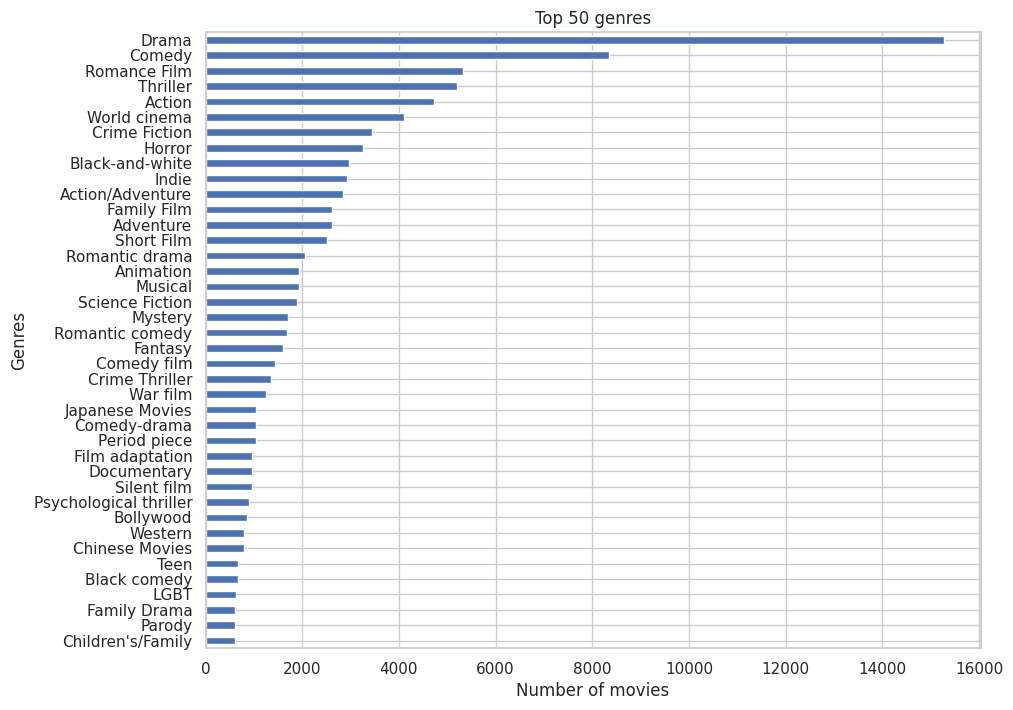

In [16]:
columns_needed = ['Plot', 'Genres', 'merge_year', 'distilbert_emotions']

# we take only the films were the plot is not missing
df_with_plot = df.dropna(subset=['Plot'])[columns_needed]

genre_count = df_with_plot['Genres'].explode().value_counts()

# plot the genre distribution first 50 genres on an orizontal bar plot
plt.figure(figsize=(10, 8))
genre_count[: 40].sort_values().plot(kind='barh')
plt.title('Top 50 genres')
plt.xlabel('Number of movies')
plt.ylabel('Genres')
plt.show()

## Visualizing Emotional Distributions Across Popular Genres


##### To gain a preliminary understanding of how emotions are distributed across the most popular movie genres, we created a heatmap. The selected genres are:

- **Action**, **Action/Adventure**, **Adventure**, **Black-and-white**, **Comedy**, **Crime Fiction**, **Drama**, **Family Film**, **Horror**, **Romance Film**, **Romantic Drama**, **Short Film**, **Thriller**, and **World Cinema**.

##### The emotions analyzed are:

- **Disgust**, **Fear**, **Anger**, **Neutral**, **Sadness**, **Surprise**, and **Joy**.

##### The heatmap visually illustrates the relative intensity of each emotion within each genre, providing insights into the emotional tone associated with different film genres. This visualization sets the stage for a more detailed statistical analysis.


In [17]:
relevant_genres = genre_count[genre_count > 2000].index
temp = df_with_plot.explode('Genres')
df_plot_genres = temp[temp['Genres'].isin(relevant_genres)].reset_index(drop=True)

In [18]:
temp = pd.DataFrame(list(df_plot_genres['distilbert_emotions'].apply(conv_to_dict))).reset_index(drop=True)

# Changes data for time series...
placeholder = pd.concat([df_plot_genres, temp], axis=1)

emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'] 

temp = placeholder.groupby('Genres').agg({
    emotion: ['mean'] for emotion in emotions
}).reset_index()
temp['count'] = placeholder['Genres'].value_counts().sort_index().values

temp.columns = ['Genres'] + emotions + ['count']
final_df = temp.set_index('Genres')
final_df

disgust      fear     anger   neutral   sadness  surprise  \
Genres                                                                         
Action            0.164581  0.157858  0.294362  0.207060  0.109015  0.039658   
Action/Adventure  0.168214  0.164287  0.300741  0.202336  0.107800  0.036135   
Adventure         0.146760  0.169830  0.226376  0.252786  0.124248  0.048896   
Black-and-white   0.188865  0.140518  0.211064  0.209114  0.169323  0.041535   
Comedy            0.159404  0.117332  0.193337  0.261184  0.155883  0.056790   
Crime Fiction     0.197055  0.170661  0.277801  0.172240  0.124140  0.035676   
Drama             0.179407  0.137836  0.197994  0.191499  0.206486  0.040810   
Family Film       0.128007  0.134138  0.191569  0.278214  0.147508  0.063800   
Horror            0.266120  0.301075  0.162985  0.140338  0.074354  0.044445   
Indie             0.187397  0.161976  0.166482  0.226826  0.180094  0.039829   
Romance Film      0.146047  0.107986  0.173731  0.214962  0.238009  0.052127   
Romantic drama    0.158726  0.111873  0.171470  0.191153  0.263211  0.045794   
Short Film        0.188522  0.143926  0.170374  0.293442  0.096887  0.057743   
Thriller          0.191495  0.230795  0.246635  0.159998  0.112830  0.043367   
World cinema      0.193272  0.131769  0.209227  0.191067  0.185803  0.044350   

                       joy  count  
Genres                             
Action            0.027467   4719  
Action/Adventure  0.020486   2841  
Adventure         0.031105   2608  
Black-and-white   0.039581   2958  
Comedy            0.056070   8348  
Crime Fiction     0.022427   3436  
Drama             0.045969  15267  
Family Film       0.056763   2608  
Horror            0.010683   3266  
Indie             0.037395   2922  
Romance Film      0.067139   5329  
Romantic drama    0.057772   2054  
Short Film        0.049106   2512  
Thriller          0.014879   5210  
World cinema      0.044512   4110

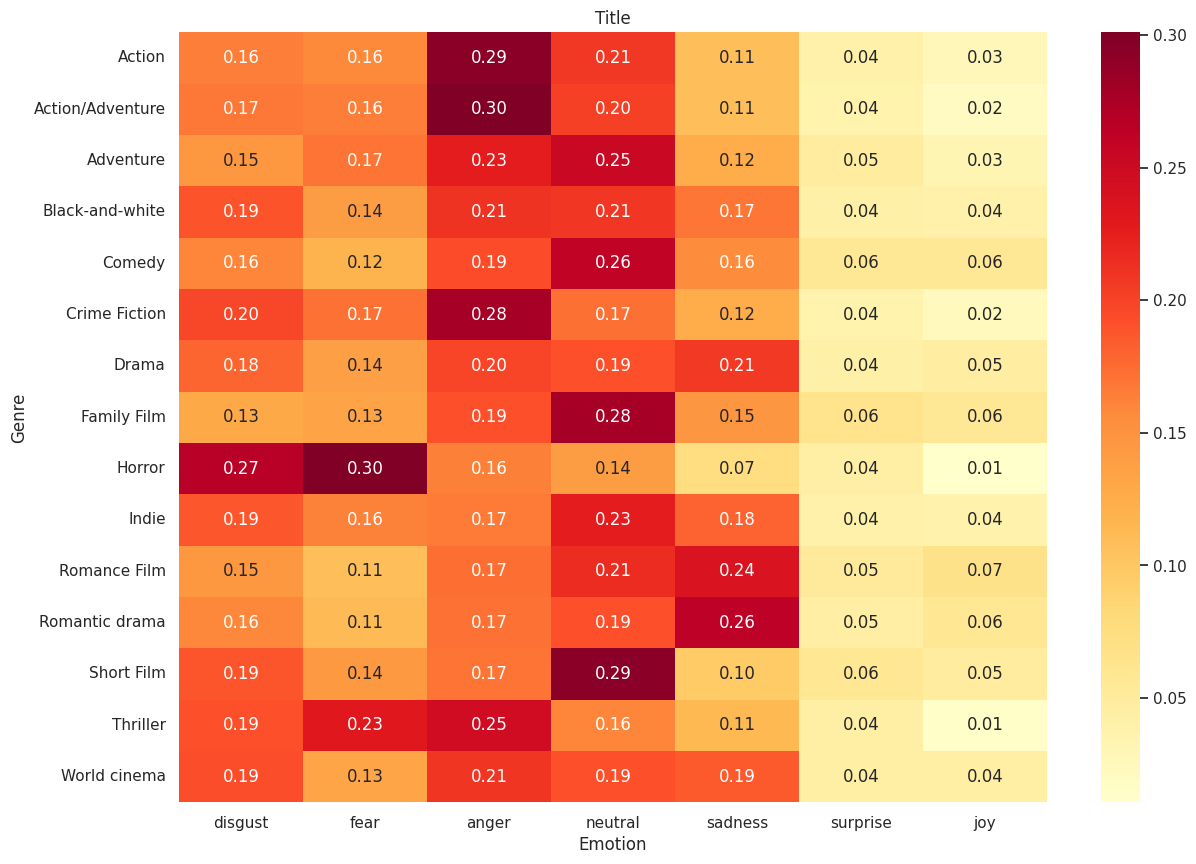

In [19]:
plt.figure(figsize=(14, 10))
sns.heatmap(final_df.drop('count', axis=1), annot=True, fmt='.2f', cbar=True, cmap='YlOrRd')
plt.title('Title')
plt.ylabel('Genre')
plt.xlabel('Emotion')
plt.show()


## Testing Emotional Variation Across Genres Using MANOVA

To formally evaluate the variation of emotions across genres, we performed a **Multivariate Analysis of Variance (MANOVA)**. MANOVA is a statistical test used when there are multiple dependent variables (in this case, emotions) and one or more categorical independent variables (here, genres). It tests whether the mean vectors of the dependent variables differ across levels of the independent variable.

### Statistical Theory Behind MANOVA

MANOVA extends the concept of Analysis of Variance (ANOVA) to multiple dependent variables. It tests the null hypothesis (\( H_0 \)) that the mean vectors of the dependent variables are equal across all groups (genres). Mathematically:

$$
H_0: \mu_1 = \mu_2 = \dots = \mu_k
$$

Where:
- \( $\mu_i$ \) represents the vector of means for the dependent variables (emotions) in the \( i \)-th group (genre).

### Test Statistic

MANOVA calculates the following test statistics to assess the differences:
1. **Pillai's Trace**:
   $
   V = \text{trace}[(E(E+H)^{-1})]
   $
   Where \( E \) is the error matrix, and \( H \) is the hypothesis matrix.

2. **Wilks' Lambda**:
   $
   \Lambda = \frac{\det(E)}{\det(E + H)}
   $
   A smaller value of \( \Lambda \) indicates a stronger difference among group means.

3. **Hotelling-Lawley Trace**:
   $
   T = \text{trace}(H E^{-1})
   $

4. **Roy's Largest Root**:
   $
   \Theta = \text{largest eigenvalue of } (H E^{-1})
   $



In [20]:
from statsmodels.multivariate.manova import MANOVA

In [21]:
placeholder['Genres'] = placeholder['Genres'].astype('category')

In [22]:
manova = MANOVA.from_formula(f'{ " + ".join(emotions_without_neutral) } ~ Genres', data=placeholder)
result = manova.mv_test()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Multivariate linear model
==================================================================
                                                                  
------------------------------------------------------------------
       Intercept        Value  Num DF   Den DF    F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.4863 6.0000 68168.0000 12002.9242 0.0000
         Pillai's trace 0.5137 6.0000 68168.0000 12002.9242 0.0000
 Hotelling-Lawley trace 1.0565 6.0000 68168.0000 12002.9242 0.0000
    Roy's greatest root 1.0565 6.0000 68168.0000 12002.9242 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
         Genres         Value   Num DF    Den DF   F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.8607 84.0000 379954.0376 123.4368 0.0000
         Pillai's trace 0.1458 84.0000 409038.0000 121.2627 0.0000
 Hotelling-Lawley trace 0.1545 84.0000 279139.1349 125.4173 0.0000
    Roy's greatest root 0.0851 14.0000  68173.0000 414.3267 0.0000
==================================================================

"""

### Interpretation 
#### The MANOVA test provide insight into the statistical relationship between the independent variable Genres and multiple dependent variables emotions.

- Null Hypothesis (H_0):
	The means of the dependent variables (emotions) are equal across all levels of the independent variables Genres.

- Alternative Hypothesis (H_1):
	At least one of the dependent variable means significantly differs across the levels of Genres.
	
#### Results:
##### Intercept Results:

The intercept is significant (p < 0.0001), meaning there is significant variation in the non-neutral emotion scores overall, even without considering Genres.

#### Genres Results: 

The results show that the mean probabilities of the non-neutral emotions (e.g., happiness, sadness, anger) significantly differ across the levels of Genres (p < 0.0001).
Wilks’ Lambda = 0.8607: About 14% of the variation in the non-neutral emotions is explained by Genres.
Pillai's Trace = 0.1458: This reinforces the modest but significant effect size.
Roy’s Greatest Root = 0.0851: Suggests that one or more specific emotions might be strongly affected by Genres.

## Comparing Emotional Scores Across Relevant Genres

#### To delve deeper into how each emotion is distributed among the most relevant genres, we created a series of bar plots. Each plot represents the average score of a specific emotion for each genre. 

#### For better context, we added a horizontal line in each plot, indicating the weighted average score for that emotion across all relevant genres. This line serves as a benchmark, allowing us to identify which genres exhibit scores significantly above or below the overall average.




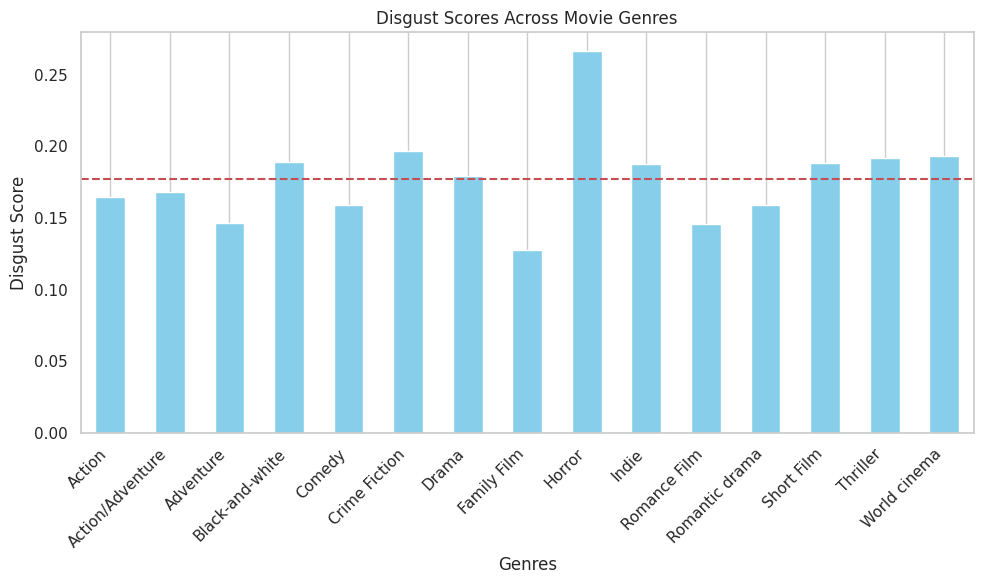

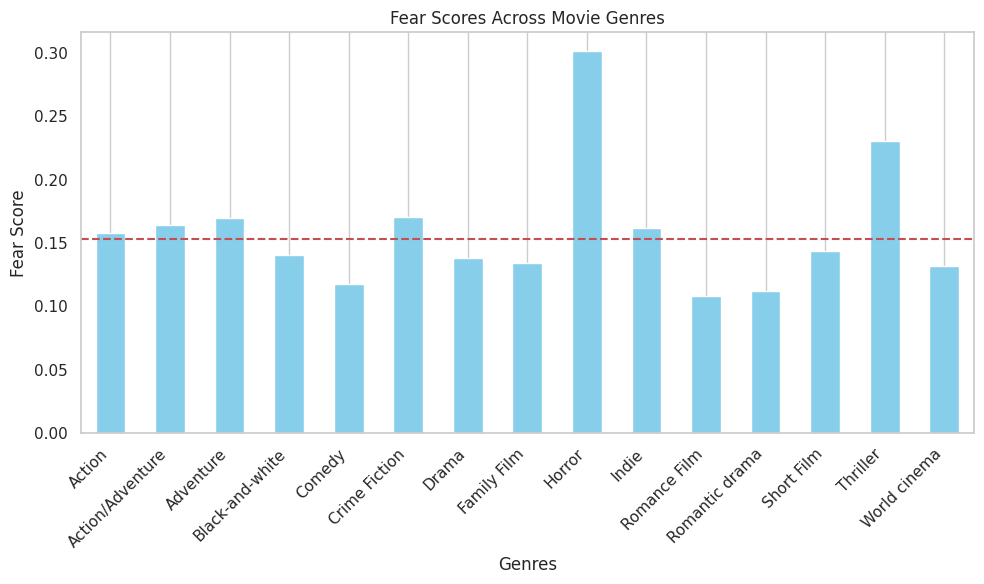

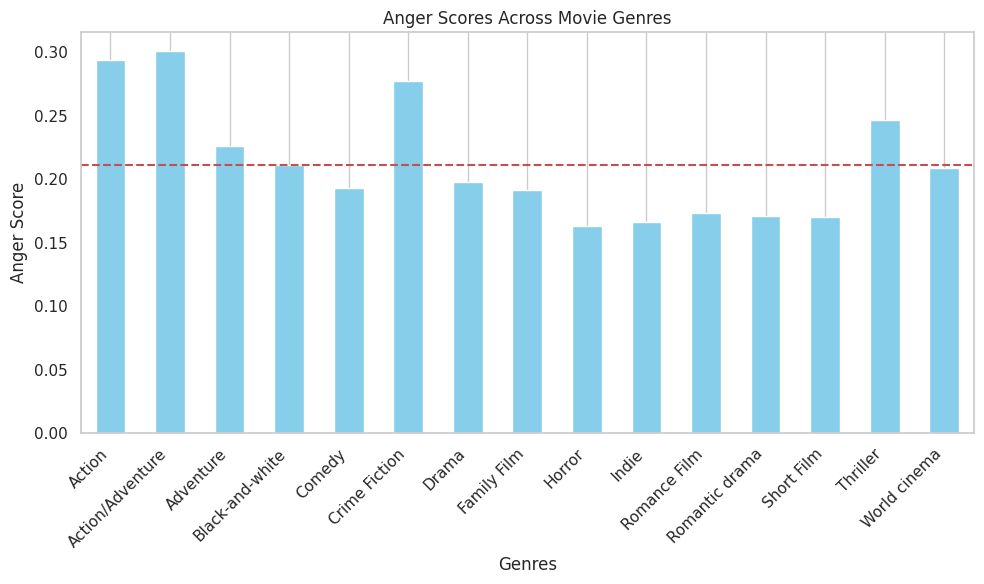

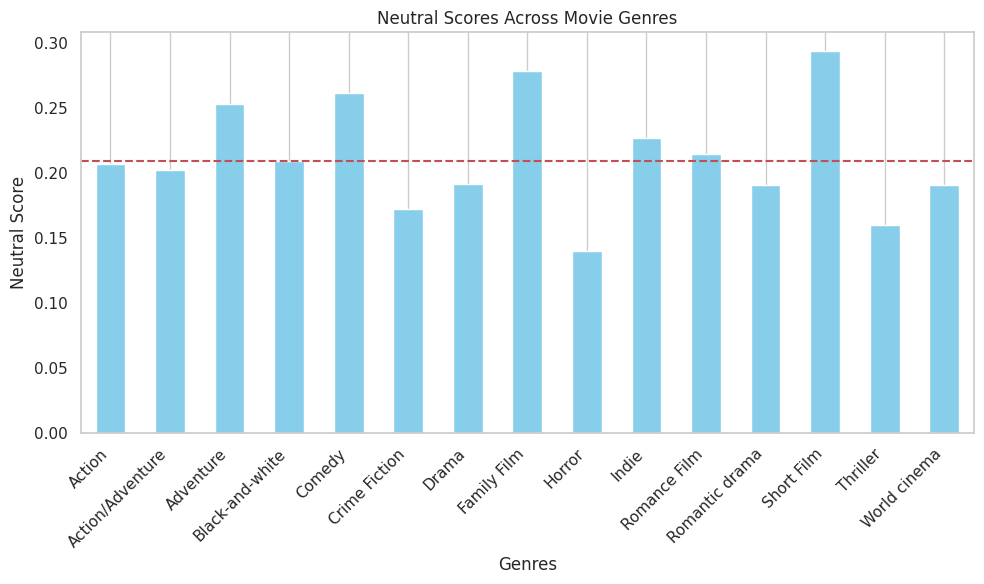

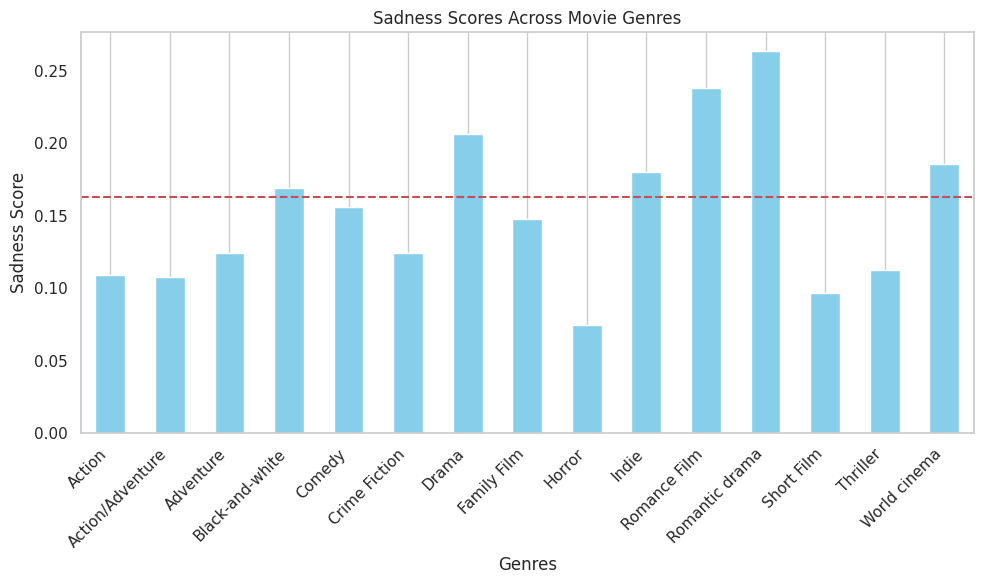

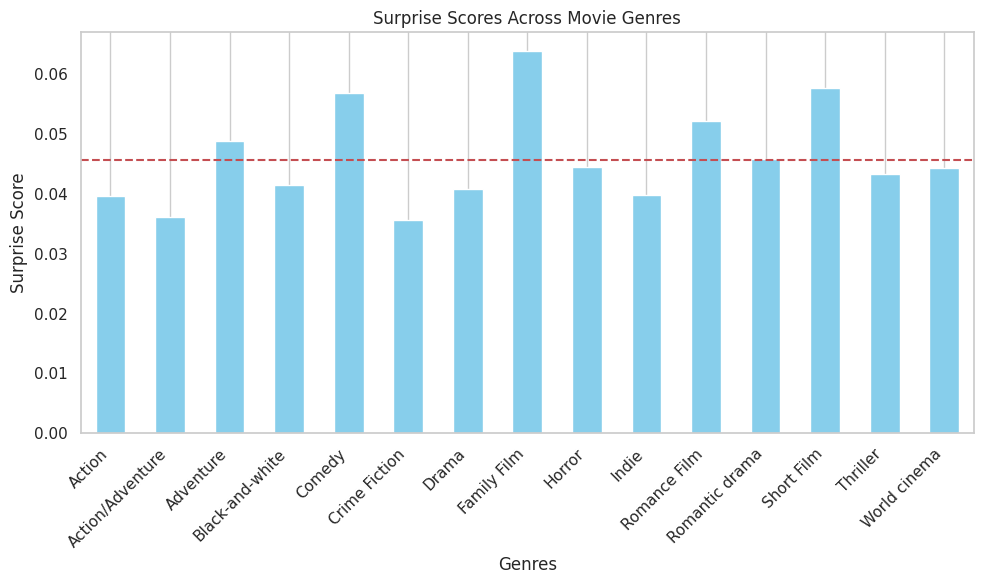

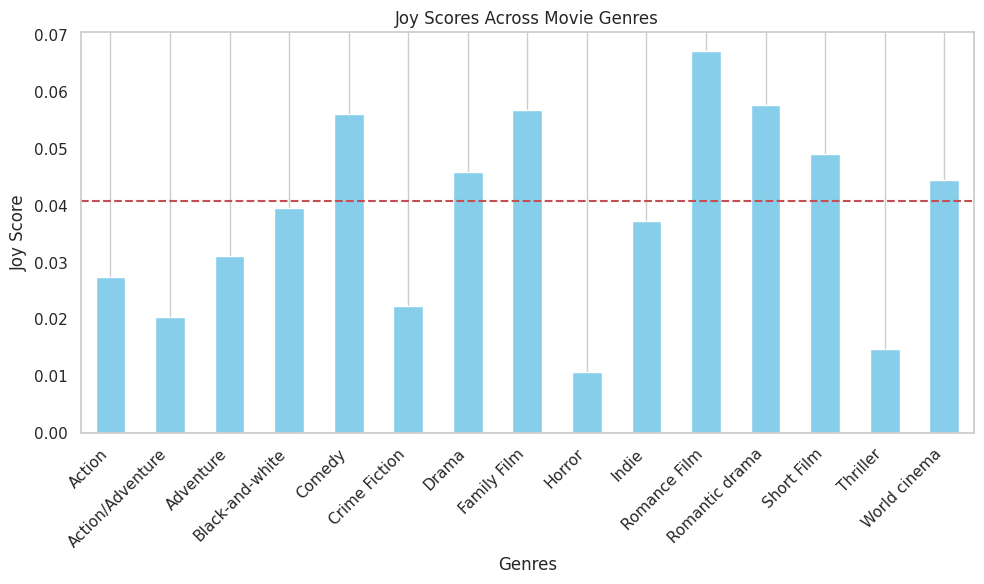

In [23]:
sum_movies = final_df['count'].sum()
weight_avg = final_df[emotions].mul(final_df['count'], axis=0).sum() / sum_movies

for emotion in emotions:
    plt.figure(figsize=(10, 6))
    final_df[emotion].plot(kind = 'bar', title = f"{emotion.capitalize()} Scores Across Movie Genres", color = 'skyblue') 
    plt.axhline(y = weight_avg[emotion], color = 'r', linestyle = '--', label = 'Average Score')
    plt.xlabel('Genres')
    plt.ylabel(f"{emotion.capitalize()} Score")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

## Statistical Validation of Emotional Representation in Genres Using T-tests

To address potential imbalances in model classification and gain a deeper understanding of which emotions are significantly associated with specific genres, we performed **t-tests**. This analysis compares the emotion scores for each genre against the weighted average score for that emotion across all genres.

---

### Statistical Theory Behind the T-test

The **t-test** is a statistical test used to determine if the mean of a sample differs significantly from a known value (one-sample t-test) or another sample (two-sample t-test). In our case, we used the one-sample t-test to compare the mean emotion score for a given genre to the weighted average score.

#### Null and Alternative Hypotheses
For each emotion within each genre:
- **Null Hypothesis (\($H_0$\))**: The mean emotion score for the genre is equal to the weighted average score across all genres.
$
H_0: \mu_{\text{genre}} = \mu_{\text{weighted avg}}
$
- **Alternative Hypothesis (\($H_1$\))**: The mean emotion score for the genre is significantly higher than the weighted average score.
$
H_1: \mu_{\text{genre}} > \mu_{\text{weighted avg}}
$

#### Test Statistic
The t-statistic is calculated as:
$$
t = \frac{\bar{x} - \mu}{\frac{s}{\sqrt{n}}}
$$
Where:
- \( $\bar{x}$ \) = sample mean (emotion score for the genre)
- \( $\mu $\) = population mean (weighted average emotion score)
- \( $s $\) = standard deviation of the sample
- \($ n$ \) = sample size

#### Degrees of Freedom
The degrees of freedom (\(df\)) for the t-test is:
\[
df = n - 1
\]

#### Interpretation
The resulting \( p \)-value from the t-test indicates whether the mean emotion score for the genre is significantly higher than the weighted average:
- If \( p < 0.05 \), we reject \(H_0\), concluding that the genre has a significantly higher score for that emotion.

---

### Visualizing Significant Emotions for Each Genre

To illustrate the results of the t-tests, we created a series of bar plots. Each plot represents the emotion scores for a specific genre. Bars corresponding to emotions that are significantly higher than the weighted average (based on the t-test results) are highlighted in a distinct color.

### Insights from the Visualization
These plots allow us to:
- Clearly identify the emotions that define each genre statistically.
- Understand how different genres deviate from the overall emotional landscape.

This combined statistical and visual approach provides a robust way to validate the relationship between emotions and genres.


###############################################################
 Statistically significant emotions for Action: anger


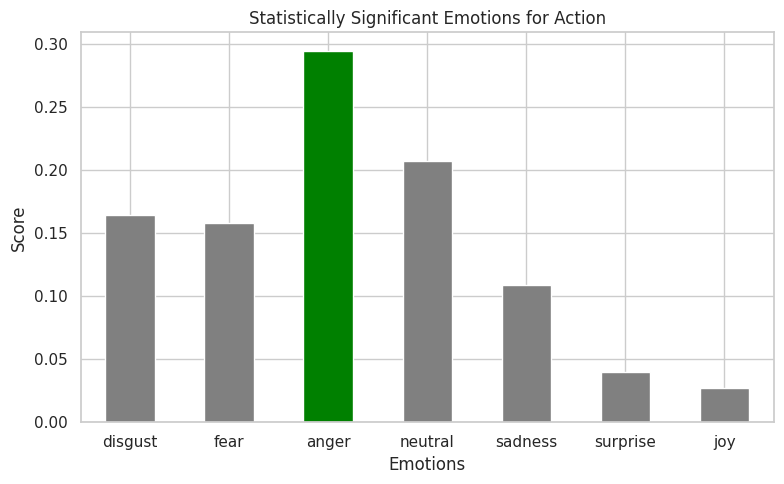

###############################################################
 Statistically significant emotions for Action/Adventure: anger


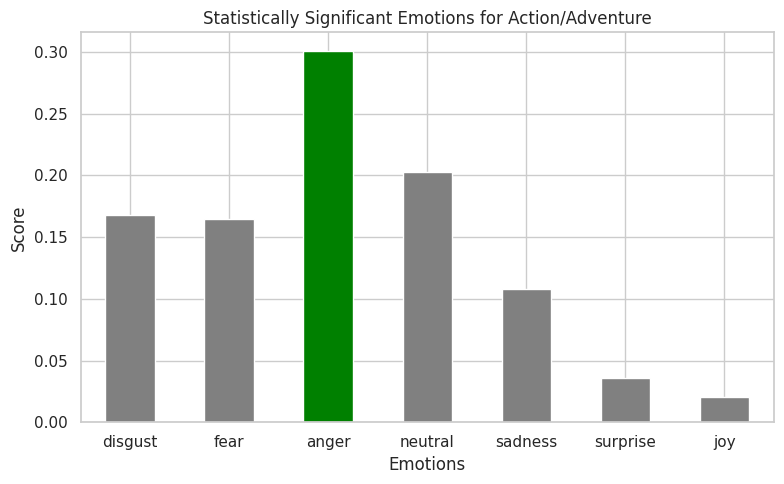

###############################################################
 Statistically significant emotions for Adventure: neutral


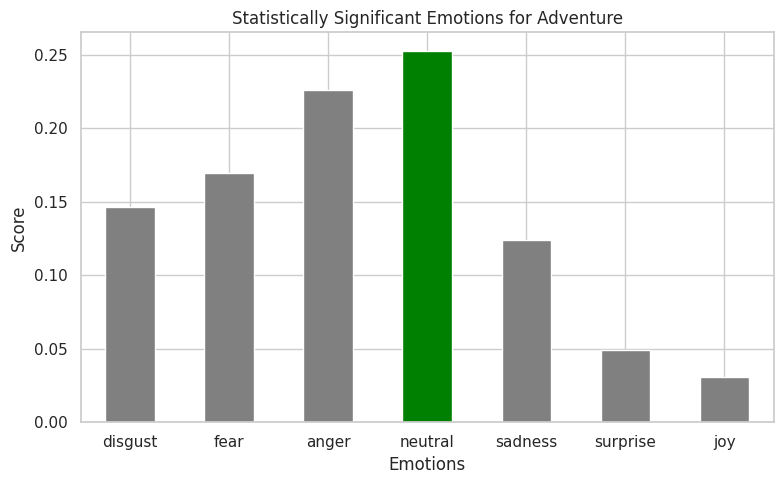

###############################################################
 Statistically significant emotions for Black-and-white: 


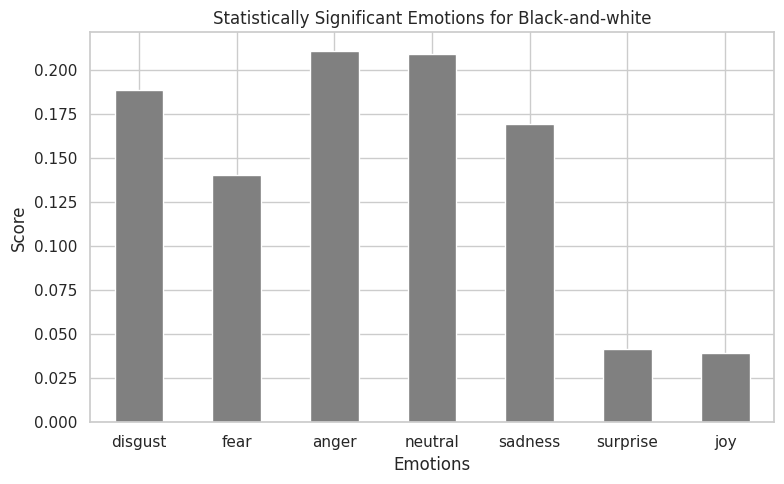

###############################################################
 Statistically significant emotions for Comedy: neutral, surprise, joy


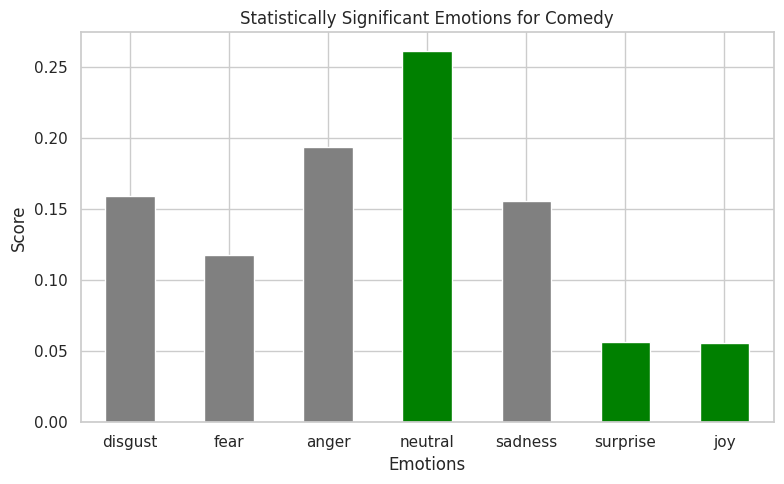

###############################################################
 Statistically significant emotions for Crime Fiction: disgust, anger


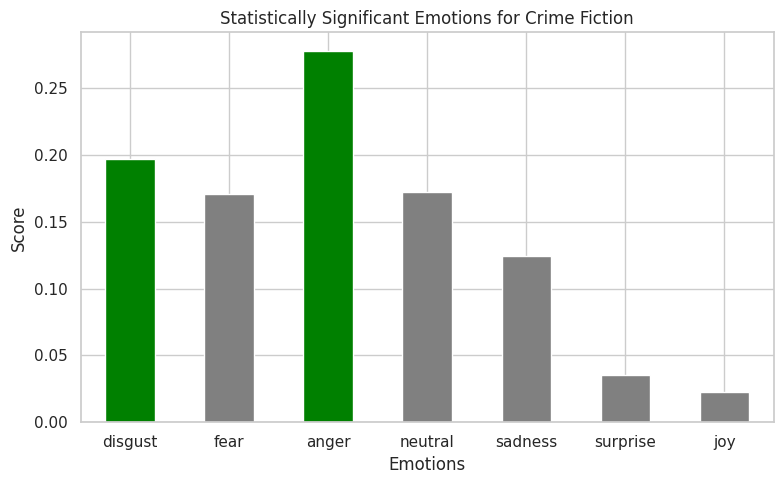

###############################################################
 Statistically significant emotions for Drama: sadness


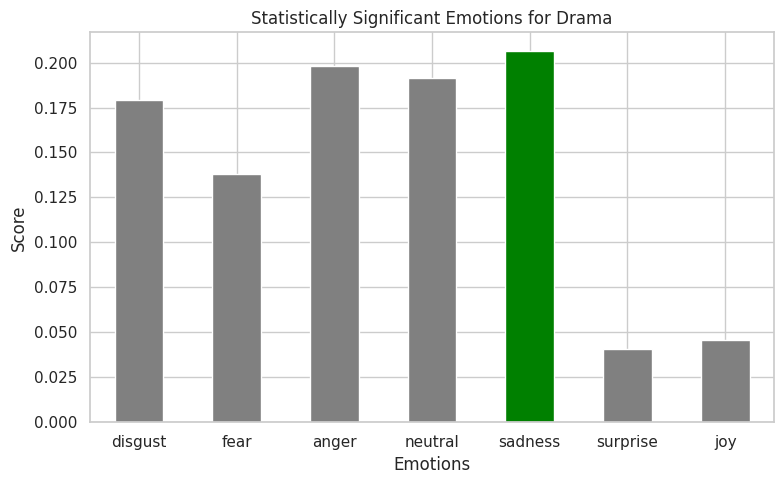

###############################################################
 Statistically significant emotions for Family Film: neutral, surprise, joy


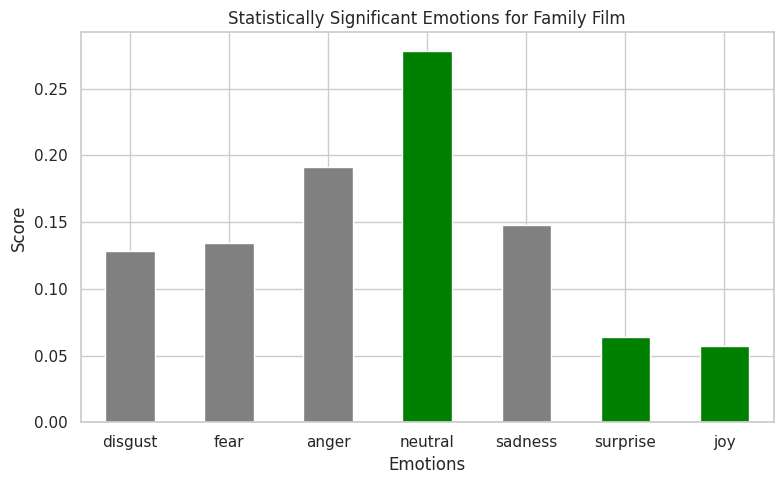

###############################################################
 Statistically significant emotions for Horror: disgust, fear


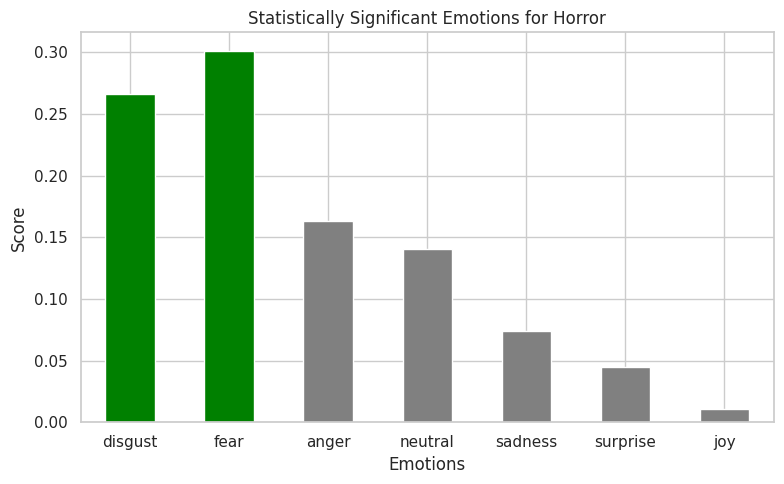

###############################################################
 Statistically significant emotions for Indie: sadness


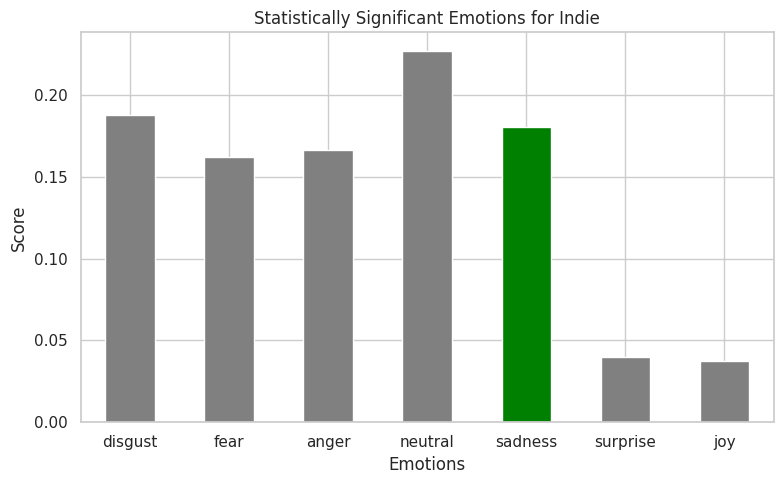

###############################################################
 Statistically significant emotions for Romance Film: sadness, surprise, joy


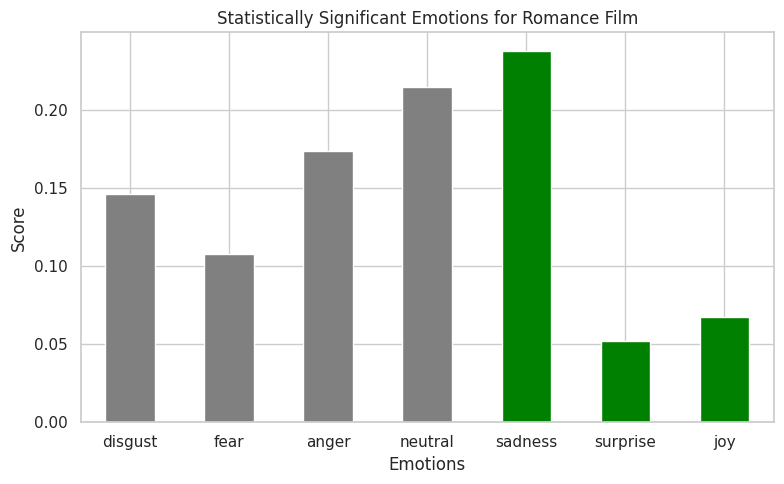

###############################################################
 Statistically significant emotions for Romantic drama: sadness, joy


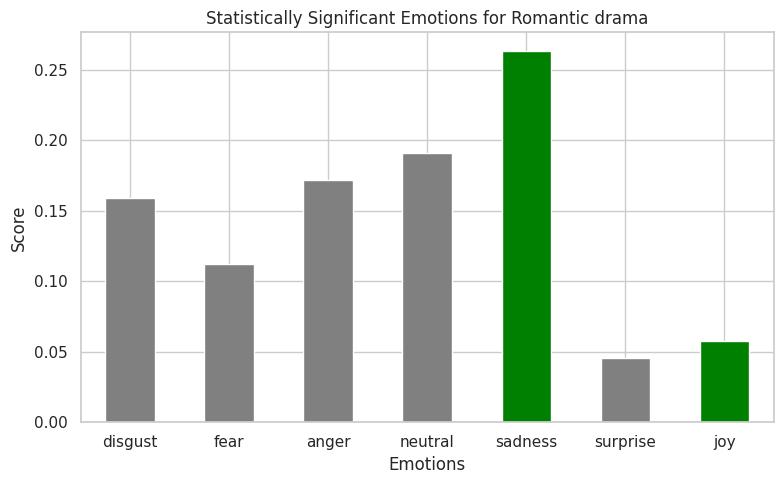

###############################################################
 Statistically significant emotions for Short Film: neutral, surprise, joy


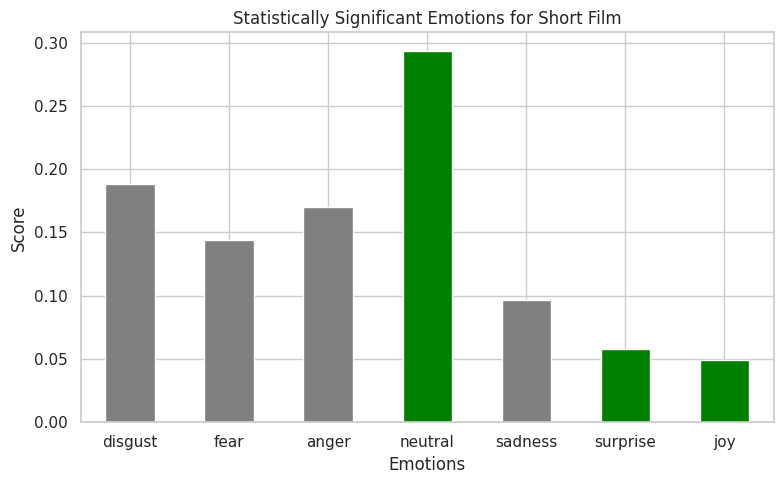

###############################################################
 Statistically significant emotions for Thriller: fear, anger


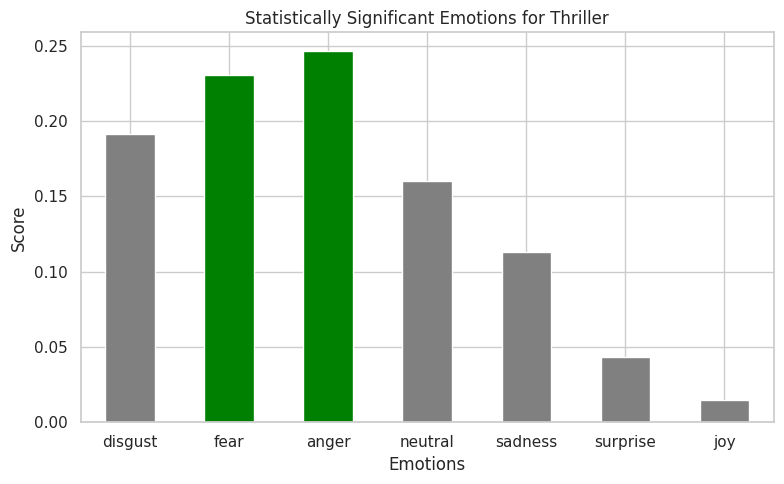

###############################################################
 Statistically significant emotions for World cinema: disgust, sadness


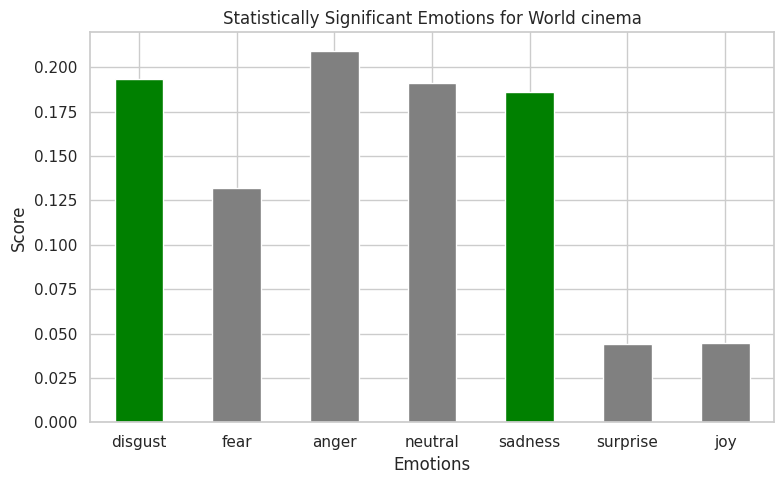

In [24]:
from scipy.stats import ttest_1samp

stat_significant_emotions = {}

for genre in final_df.index:
    genre_emotions = final_df.loc[genre, emotions]
    significant_emotions = []
    for emotion in emotions:
        # Perform a one-sample t-test
        stat, p_value = ttest_1samp(final_df[emotion], genre_emotions[emotion])
        if p_value / 2 < 0.05 and genre_emotions[emotion] > weight_avg[emotion]:
            significant_emotions.append(emotion)
    stat_significant_emotions[genre] = significant_emotions

for genre in stat_significant_emotions.keys():
    genre_emotions = final_df.loc[genre, emotions]
    significant_emotions = stat_significant_emotions[genre]
    print("###############################################################\n",
          f"Statistically significant emotions for {genre}: {', '.join(significant_emotions)}")
    plt.figure(figsize=(8, 5))
    genre_emotions.plot(kind='bar', color=['green' if emotion in significant_emotions else 'gray' for emotion in emotions])
    plt.title(f"Statistically Significant Emotions for {genre}")
    plt.xlabel("Emotions")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Results: Predominant Emotional Tones by Genre and Their Inclusion in Time Series Analysis

After analyzing the data, we identified the predominant emotional tones for each genre and made decisions on whether to include them in the time series analysis. Below are the results:

- **Action**:  
  The predominant tone is **anger**, which aligns with expectations for this genre. We will explore how the expression of anger has evolved over time in the time series analysis.

- **Action/Adventure**:  
  The predominant tone is also **anger**, similar to the Action genre. To avoid redundancy, we will only include the Action genre in the time series analysis.

- **Adventure**:  
  The predominant tone is **neutral**, which is surprising. However, analyzing the evolution of a neutral emotion over time does not seem insightful. Furthermore, Adventure is closely related to Action, so it will not be included in the time series analysis.

- **Black-and-White**:  
  There is no predominant tone, which makes sense as this category reflects a characteristic of the movie rather than a genre. It will not be included in the time series analysis.

- **Comedy**:  
  The predominant tones are **neutral**, **surprise**, and **joy**. While we are not interested in the neutral emotion, we will include **surprise** and **joy** in the time series analysis.

- **Crime Fiction**:  
  The predominant tones are **disgust** and **anger**. Both will be included in the time series analysis.

- **Drama**:  
  The predominant tone is **sadness**, which is expected for this genre. This emotion will be included in the time series analysis.

- **Family Film**:  
  The predominant tones are **neutral**, **surprise**, and **joy**. Similar to Comedy, we will exclude neutral but include **surprise** and **joy** in the time series analysis.

- **Horror**:  
  The predominant tones are **fear** and **disgust**. Both will be included in the time series analysis.

- **Indie**:  
  The predominant tone is **sadness**, which is fitting for this genre. We will include sadness in the time series analysis.

- **Romance Film**:  
  The predominant tones are **sadness**, **joy**, and **surprise**. To focus the analysis, we will include only **sadness** and **joy** in the time series analysis.

- **Romantic Drama**:  
  The predominant tones are **sadness** and **joy**, which are similar to those in Romance Film. To avoid redundancy, this genre will not be included in the time series analysis.

- **Short Film**:  
  The predominant tones are **neutral**, **surprise**, and **joy**. Like Black-and-White, this category reflects a characteristic rather than a genre. It will not be included in the time series analysis.

- **Thriller**:  
  The predominant tones are **fear** and **anger**. Both will be included in the time series analysis.

- **World Cinema**:  
  This genre represents films made outside the American motion picture industry, often opposing the aesthetics and values of mainstream Hollywood. To gain insights into emotional trends outside Hollywood, we will include this genre. The predominant tones are **sadness** and **disgust**, both of which will be included in the time series analysis.


# How has the emotional tone of films evolved over time within each genre?


### To address this research question, we began by conducting a visualization analysis to explore the evolution of emotional tones over time. Specifically, we plotted the time series of each emotion score for the genres included in our analysis.




In [25]:
emotion_by_time = emotions_df.groupby('merge_year').agg({
    emotion: ['mean'] for emotion in emotions
})
emotion_by_time.columns = emotions

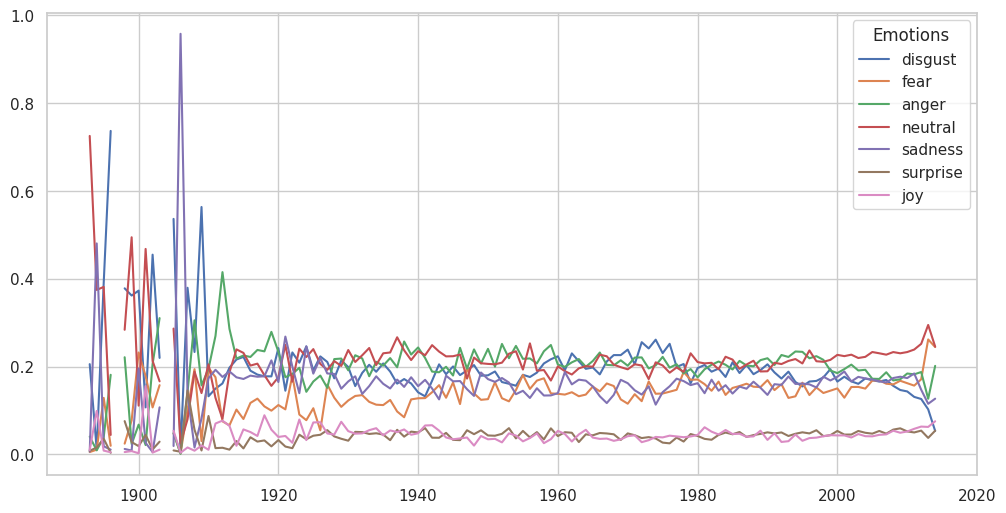

In [26]:
plt.figure(figsize=(12, 6))

for column in emotion_by_time.columns:
    plt.plot(emotion_by_time.index, emotion_by_time[column], label=column)

plt.legend(title='Emotions', loc='best')

<Axes: xlabel='merge_year', ylabel='Count'>

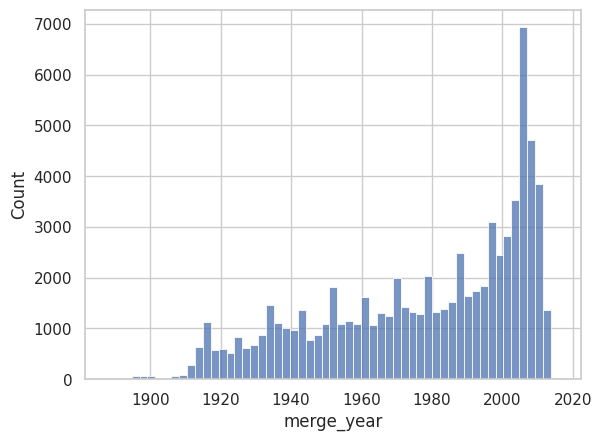

In [27]:
sns.histplot(emotions_df['merge_year'], kde=False)

In [62]:
movie_counts = emotions_df.groupby(['merge_year']).agg(
    counts=('merge_year', 'size')
)
movie_counts[movie_counts.index >= 2010]

counts
merge_year        
2010          2024
2011          1824
2012          1195
2013           164
2014            17
2015             4
2016             3

In [29]:
emotion_by_time = emotion_by_time[(emotion_by_time.index >= 1925) & (emotion_by_time.index < 2012)]

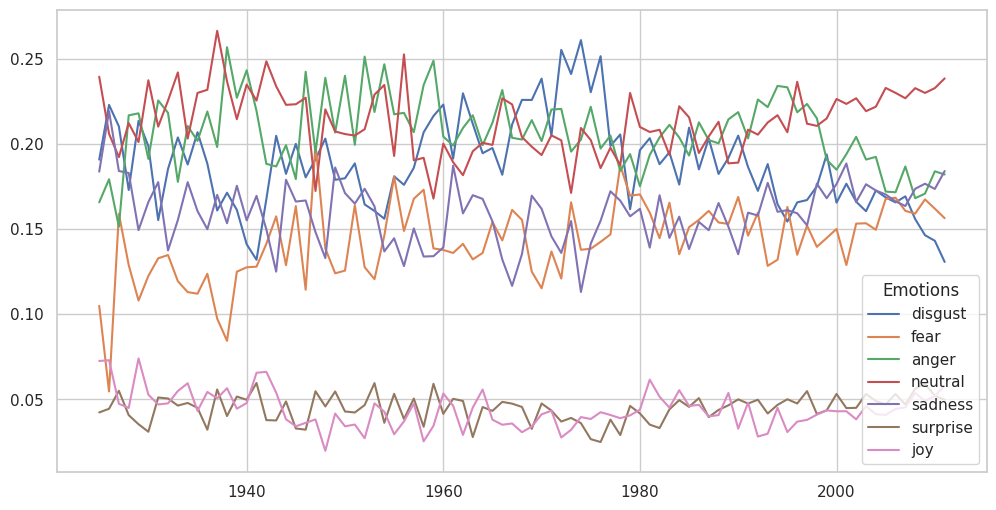

In [30]:
plt.figure(figsize=(12, 6))

for column in emotion_by_time.columns:
    plt.plot(emotion_by_time.index, emotion_by_time[column], label=column)

plt.legend(title='Emotions', loc='best')

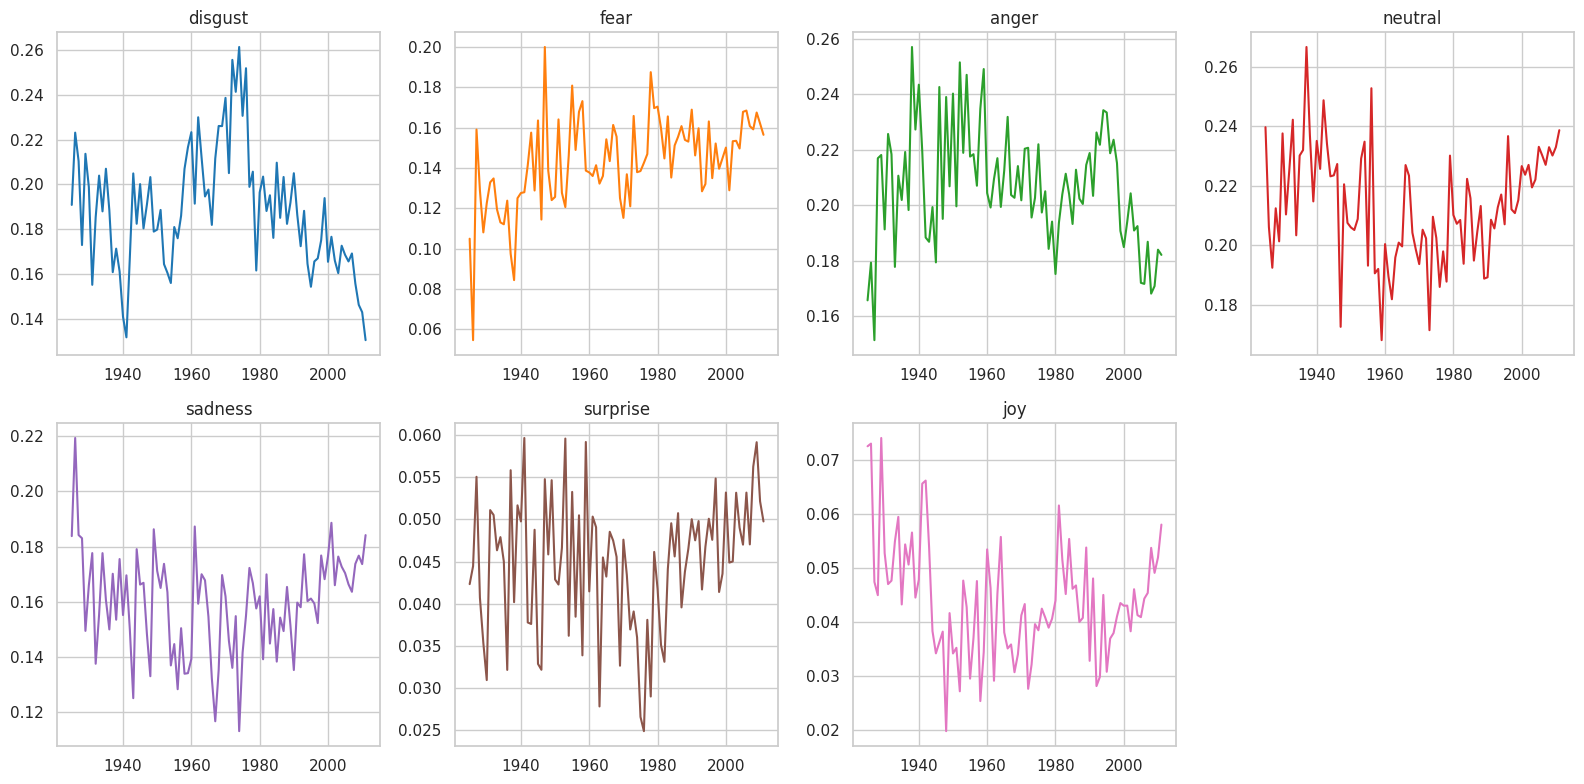

In [31]:
num_emotions = len(emotion_by_time.columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
colors = sns.color_palette("tab10", len(emotion_by_time.columns))

for ax, column, color in zip(axes, emotion_by_time.columns, colors):
    ax.plot(emotion_by_time.index, emotion_by_time[column], color=color)
    ax.set_title(column)

for ax in axes[num_emotions: ]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Initial Observations

#### From the initial visualizations, we observed that:
- Prior to **1925** and after **2010**, the number of data points (films) was significantly lower compared to other years.  
- This lack of data resulted in high variance, making the time series unstable and less reliable during these periods.

### Decision

To ensure the stability and reliability of our analysis, we excluded all films released before **1925** and after **2011** from our dataset. This adjustment focuses the analysis on a time range with sufficient data points for each year, providing more accurate and meaningful insights into the evolution of emotional tones across genres.

#### Now let's try to gain a deeper understanding and even make some predictions with time series analysis

## Time Series Analysis: Applying the Box-and-Jenkins Procedure and ARIMA Models

To explore how emotional tones have evolved over time within each genre, we focused on the relevant genres and their predominant tones identified in the first research question. For each selected time series, we applied the **Box-and-Jenkins procedure**, culminating in the use of **ARIMA models** to analyze trends and patterns.

---

### Theory: The Box-and-Jenkins Procedure

The **Box-and-Jenkins procedure** is a systematic methodology for building and analyzing time series models, particularly **ARIMA models**. It involves three primary stages:

1. **Identification**:  
   - Transform the raw data (e.g., differencing or log transformation) to achieve stationarity, where the statistical properties (mean and variance) remain constant over time.
   - Use tools such as the **autocorrelation function (ACF)** and the **partial autocorrelation function (PACF)** to identify the order of the ARIMA model components.

2. **Estimation**:  
   - Fit an ARIMA model to the transformed data by estimating its parameters (\(p\), \(d\), and \(q\)) using statistical methods like maximum likelihood estimation.

3. **Diagnostic Checking**:  
   - Validate the model by analyzing residuals (differences between observed and predicted values). Residuals should resemble white noise: uncorrelated and normally distributed with zero mean.
   - If the model is inadequate, refine it by revisiting the identification and estimation steps.

#### Stationarity
Stationarity is critical in time series modeling. A time series is stationary if its statistical properties, such as mean, variance, and autocorrelation, are constant over time. Non-stationary data can be made stationary through techniques like **differencing**.

#### Autocorrelation and Partial Autocorrelation
- **Autocorrelation Function (ACF)**: Measures the correlation between observations at different lags.
- **Partial Autocorrelation Function (PACF)**: Measures the correlation between observations at different lags, accounting for the correlations at intermediate lags.

---

### ARIMA Models: Theory and Formulation

An **ARIMA model** (AutoRegressive Integrated Moving Average) is a class of models that explains a time series based on its own past values, past forecast errors, and a differencing term to achieve stationarity.

#### Components of ARIMA
ARIMA(\(p, d, q\)) has three components:
1. **AutoRegressive (AR)** component (\(p\)):  
   Relates the current value of the series to its past values.  
   Formula:  
   $$
   X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t
   $$
   Where:
   - \($X_t$\): Value at time \(t\)
   - \($\phi_i$\): AR coefficients
   - \($\epsilon_t$\): White noise (random error)

2. **Integrated (I)** component (\(d\)):  
   Represents the number of differencing operations needed to make the time series stationary.  
   Differencing formula:  
   $$
   X_t' = X_t - X_{t-1}
   $$

3. **Moving Average (MA)** component (\(q\)):  
   Models the dependency between an observation and residual errors from a moving average model applied to lagged observations.  
   Formula:  
   $$
   X_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}
   $$
   Where:
   - \($\theta_i$\): MA coefficients

#### Combined ARIMA Model
The ARIMA(\(p, d, q\)) model is given by:
$$
X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}
$$
Where \(X_t\) represents the \(d\)-th differenced series.

---

### Significance of the Box-and-Jenkins Procedure and ARIMA Models

By applying the Box-and-Jenkins procedure and ARIMA models, we:
- Ensure the time series is appropriately transformed and modeled, capturing both short-term and long-term dependencies.
- Identify significant patterns and trends in emotional tones over time within each genre.
- Provide robust statistical frameworks to predict future trends based on historical data.


In [32]:
columns_needed= ['Plot', 'Genres', 'merge_year', 'nrclex_emotions', 'roberta_emotions', 'distilbert_emotions']
df_tone= df.dropna(subset=['Plot'])[columns_needed]
df_tone['Genres'] = df_tone['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

relevant_genres = genre_count[genre_count>2000].index
df_ex_gen = df_tone.explode('Genres')
df_ex_relgen = df_ex_gen[df_ex_gen['Genres'].isin(relevant_genres)].reset_index(drop=True)

temp = pd.DataFrame(list(df_ex_relgen['distilbert_emotions'].apply(conv_to_dict))).reset_index(drop=True)
time_series_df = pd.concat([df_ex_relgen, temp], axis=1)

grouped_df = time_series_df.groupby(['Genres', 'merge_year'])[emotions].mean().reset_index()

genres_emotions_mapping = {
    "Action": ["anger"],
    "Comedy": ["surprise", "joy"],
    "Crime Fiction": ["disgust", "anger"],
    "Drama": ["sadness"],
    "Family Film": ["surprise", "joy"],
    "Horror": ["fear", "disgust"],
    "Indie": ["sadness"],
    "Romance Film": ["sadness", "joy"],
    "Thriller": ["fear", "anger"],
    "World cinema": ["sadness", "disgust"]
}

filtered_df = grouped_df[(grouped_df["Genres"].isin(genres_emotions_mapping.keys())) &
                        ((grouped_df["merge_year"] >= 1925) & (grouped_df["merge_year"] < 2012))]
filtered_df[filtered_df['Genres'] == 'World cinema']

Genres  merge_year   disgust      fear     anger   neutral  \
1423  World cinema        1927  0.058494  0.361429  0.454733  0.083778   
1424  World cinema        1928  0.155387  0.282051  0.448896  0.067146   
1425  World cinema        1929  0.450881  0.018192  0.059123  0.103908   
1426  World cinema        1930  0.228029  0.110362  0.269671  0.100799   
1427  World cinema        1931  0.090704  0.022110  0.343663  0.218374   
...            ...         ...       ...       ...       ...       ...   
1501  World cinema        2007  0.170133  0.158563  0.181986  0.208199   
1502  World cinema        2008  0.159076  0.122740  0.179165  0.231670   
1503  World cinema        2009  0.147819  0.161387  0.180398  0.219040   
1504  World cinema        2010  0.179574  0.146968  0.187775  0.219774   
1505  World cinema        2011  0.144722  0.102013  0.223741  0.210499   

       sadness  surprise       joy  
1423  0.027268  0.011397  0.002901  
1424  0.039003  0.002362  0.005156  
1425  0.298626  0.055974  0.013297  
1426  0.276180  0.010927  0.004030  
1427  0.144336  0.089297  0.091517  
...        ...       ...       ...  
1501  0.181751  0.056520  0.042847  
1502  0.196654  0.045741  0.064955  
1503  0.193846  0.058199  0.039312  
1504  0.152972  0.048458  0.064478  
1505  0.195826  0.064587  0.058612  

[83 rows x 9 columns]

In [33]:
# Dividing the data into separate dataframes to separate the time series analysis 
genre_dataframes = {}

for genre, emotions in genres_emotions_mapping.items():
    genre_data = filtered_df[filtered_df["Genres"] == genre]
    genre_dataframes[genre] = genre_data[["merge_year"] + emotions].dropna()

action_df = genre_dataframes["Action"]
comedy_df = genre_dataframes["Comedy"]
crime_fiction_df = genre_dataframes["Crime Fiction"]
drama_df = genre_dataframes["Drama"]
family_film_df = genre_dataframes["Family Film"]
horror_df = genre_dataframes["Horror"]
indie_df = genre_dataframes["Indie"]
romance_film_df = genre_dataframes["Romance Film"]
thriller_df = genre_dataframes["Thriller"]
world_cinema_df = genre_dataframes["World cinema"]

## Machine Learning-Based Approach to Modeling Multiple Time Series

Given the complexity of dealing with multiple time series simultaneously, we adopted a machine learning-inspired approach to select the best ARIMA model for each time series. This method combined statistical testing, parameter optimization, and model selection based on the Akaike Information Criterion (AIC).

---

### Augmented Dickey-Fuller Test: Testing for Stationarity

To determine whether each time series was stationary, we used the **Augmented Dickey-Fuller (ADF) test**. The ADF test checks the null hypothesis ($H_0$) that a unit root is present in the time series, indicating non-stationarity. 

#### Hypotheses
- $H_0$: The time series has a unit root (non-stationary).
- $H_1$: The time series does not have a unit root (stationary).

#### Test Statistic
The ADF test statistic is derived from the regression equation:
$$
\Delta X_t = \alpha + \beta t + \gamma X_{t-1} + \delta_1 \Delta X_{t-1} + \delta_2 \Delta X_{t-2} + \dots + \delta_k \Delta X_{t-k} + \epsilon_t
$$
Where:
- $X_t$: Value of the series at time $t$.
- $\Delta X_t = X_t - X_{t-1}$: First differenced series.
- $t$: Time trend (optional).
- $\epsilon_t$: White noise error term.
- $\gamma$: The coefficient on $X_{t-1}$ is critical for testing stationarity.

The null hypothesis is rejected if $\gamma < 0$ and the $p$-value is less than 0.05, indicating stationarity.

#### Decision Rule
- If $p$-value > 0.05, we set $d = 1$ (differencing needed).
- If $p$-value \(\leq\) 0.05, we set $d = 0$ (no differencing needed).

---

### Parameter Optimization: ARIMA Orders

We evaluated various combinations of the ARIMA orders:
- **AutoRegressive order ($p$)**: {1, 2, 3}.
- **Moving Average order ($q$)**: {0, 1, 2}.
- **Differencing order ($d$)**: Determined using the ADF test.

For each combination of $p$, $d$, and $q$, we fitted an ARIMA model and selected the best model based on the Akaike Information Criterion (AIC).

---

### Akaike Information Criterion (AIC): Model Selection

The AIC is a metric used to compare statistical models, balancing goodness-of-fit and model complexity. A lower AIC score indicates a better model.

#### AIC Formula
$$
\text{AIC} = 2k - 2 \ln(L)
$$
Where:
- $k$: Number of parameters in the model.
- $L$: Maximum likelihood of the model.

#### Explanation
- The first term ($2k$) penalizes model complexity to prevent overfitting.
- The second term ($-2 \ln(L)$) rewards goodness-of-fit, where $L$ is the likelihood of the model given the data.

By minimizing the AIC, we ensured that the selected model achieved the best trade-off between accuracy and simplicity.

---

### Summary of Our Approach

1. **Stationarity Check**: Performed the ADF test to determine the differencing order ($d$).
2. **Parameter Tuning**: Tested combinations of $p = \{1, 2, 3\}$ and $q = \{0, 1, 2\}$ for the given $d$.
3. **Model Selection**: Chose the ARIMA model with the lowest AIC score for each time series.

This systematic approach enabled us to model the evolution of emotional tones across genres effectively and with statistical rigor.


#### Action movies Time Series Analysis

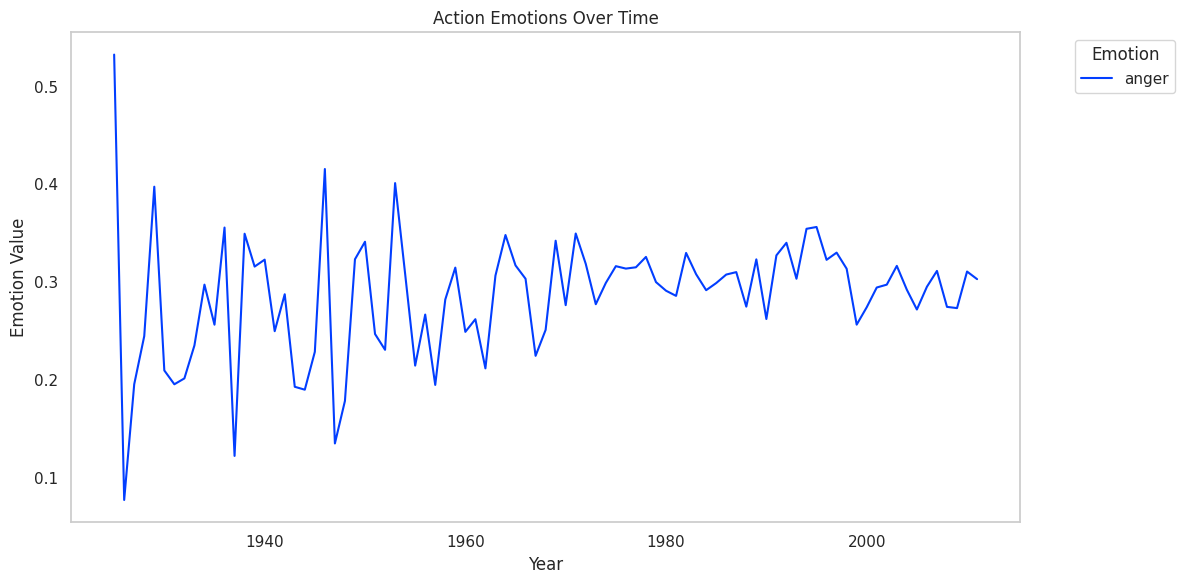

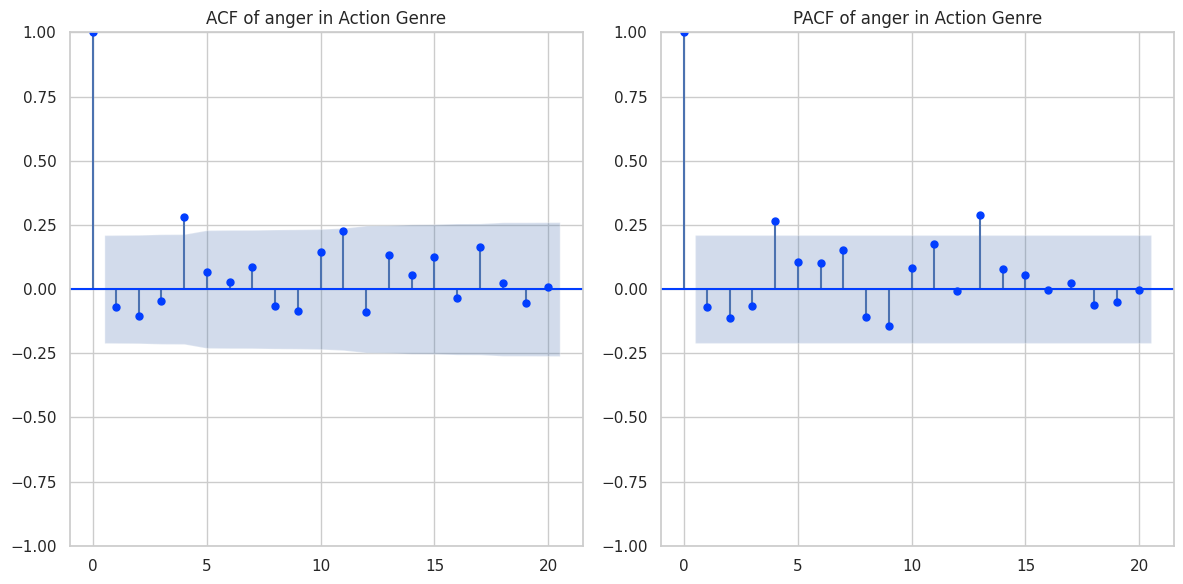

##########################################
 Performing Box-Jenkins Procedure for anger in Action Genre
ADF Statistic: -1.7887471533083943
p-value: 0.38606255732366024
The series is not stationary and needs to be differenced.
Best ARIMA Order for anger in Action Genre: (3, 1, 1)


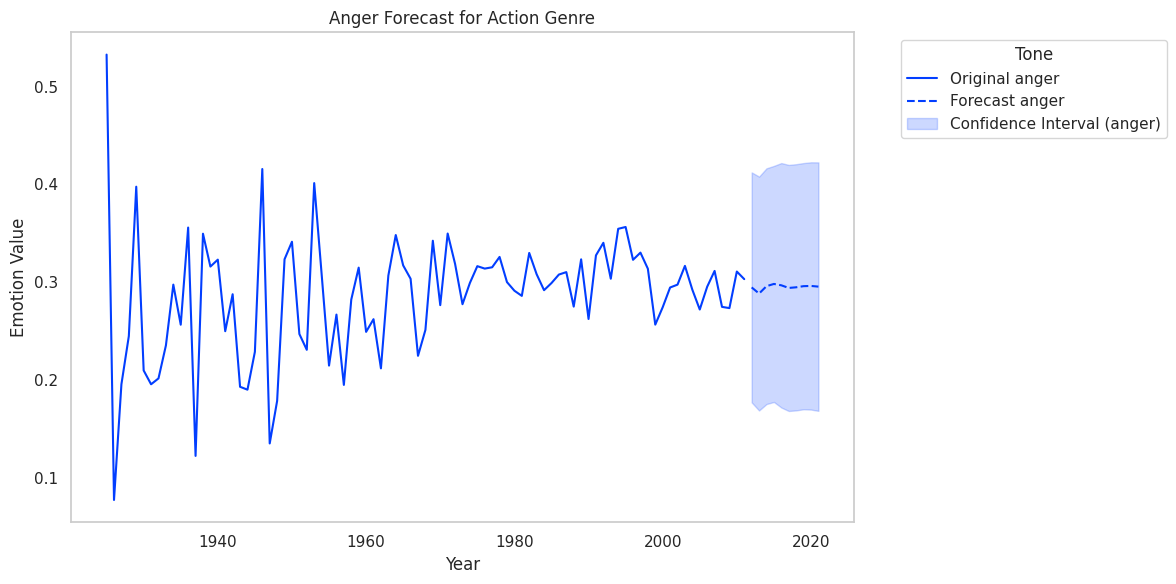

In [34]:
timeseries_plots(action_df, "Action")
action_ts_results = box_jenkins_procedure(action_df, "Action")
action_forecast_df = forecast_series(action_df, "Action", action_ts_results)

In [66]:
action_ts_results['anger'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  anger   No. Observations:                   87
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 118.441
Date:                Fri, 20 Dec 2024   AIC                           -226.881
Time:                        16:09:33   BIC                           -214.609
Sample:                             0   HQIC                          -221.942
                                 - 87                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3399      0.102     -3.323      0.001      -0.540      -0.139
ar.L2         -0.3464      0.111     -3.117      0.002      -0.564      -0.129
ar.L3         -0.3168      0.115     -2.757      0.006      -0.542      -0.092
ma.L1         -0.8444      0.099     -8.502      0.000      -1.039      -0.650
sigma2         0.0036      0.000      7.486      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   3.75   Jarque-Bera (JB):                92.99
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Comedy movies Time Series Analysis

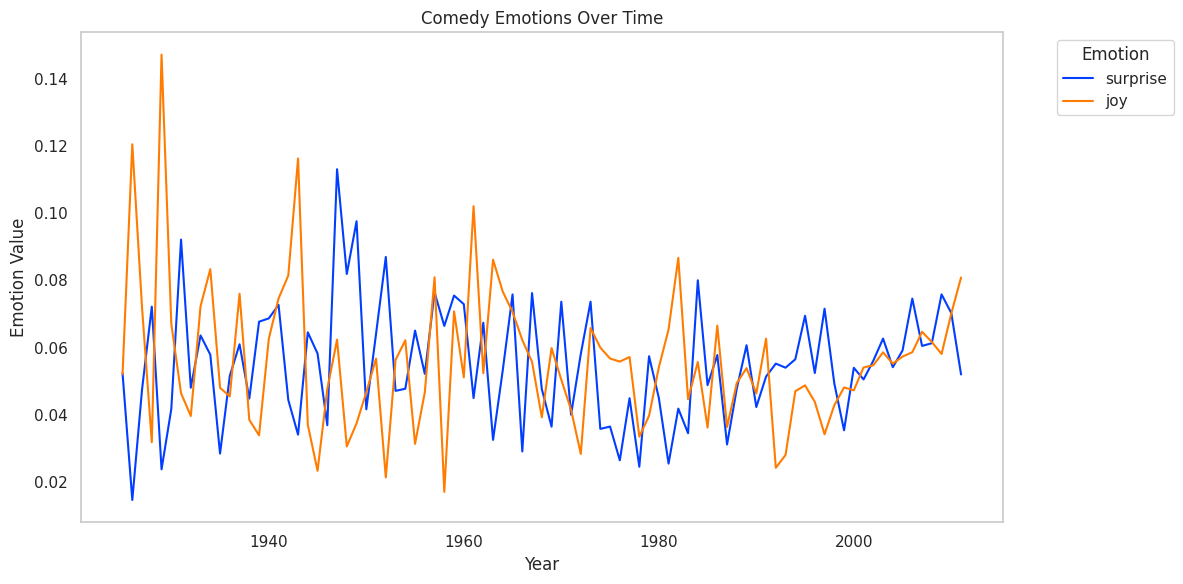

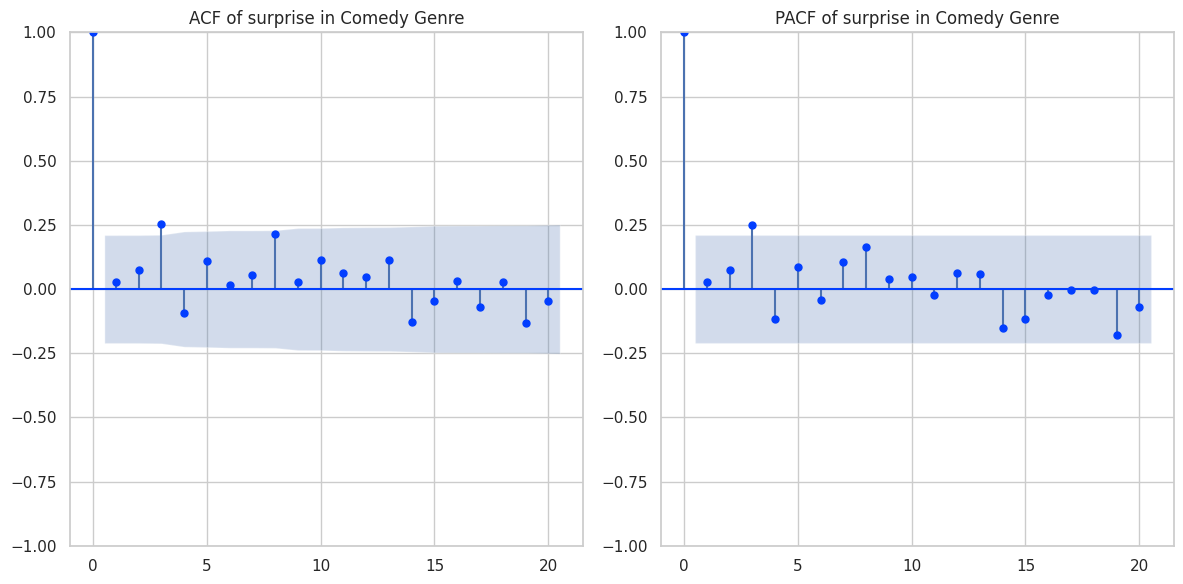

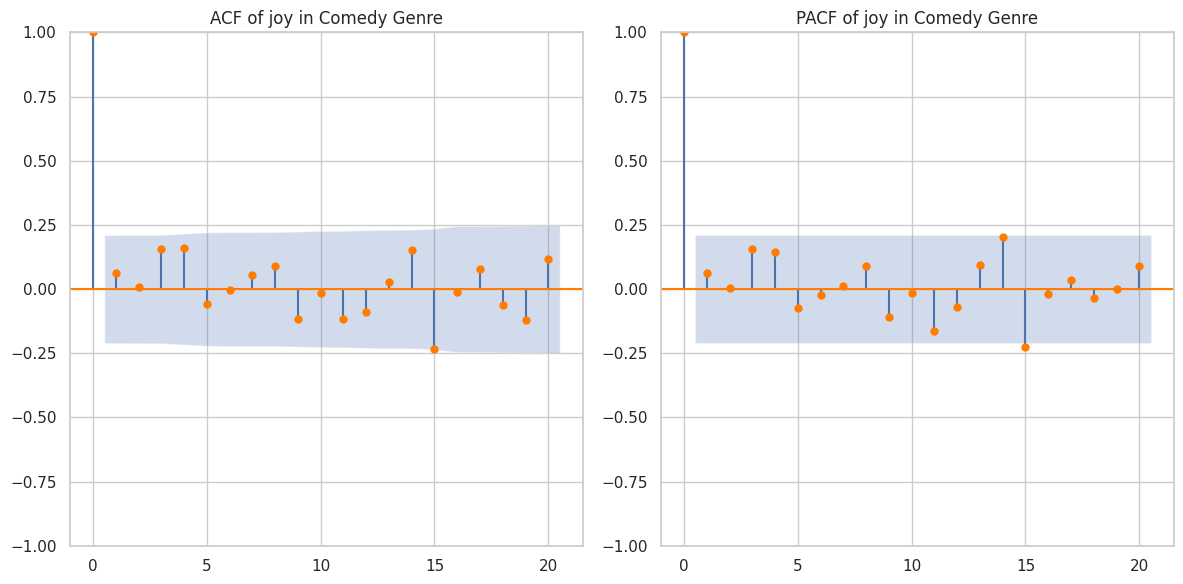

##########################################
 Performing Box-Jenkins Procedure for surprise in Comedy Genre
ADF Statistic: -3.8855435796211175
p-value: 0.002143852219967937
Best ARIMA Order for surprise in Comedy Genre: (3, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Comedy Genre
ADF Statistic: -8.547913514167504
p-value: 9.393303846545818e-14
Best ARIMA Order for joy in Comedy Genre: (1, 0, 0)


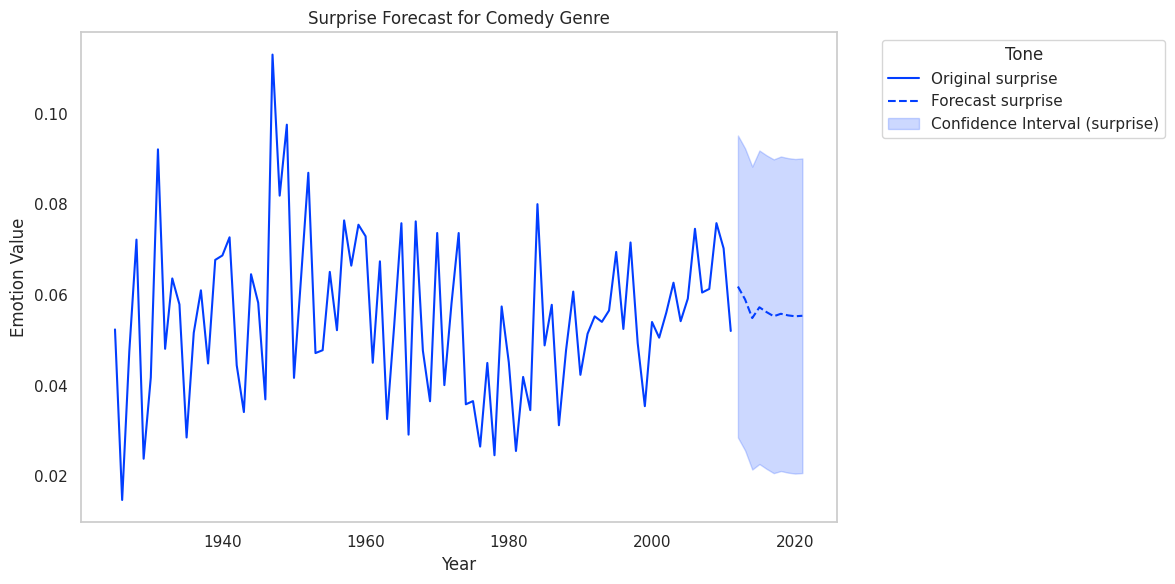

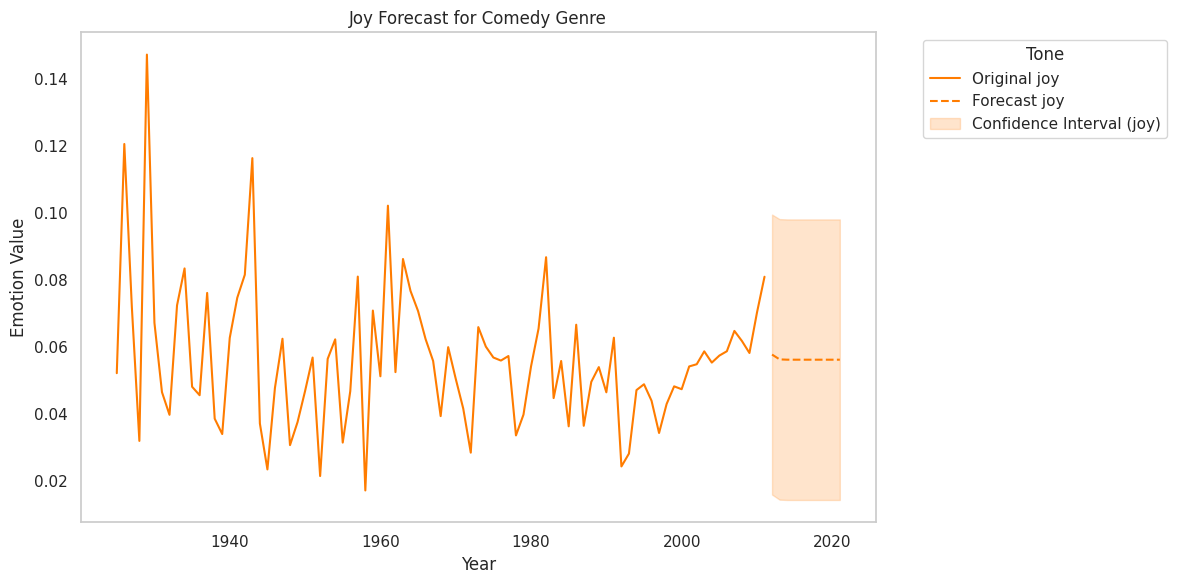

In [35]:
timeseries_plots(comedy_df, "Comedy")
comedy_ts_results = box_jenkins_procedure(comedy_df, "Comedy")
comedy_forecast_df = forecast_series(comedy_df, "Comedy", comedy_ts_results)

#### Crime Fiction movies Time Series Analysis

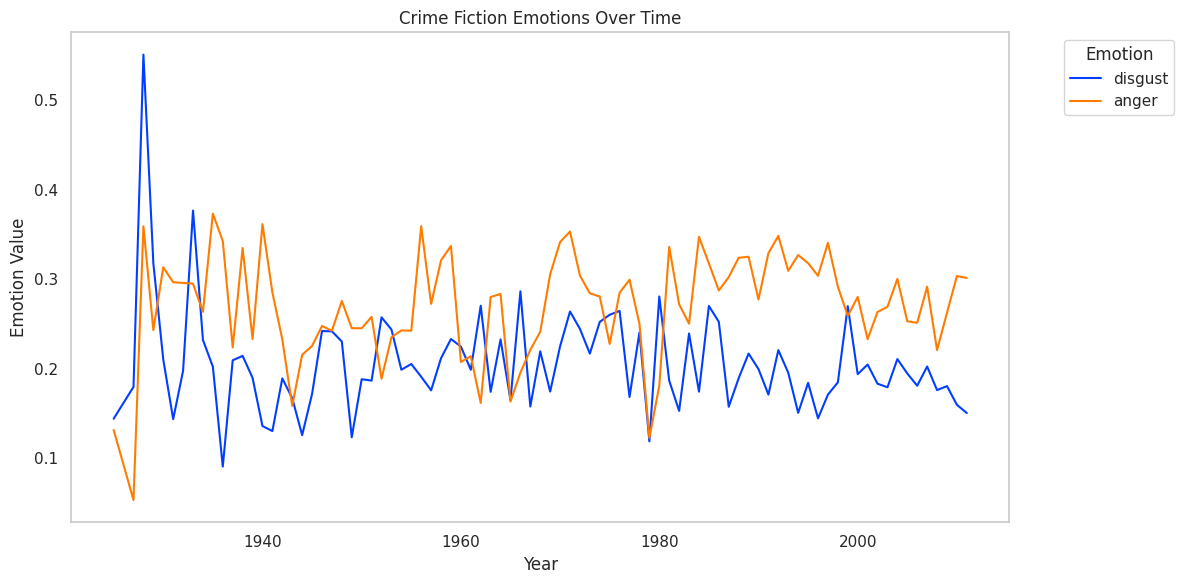

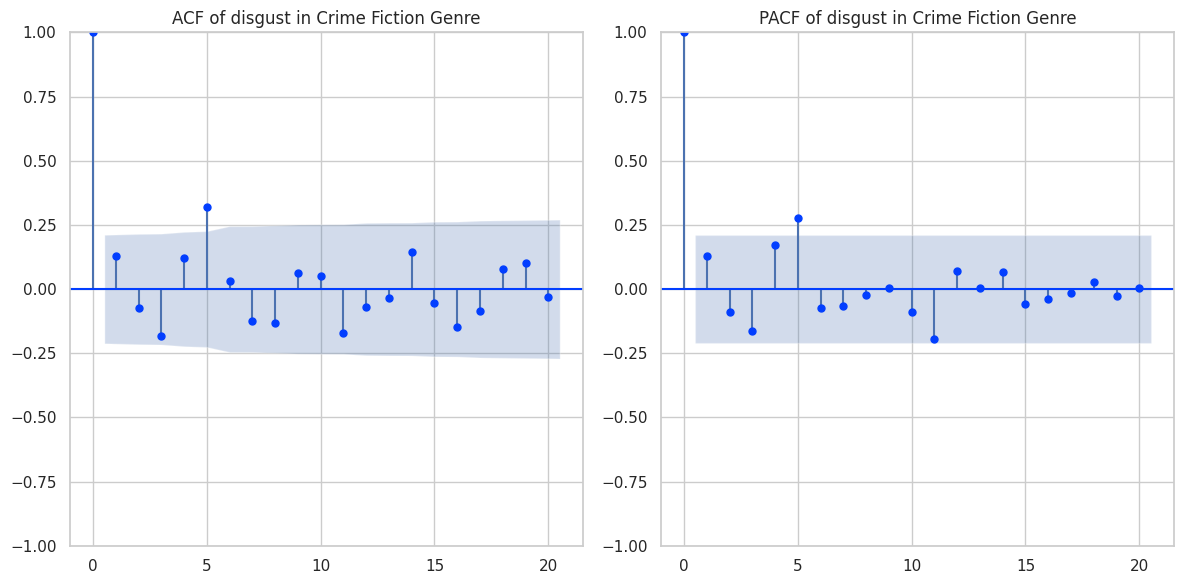

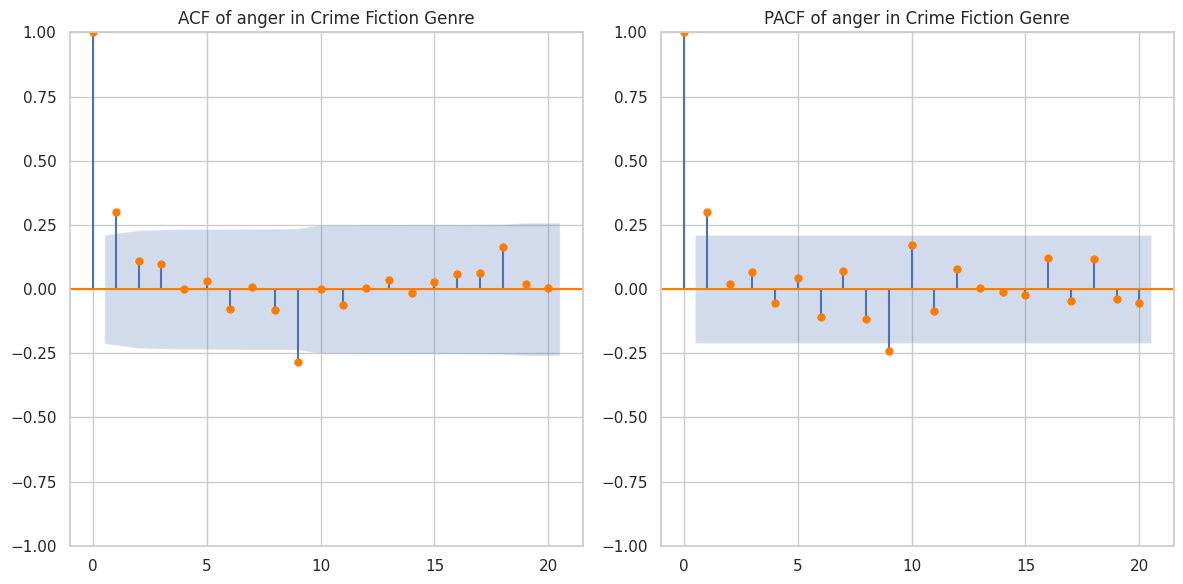

##########################################
 Performing Box-Jenkins Procedure for disgust in Crime Fiction Genre
ADF Statistic: -6.484593942005353
p-value: 1.2701419125844923e-08
Best ARIMA Order for disgust in Crime Fiction Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Crime Fiction Genre
ADF Statistic: -6.914634533444475
p-value: 1.1881064710607695e-09
Best ARIMA Order for anger in Crime Fiction Genre: (1, 0, 0)


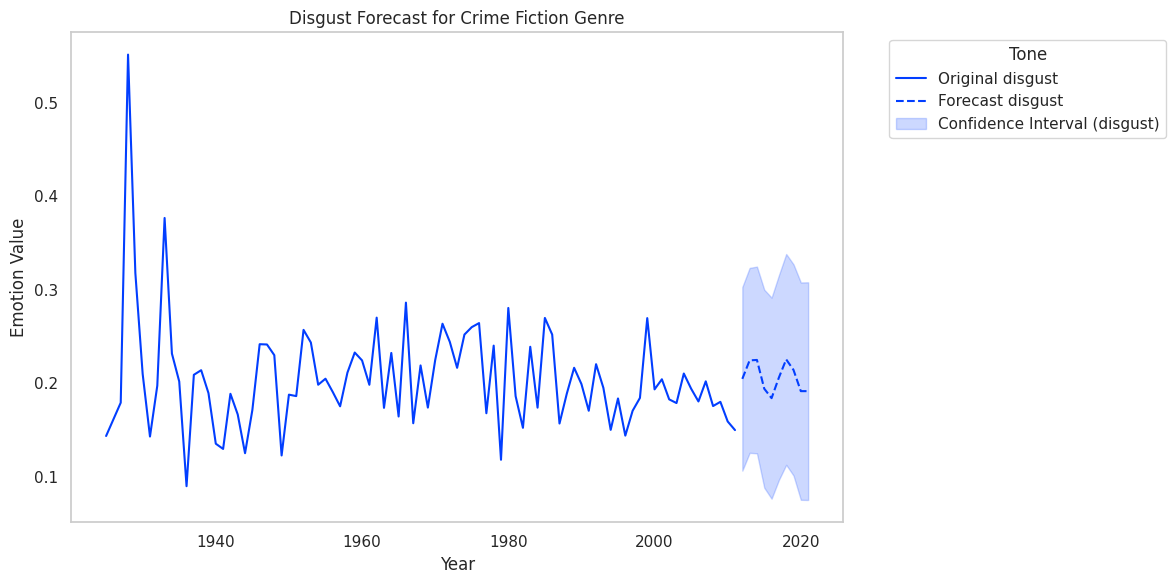

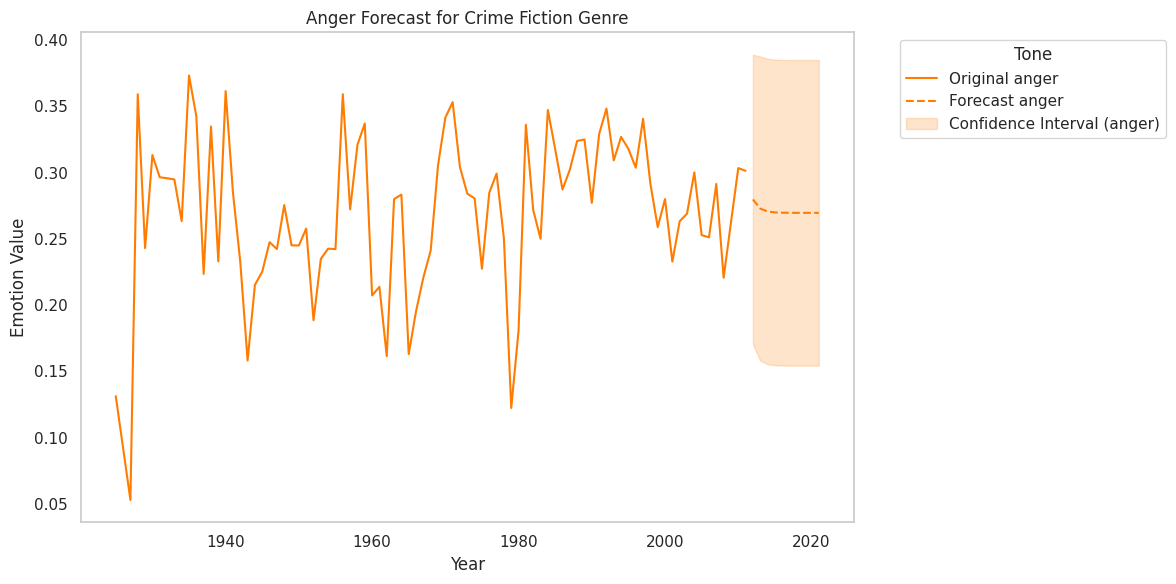

In [36]:
timeseries_plots(crime_fiction_df, "Crime Fiction")
crime_fiction_ts_results = box_jenkins_procedure(crime_fiction_df, "Crime Fiction")
crime_fiction_forecast_df = forecast_series(crime_fiction_df, "Crime Fiction", crime_fiction_ts_results)

#### Drama movies Times Series Analysis

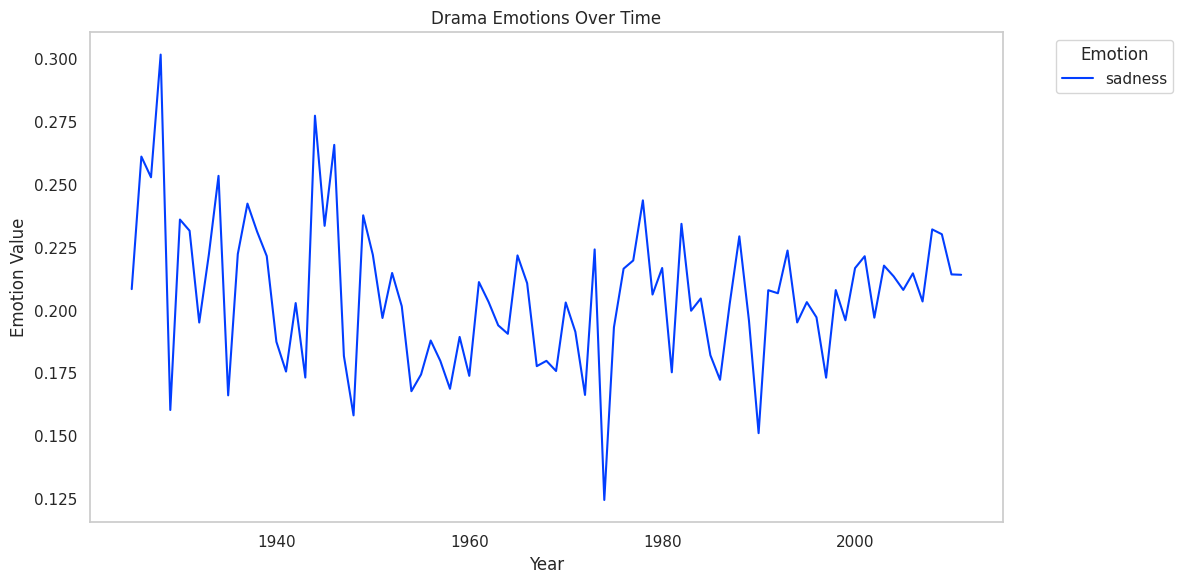

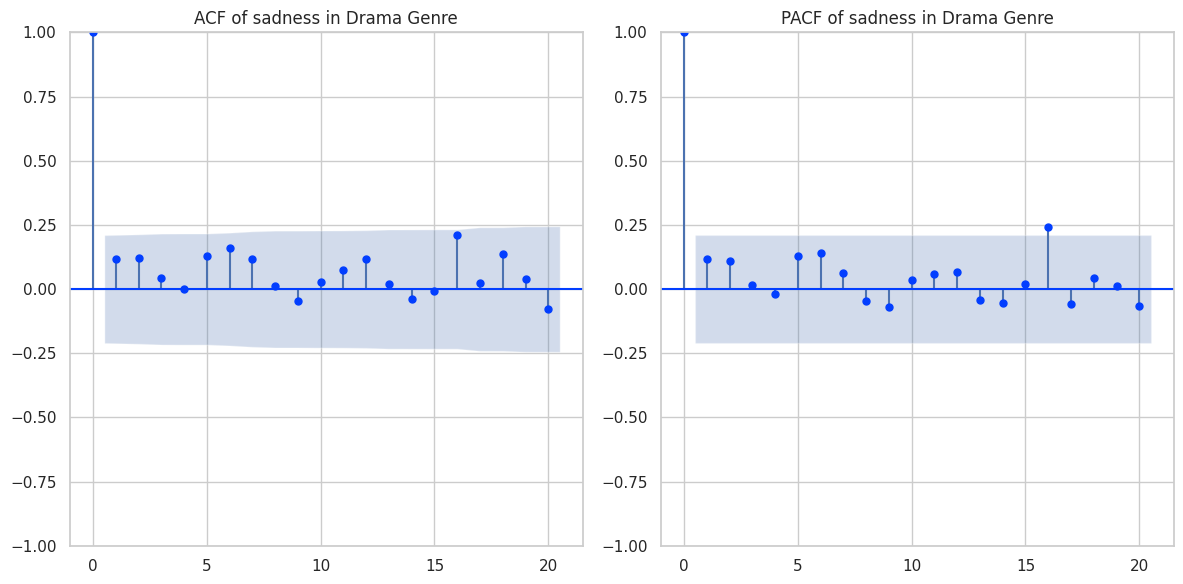

##########################################
 Performing Box-Jenkins Procedure for sadness in Drama Genre
ADF Statistic: -8.131424158962508
p-value: 1.0876387226298188e-12
Best ARIMA Order for sadness in Drama Genre: (1, 0, 1)


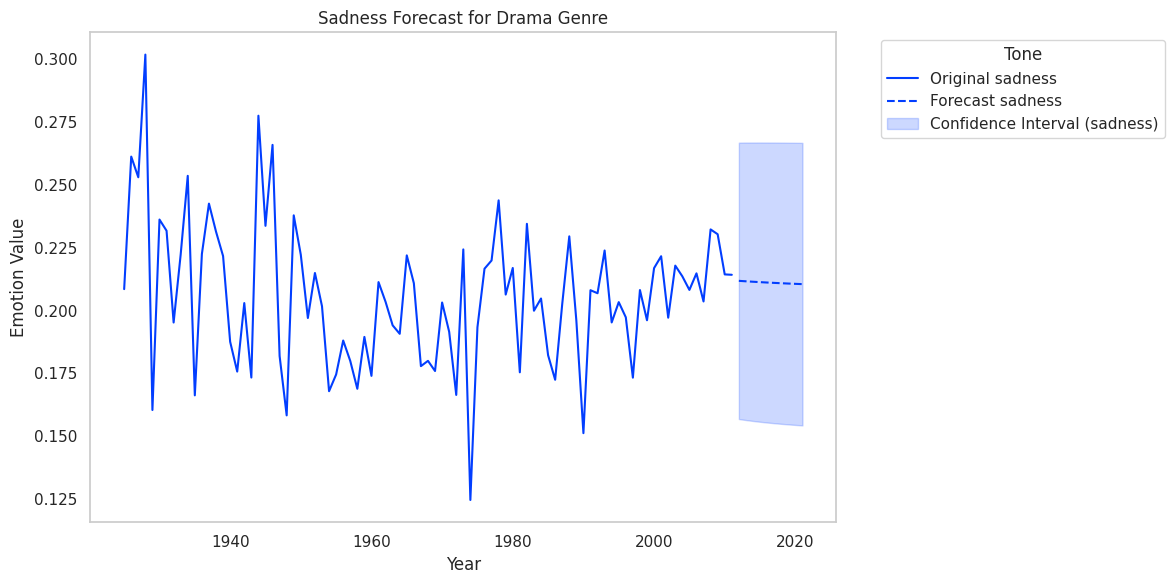

In [37]:
timeseries_plots(drama_df, "Drama")
drama_ts_results = box_jenkins_procedure(drama_df, "Drama")
drama_forecast_df = forecast_series(drama_df, "Drama", drama_ts_results)

#### Family Film movies Time Series Analysis

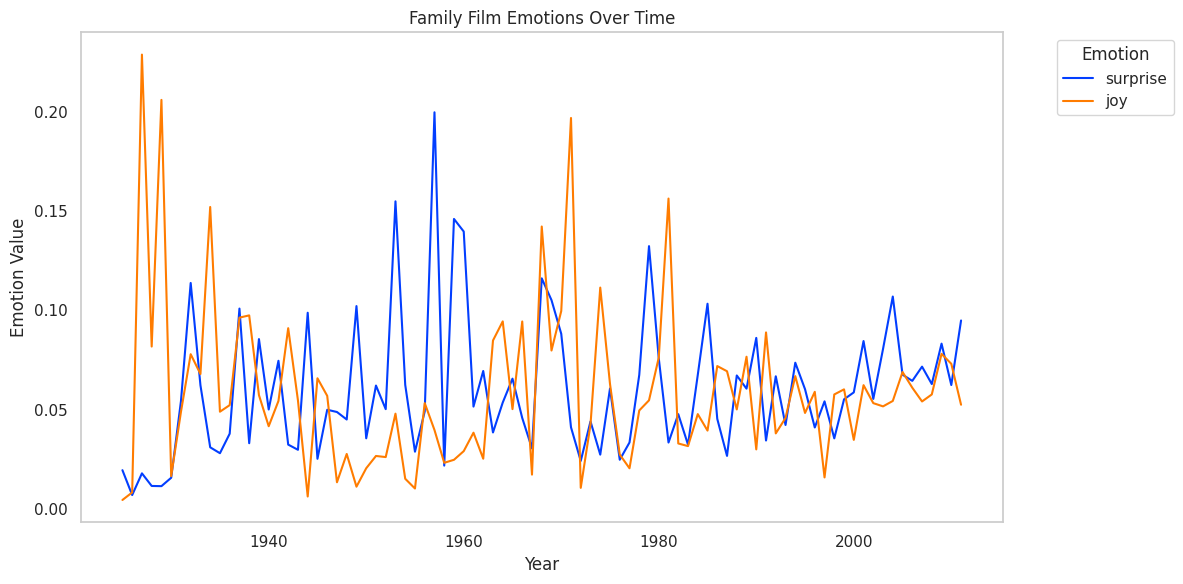

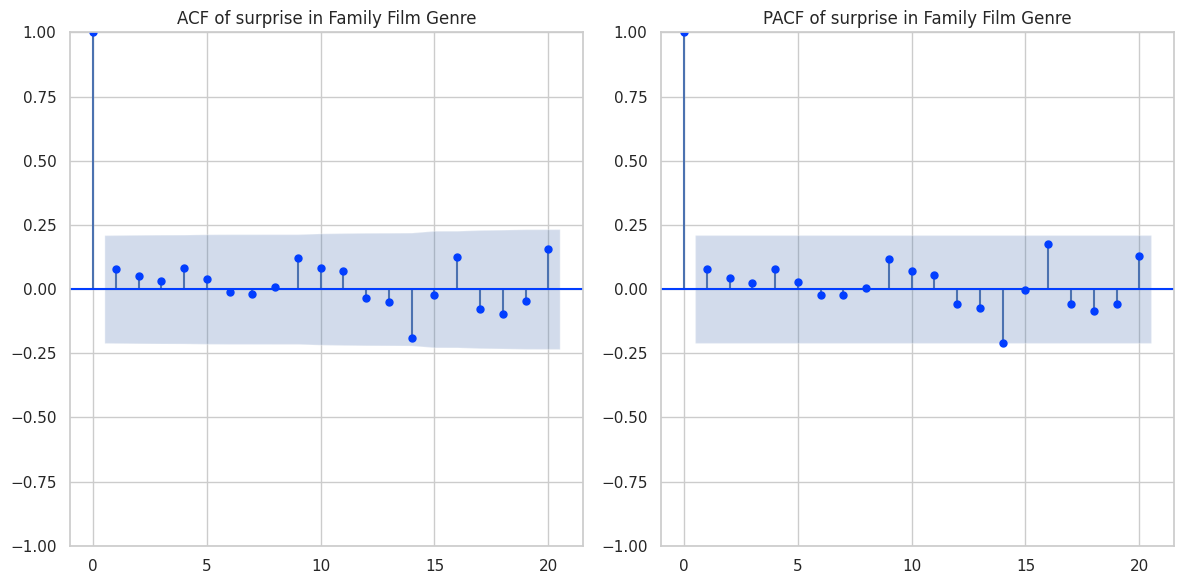

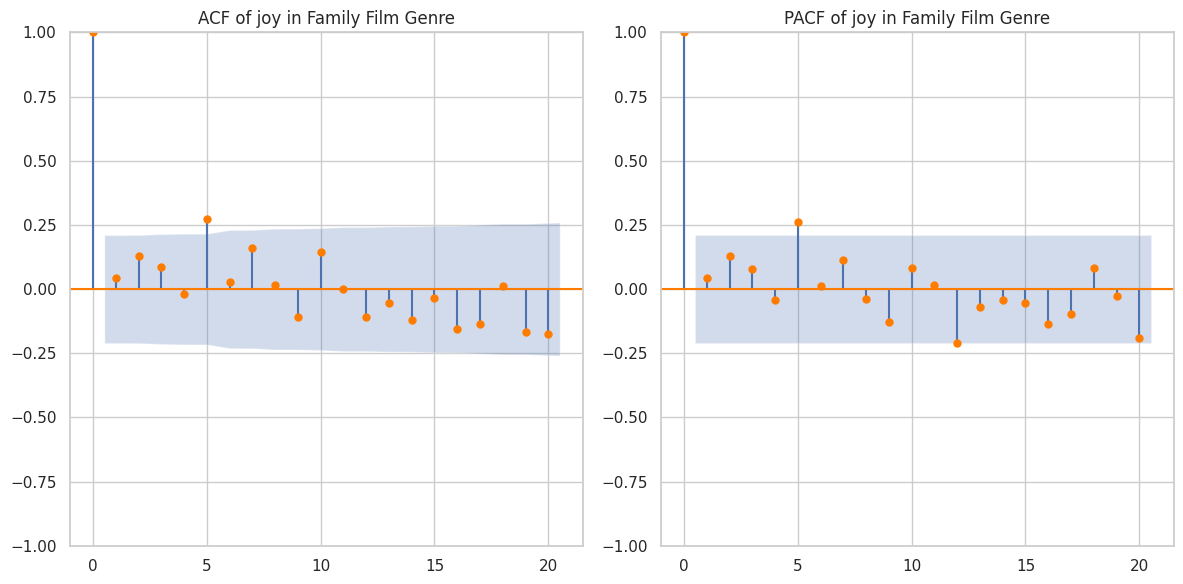

##########################################
 Performing Box-Jenkins Procedure for surprise in Family Film Genre
ADF Statistic: -8.473655078539826
p-value: 1.4548682542497424e-13
Best ARIMA Order for surprise in Family Film Genre: (1, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Family Film Genre
ADF Statistic: -4.269389640840536
p-value: 0.000501669168766257
Best ARIMA Order for joy in Family Film Genre: (3, 0, 1)


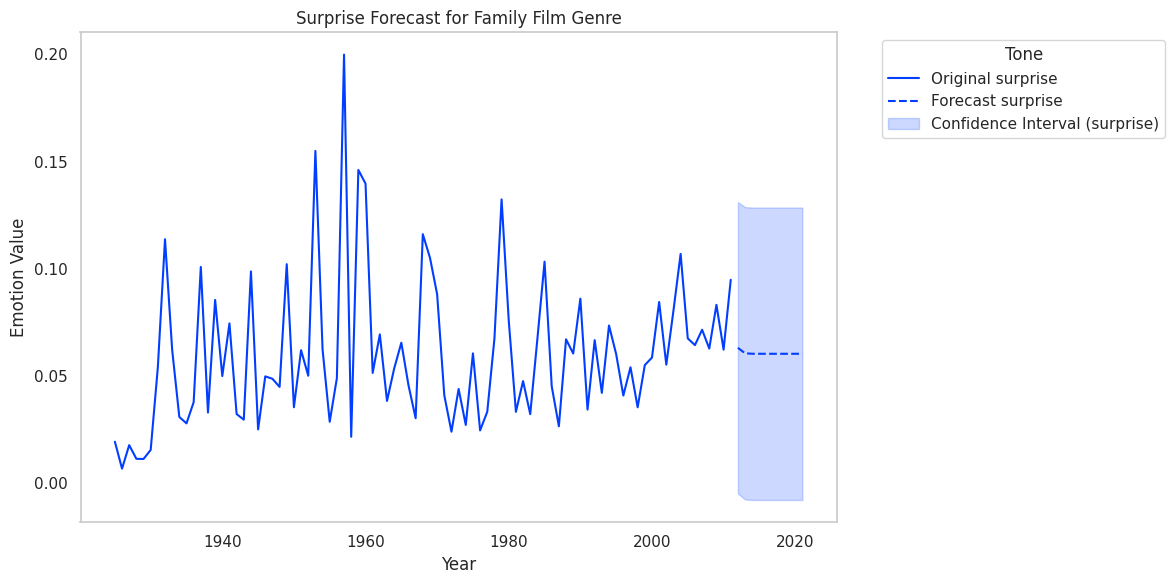

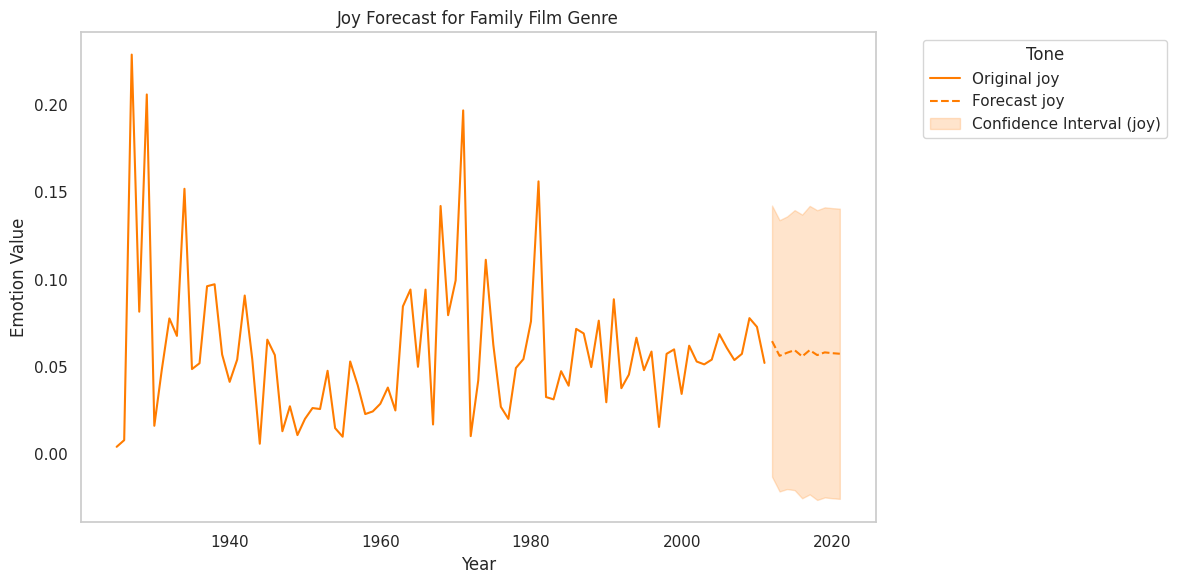

In [38]:
timeseries_plots(family_film_df, "Family Film")
family_ts_results = box_jenkins_procedure(family_film_df, "Family Film")
family_forecast_df = forecast_series(family_film_df, "Family Film", family_ts_results)

#### Horror movies Times Series Analysis

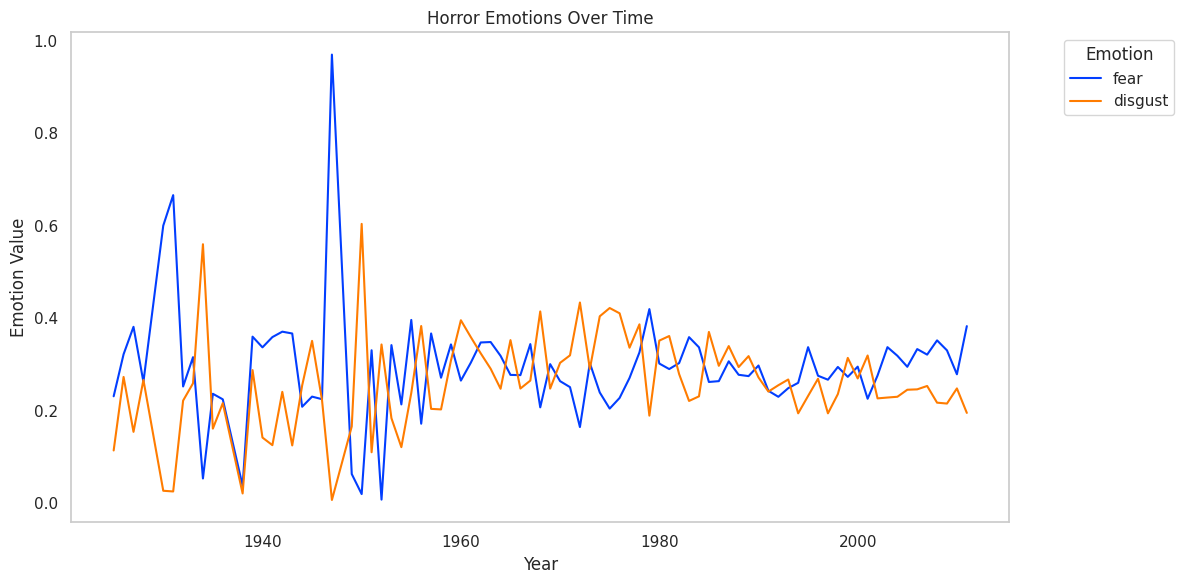

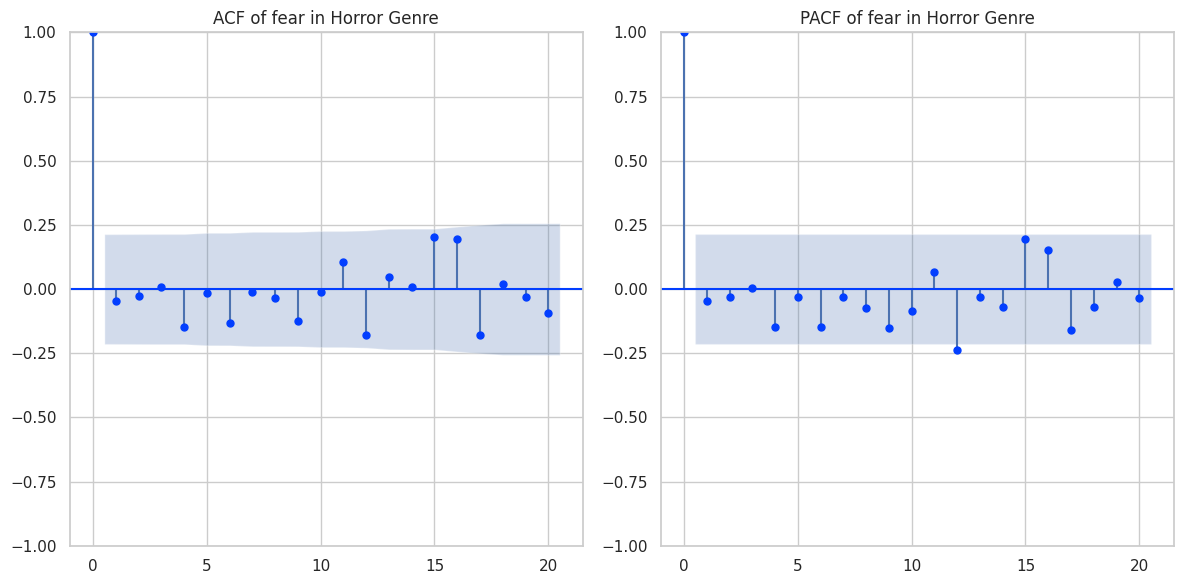

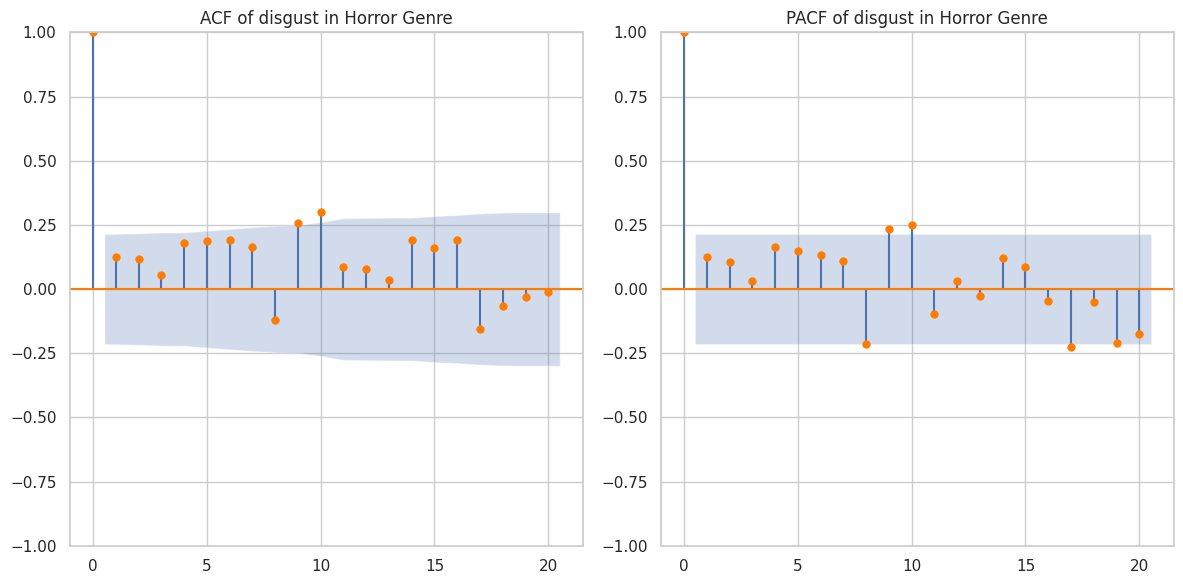

##########################################
 Performing Box-Jenkins Procedure for fear in Horror Genre
ADF Statistic: -9.4282225003187
p-value: 5.275646181909373e-16
Best ARIMA Order for fear in Horror Genre: (1, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in Horror Genre
ADF Statistic: -1.0727583574924413
p-value: 0.7258124187609406
The series is not stationary and needs to be differenced.
Best ARIMA Order for disgust in Horror Genre: (1, 1, 1)


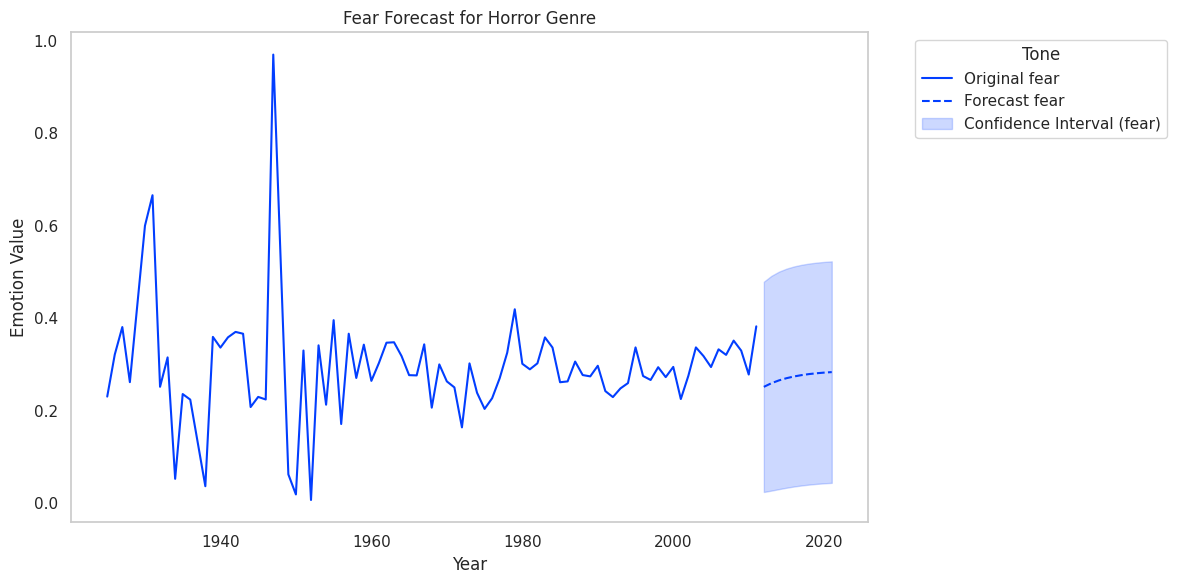

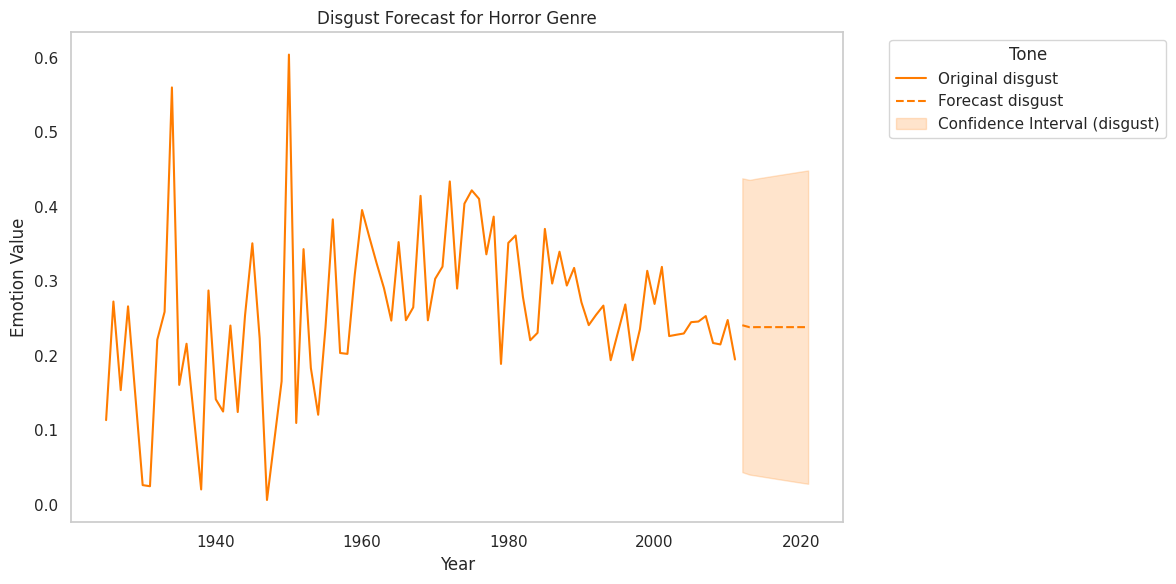

In [39]:
timeseries_plots(horror_df, "Horror")
horror_ts_results = box_jenkins_procedure(horror_df, "Horror")
horror_forecast_df = forecast_series(horror_df, "Horror", horror_ts_results)

#### Indie movies Time Series Analysis

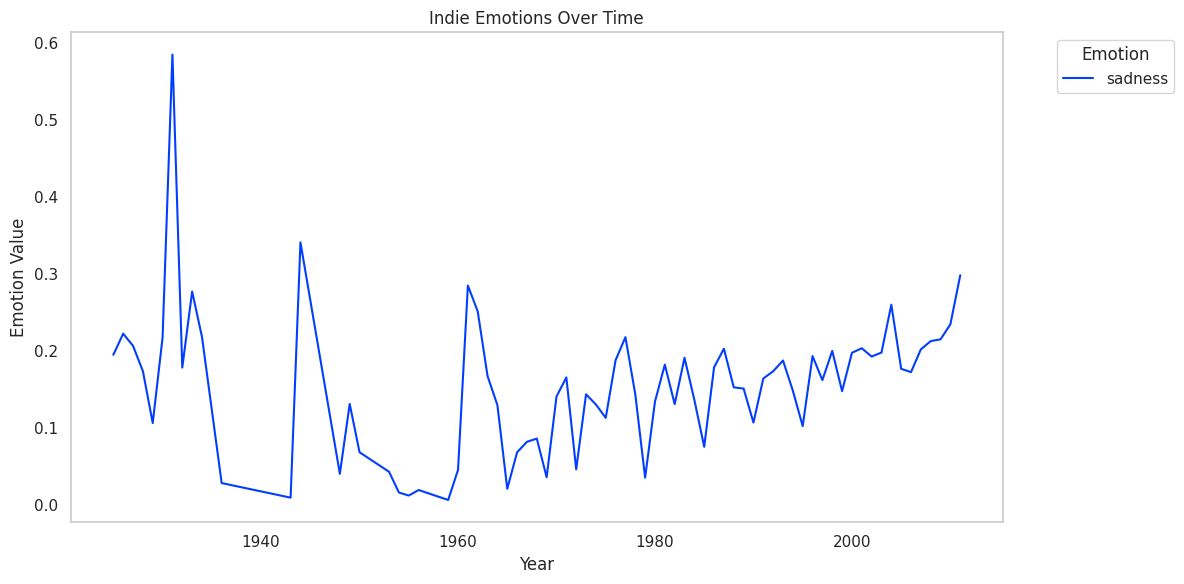

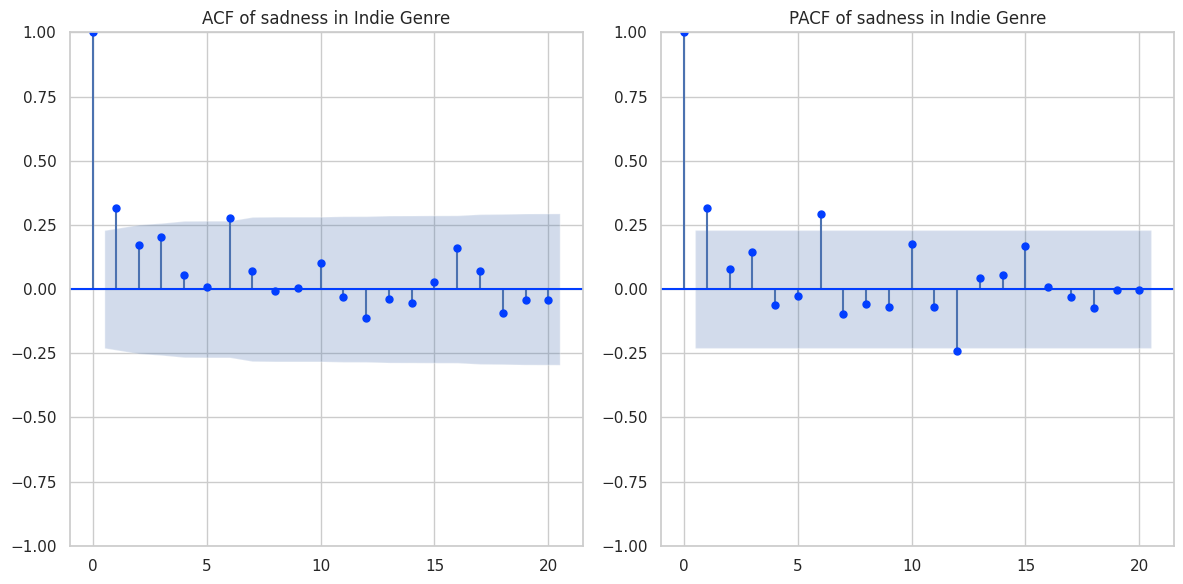

##########################################
 Performing Box-Jenkins Procedure for sadness in Indie Genre
ADF Statistic: -4.290242861905465
p-value: 0.00046181560314714716
Best ARIMA Order for sadness in Indie Genre: (3, 0, 2)


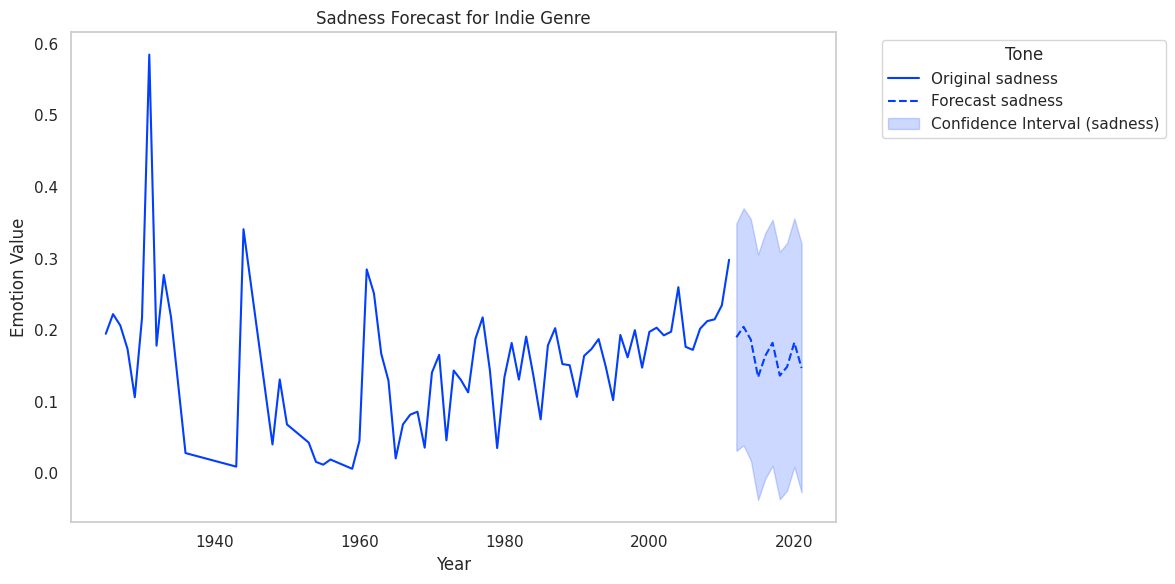

In [40]:
timeseries_plots(indie_df, "Indie")
indie_ts_results = box_jenkins_procedure(indie_df, "Indie")
indie_forecast_df = forecast_series(indie_df, "Indie", indie_ts_results)

#### Romance movies Time Series Analysis

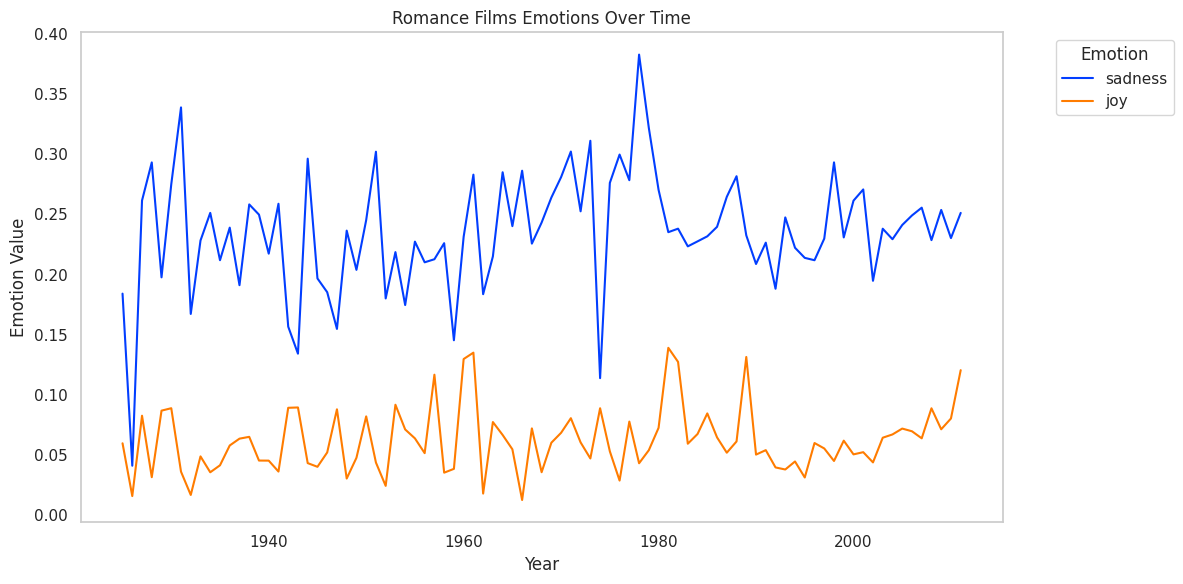

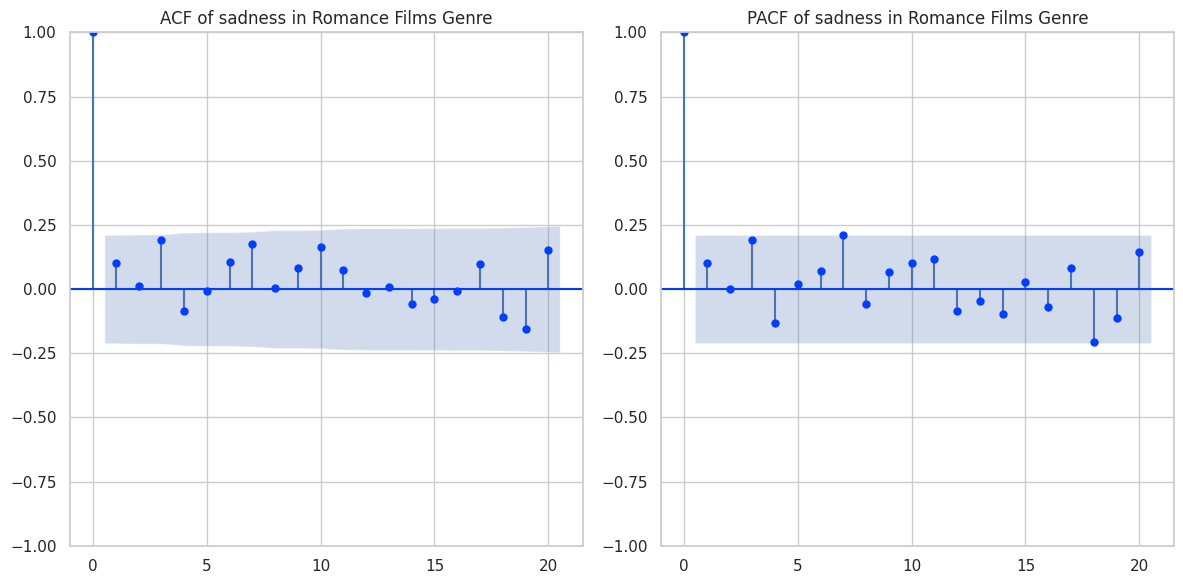

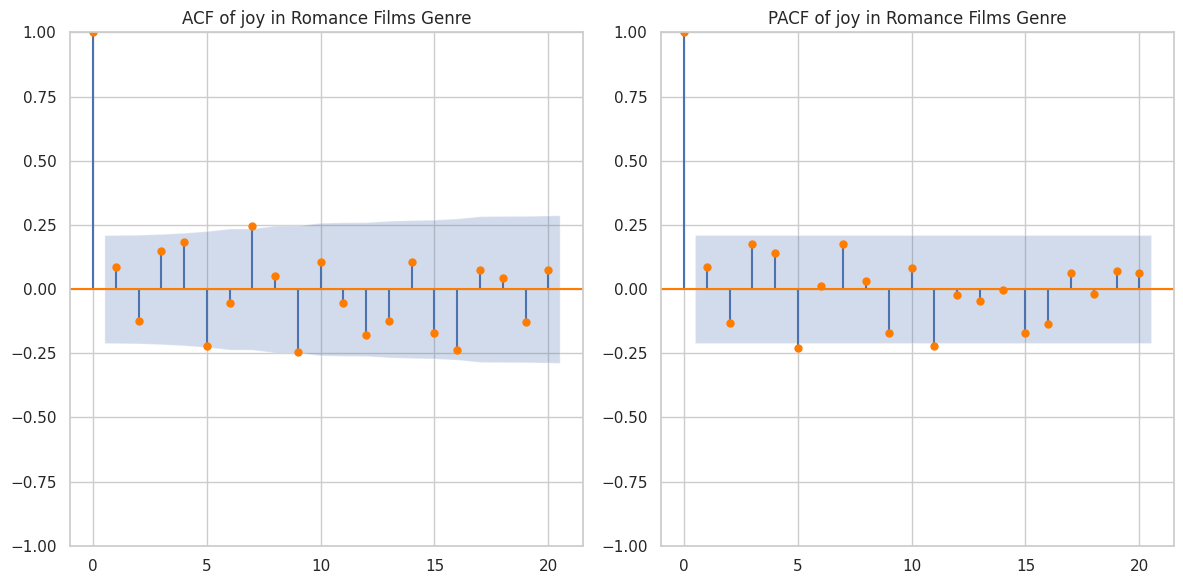

##########################################
 Performing Box-Jenkins Procedure for sadness in Romance Film Genre
ADF Statistic: -8.329339184936085
p-value: 3.401902104800243e-13
Best ARIMA Order for sadness in Romance Film Genre: (1, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for joy in Romance Film Genre
ADF Statistic: -2.8643682243500903
p-value: 0.04965115747924062
Best ARIMA Order for joy in Romance Film Genre: (2, 0, 2)


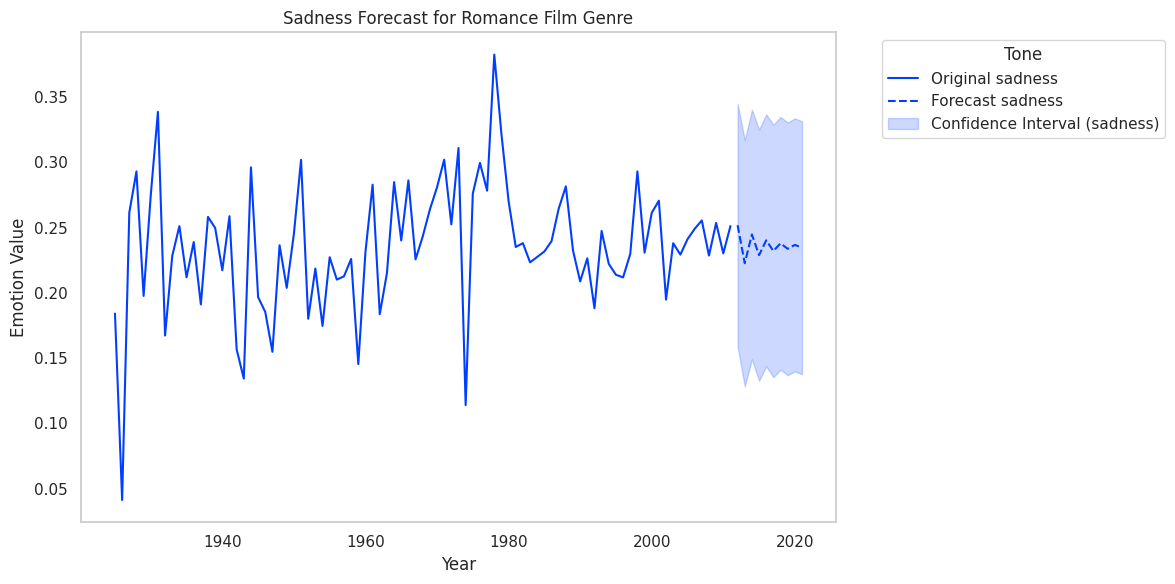

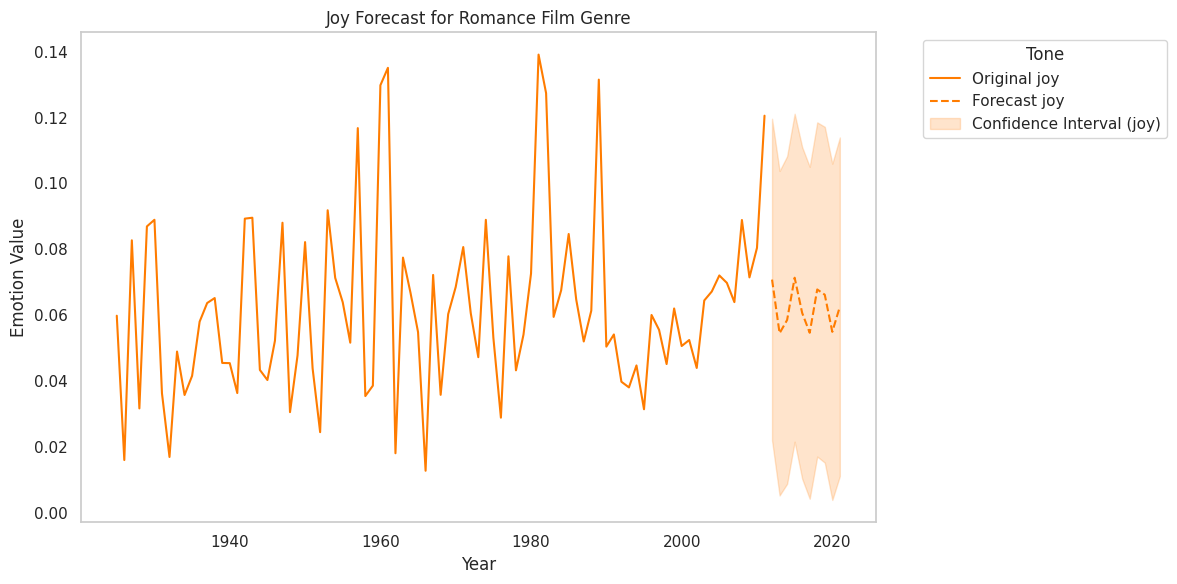

In [41]:
timeseries_plots(romance_film_df, "Romance Films")
romance_ts_results = box_jenkins_procedure(romance_film_df, "Romance Film")
romance_forecast_df = forecast_series(romance_film_df, "Romance Film", romance_ts_results)

#### Thriller movies Time Series Analysis

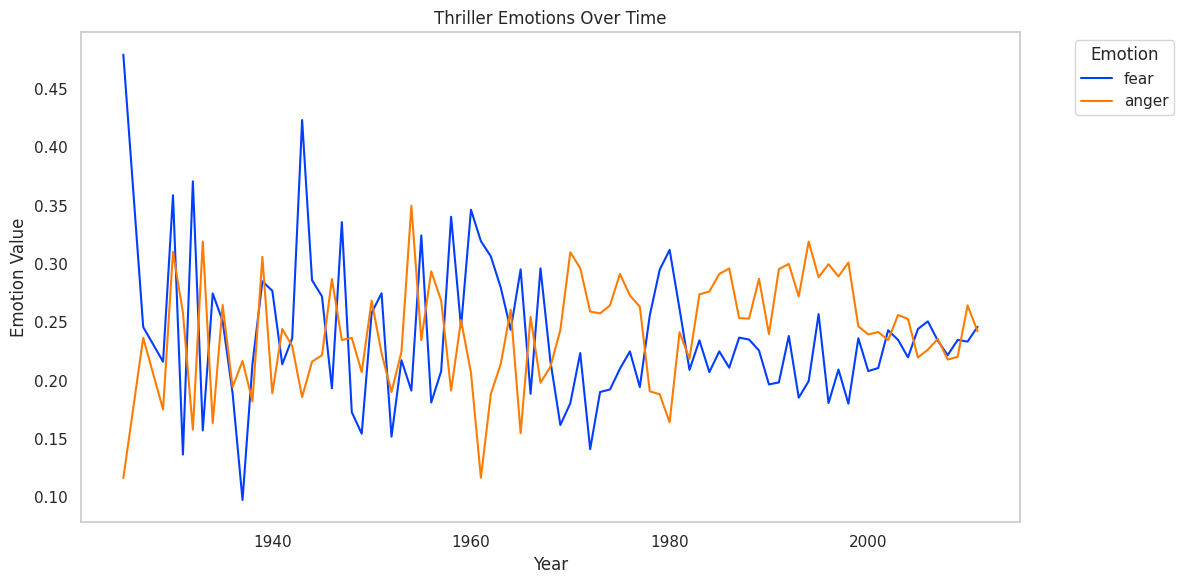

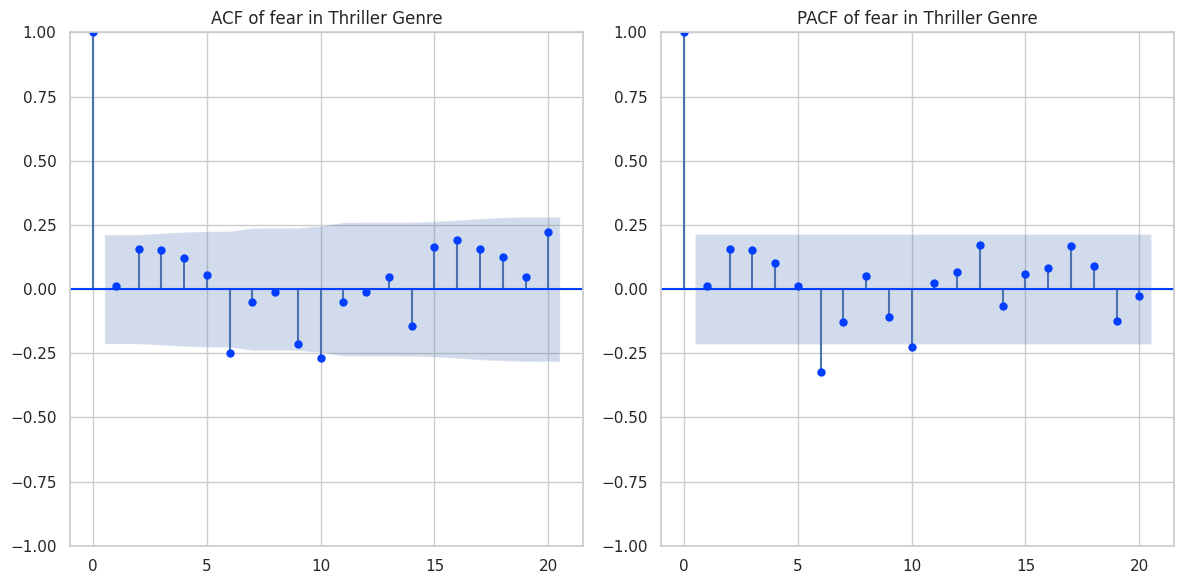

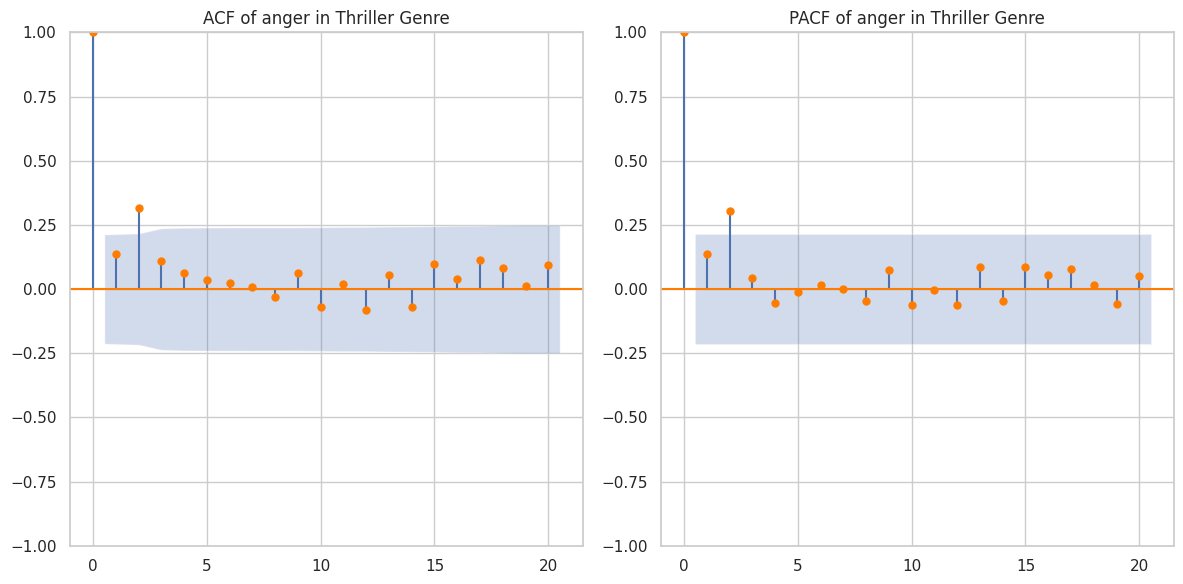

##########################################
 Performing Box-Jenkins Procedure for fear in Thriller Genre
ADF Statistic: -4.3806491333538276
p-value: 0.00032113466060936446
Best ARIMA Order for fear in Thriller Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Thriller Genre
ADF Statistic: -4.398199262173892
p-value: 0.00029901836591140053
Best ARIMA Order for anger in Thriller Genre: (2, 0, 0)


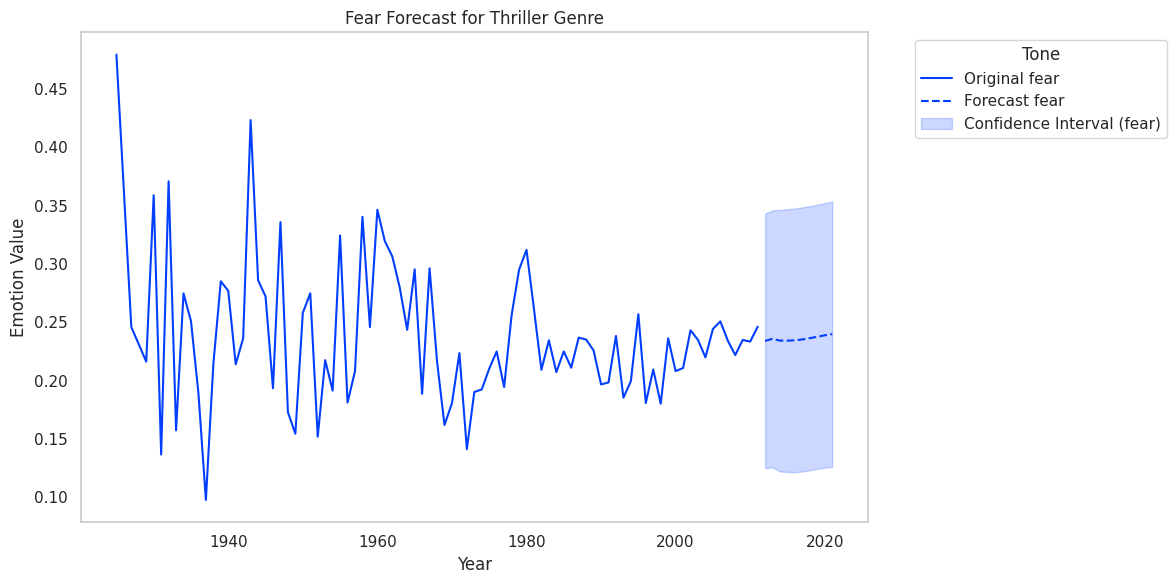

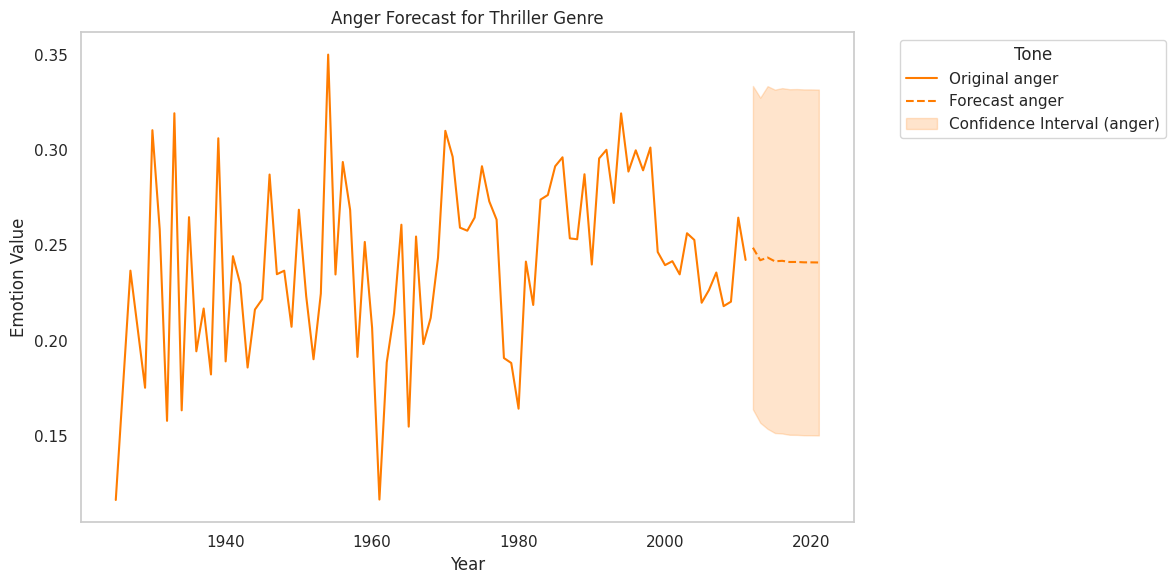

In [42]:
timeseries_plots(thriller_df, "Thriller")
thriller_ts_results = box_jenkins_procedure(thriller_df, "Thriller")
thriller_forecast_df = forecast_series(thriller_df, "Thriller", thriller_ts_results)

#### World Cinema movies Time Series Analysis

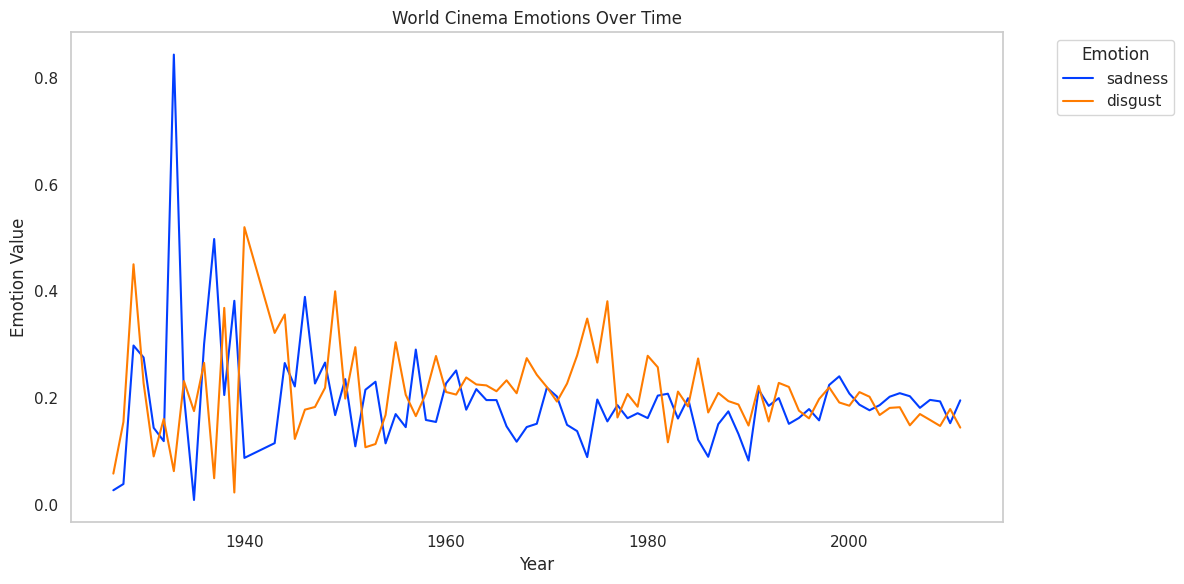

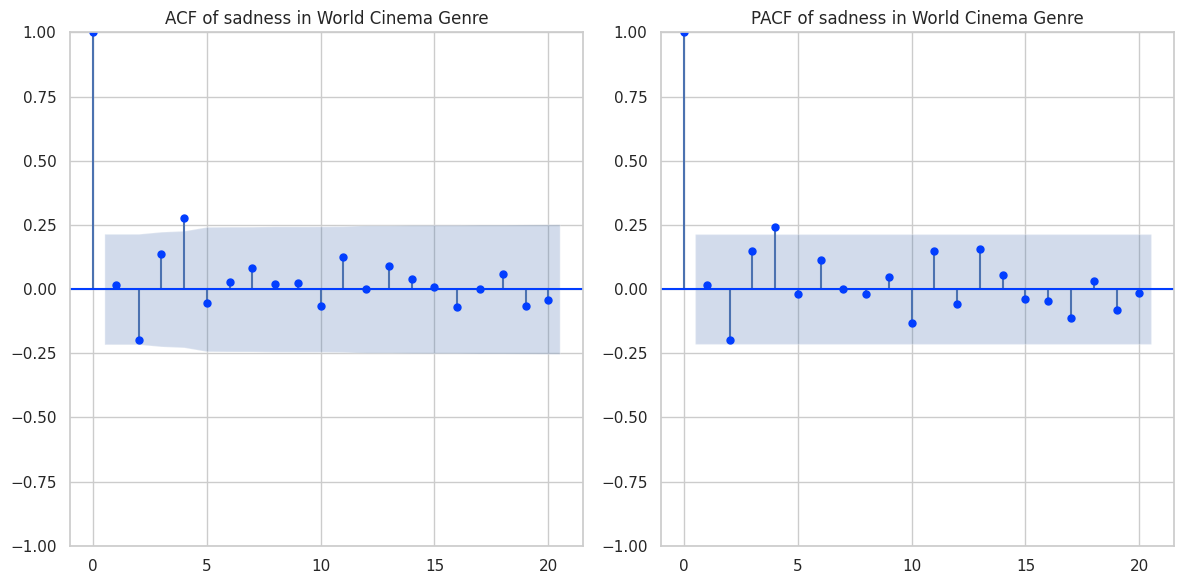

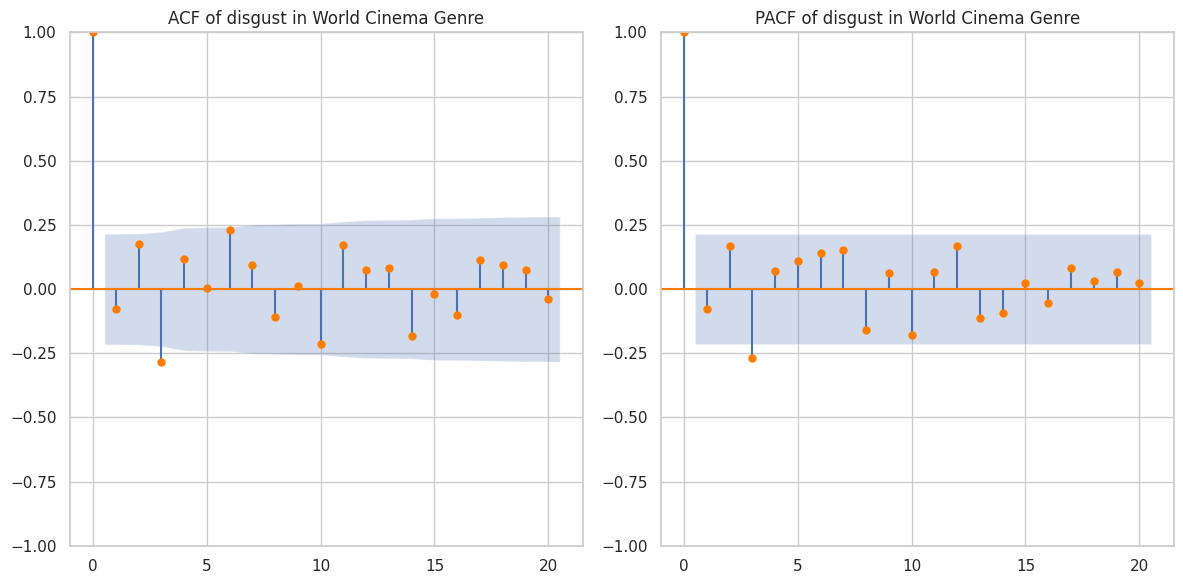

##########################################
 Performing Box-Jenkins Procedure for sadness in World Cinema Genre
ADF Statistic: -3.6754907309791105
p-value: 0.004471408710045445
Best ARIMA Order for sadness in World Cinema Genre: (3, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in World Cinema Genre
ADF Statistic: -5.9586839393377184
p-value: 2.0637716996936004e-07
Best ARIMA Order for disgust in World Cinema Genre: (3, 0, 0)


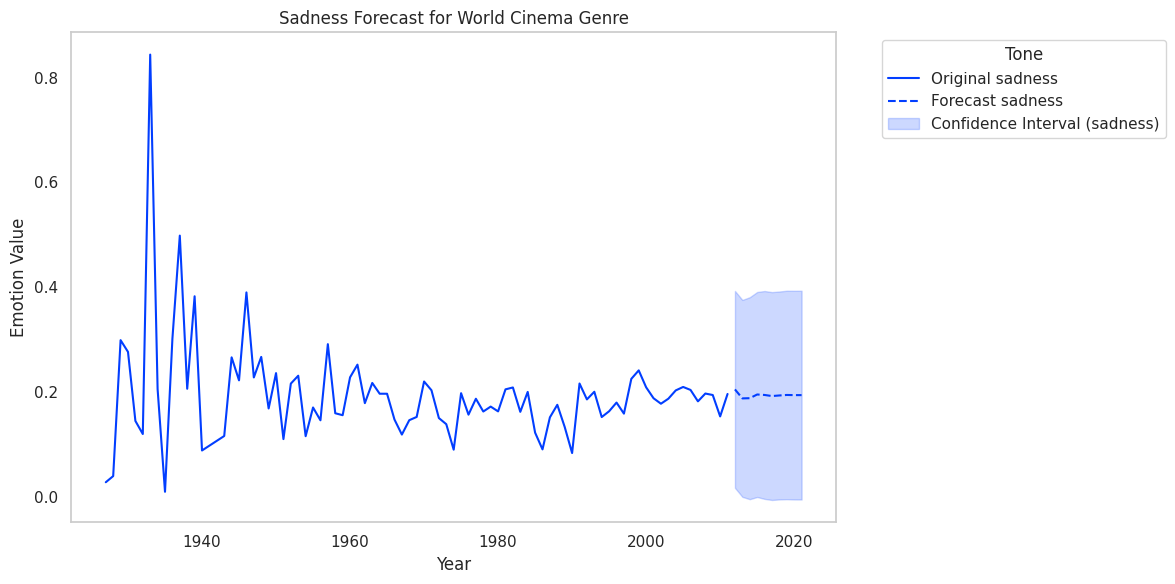

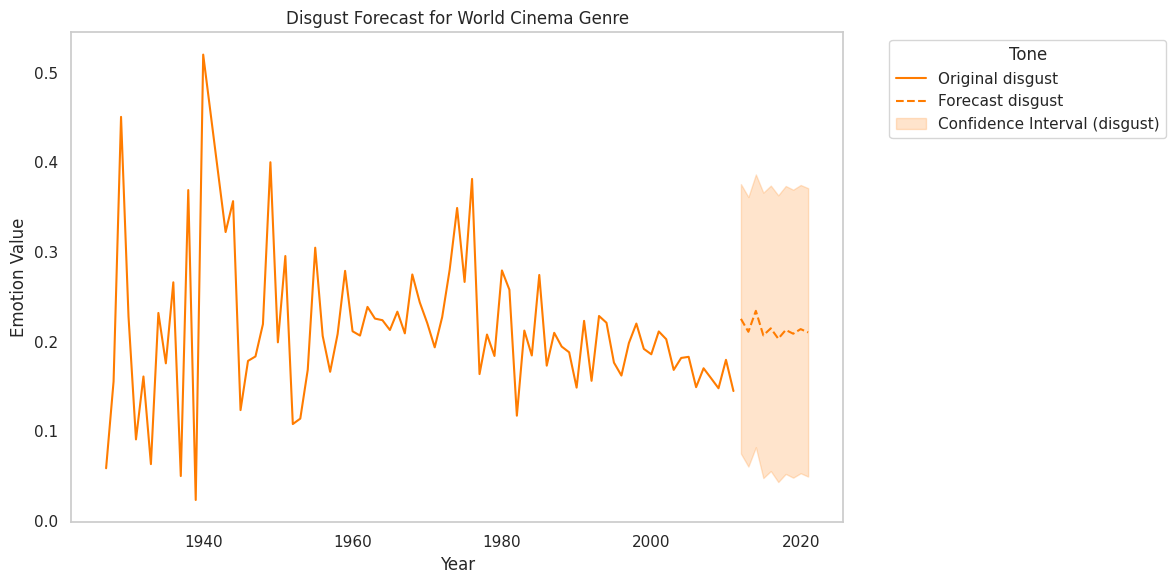

In [43]:
timeseries_plots(world_cinema_df, "World Cinema")
world_ts_results = box_jenkins_procedure(world_cinema_df, "World Cinema")
world_forecast_df = forecast_series(world_cinema_df, "World Cinema", world_ts_results)


## Interpretation of Results: Time Series Analysis and Forecasting Example

### Example: The Evolution of "Anger" in Action Movies

The emotion **"anger"** in Action movies was modeled using an **ARIMA(3, 1, 1)** configuration.

### Formula for Predicting "Anger" Emotion

The ARIMA(3, 1, 1) model is represented as:

1. **Differenced Series**: The first differencing order ($d = 1$) transforms the original series, $X_t$, into:
   $$
   Y_t = X_t - X_{t-1}
   $$

2. **ARIMA Model Equation**:
   $$
   Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \phi_3 Y_{t-3} + \theta_1 \epsilon_{t-1} + \epsilon_t
   $$
   Where:
   - $\phi_1, \phi_2, \phi_3$: Coefficients for lagged values ($Y_{t-1}, Y_{t-2}, Y_{t-3}$).
   - $\theta_1$: Coefficient for the moving average term ($\epsilon_{t-1}$).
   - $\epsilon_t$: Residual error term at time $t$.

   Substituting the coefficients:
   $$
   Y_t = -0.3399 Y_{t-1} - 0.3464 Y_{t-2} - 0.3168 Y_{t-3} - 0.8444 \epsilon_{t-1} + \epsilon_t
   $$

3. **Reconstruction**: The original series $X_t$ is obtained by summing the differenced value $Y_t$ with $X_{t-1}$:
   $$
   X_t = X_{t-1} + Y_t
   $$

---

### Forecasting 10 Years into the Future

Forecasting is achieved mathematically by iterating the ARIMA equation forward in time. Here's how it works:

1. **Extrapolate the Differenced Series ($Y_t$)**:
   - Use the ARIMA equation:
     $$
     Y_t = -0.3399 Y_{t-1} - 0.3464 Y_{t-2} - 0.3168 Y_{t-3} - 0.8444 \epsilon_{t-1} + \epsilon_t
     $$
   - For future values, the residual error terms ($\epsilon_t$) are assumed to follow a white noise distribution (mean = 0, constant variance).

2. **Iterative Prediction**:
   - Start with the most recent observed values of $Y_t$, $Y_{t-1}$, $Y_{t-2}$, and $\epsilon_{t-1}$.
   - Predict $Y_t+1$, then use it to predict $Y_t+2$, and so on.

3. **Reconstruct the Original Series ($X_t$)**:
   - Each forecasted value of $Y_t$ is added cumulatively to the last known value of $X_t$:
     $$
     X_{t+1} = X_t + Y_{t+1}
     $$
     $$
     X_{t+2} = X_{t+1} + Y_{t+2}
     $$

By iterating this process for 10 steps, we generated predictions for the next 10 years of "anger" scores in Action movies.

---

### Interpretation of the Forecast

From the model:
- The **AR(3)** component suggests that the emotion "anger" is heavily influenced by its values up to three years prior.
- The **MA(1)** component accounts for short-term shocks, smoothing out noise in the predictions.
- The **differencing** captures the long-term trend, ensuring the model predicts a stationary evolution of "anger" over time.

The forecast provides a statistically sound projection of how "anger" might continue to evolve in Action movies, with confidence intervals capturing the uncertainty around the predictions.

Very interesting! Let's now look if there is a connection between the emotional tone of a movie and the components of the movie like its language or the actor traits of involved actors. First we will look at the question:



# How Does the Emotional Tone of Films Influence the Selection of Actor Traits, Such as Age and Gender?

#### To investigate the relationship between the emotional tone of films and the selection of actor traits, specifically **average age** and **gender proportion** of involved actors, we performed a regression analysis.


In [44]:
# Prepare the data for analysis
# Filter for columns needed for the analysis
character_df = df[['WikiID', 'merge_year', 'Genres', 'distilbert_emotions', 'ActorAge', 'ActorGender', 'ActorBirthDate', 'ActorGenderFlag']].copy()

# Drop rows without emotions, age or gender because they are not helpful here
print("Number of rows before droping: ", len(character_df))
character_df = character_df.dropna(subset=['distilbert_emotions', 'ActorAge', 'ActorGenderFlag'])
print("Number of rows after droping: ", len(character_df))

# Parse relevant attributes from string to correct datatype
#character_df['Genres'] = character_df['Genres'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorAge'] = character_df['ActorAge'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorGender'] = character_df['ActorGender'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorGenderFlag'] = character_df['ActorGenderFlag'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))

# Check if transformations worked properly
test_ages = character_df.iloc[0]['ActorAge']
print(test_ages)
test_gender = character_df.iloc[0]['ActorGender']
print(test_gender)
test_gender_flag = character_df.iloc[0]['ActorGenderFlag']
print(test_gender_flag)
print(f"Age entries: {len(test_ages)}, gender entries: {len(test_gender)}, gender flag entries: {len(test_gender_flag)}")


Number of rows before droping:  81771
Number of rows after droping:  30175
[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37.78852253927453, 30.0, 37.78852253927453, 37.78852253927453, 42.0, 57.0, 37.78852253927453, 66.0, 47.0, 58.0]
['F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F']
[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Age entries: 17, gender entries: 17, gender flag entries: 17


In [45]:
# Create aggregations for gender and age of actors
exploded_df = character_df.explode('ActorAge')
exploded_df = exploded_df.explode('ActorGenderFlag')

aggregated_df = exploded_df.groupby('WikiID').agg({
    "ActorAge": "mean",
    "ActorGenderFlag": "mean"
})

aggregated_df.rename(columns={
    'ActorAge': 'AgeAvg', 
    'ActorGenderFlag': 'GenderAvg'
}, inplace=True)

character_df = character_df.merge(aggregated_df, on='WikiID', how='left')

# Parse emotions from string to dictionary
character_df['distilbert_emotions'] = character_df['distilbert_emotions'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

# Check the result
test_emotions = character_df.iloc[0]['distilbert_emotions']
print(type(test_emotions))

<class 'dict'>


In [46]:
# Add each emotion as column
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
for emotion in emotions:
    character_df[emotion] = character_df['distilbert_emotions'].apply(lambda x: x[emotion])
character_df.head()

WikiID  merge_year                                             Genres  \
0   975900        2001  [Thriller, Science Fiction, Horror, Adventure,...   
1  9363483        1987  [Thriller, Erotic thriller, Psychological thri...   
2   261236        1983                                            [Drama]   
3  6631279        1997  [Romantic comedy, Ensemble Film, Comedy-drama,...   
4   171005        1989  [Costume drama, War film, Epic, Period piece, ...   

                                 distilbert_emotions  \
0  {'disgust': 0.5021221041679382, 'fear': 0.3510...   
1  {'anger': 0.5024036765098572, 'disgust': 0.324...   
2  {'anger': 0.3256497378461063, 'disgust': 0.163...   
3  {'sadness': 0.9155038595199585, 'neutral': 0.0...   
4  {'neutral': 0.6794102787971497, 'surprise': 0....   

                                            ActorAge  \
0  [42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37....   
1                                       [32.0, 26.0]   
2                                 [32.0, 32.0, 35.0]   
3               [25.0, 33.0, 37.0, 35.0, 33.0, 48.0]   
4  [28.0, 51.0, 33.0, 26.0, 30.0, 32.0, 58.0, 53....   

                                         ActorGender  \
0  [F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...   
1                                             [M, F]   
2                                          [F, M, M]   
3                                 [M, F, F, M, F, F]   
4  [M, M, M, M, F, M, M, M, M, M, F, M, M, F, M, ...   

                                      ActorBirthDate  \
0  [Timestamp('1958-08-26 00:00:00'), Timestamp('...   
1  [Timestamp('1954-05-08 00:00:00'), Timestamp('...   
2  [Timestamp('1950-06-20 00:00:00'), Timestamp('...   
3  [Timestamp('1971-09-15 00:00:00'), Timestamp('...   
4  [Timestamp('1960-12-10 00:00:00'), Timestamp('...   

                                     ActorGenderFlag     AgeAvg  GenderAvg  \
0  [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  42.126711   0.352941   
1                                             [0, 1]  29.000000   0.500000   
2                                          [1, 0, 0]  33.000000   0.333333   
3                                 [0, 1, 1, 0, 1, 1]  35.166667   0.666667   
4  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...  45.513739   0.190476   

    disgust      fear     anger   neutral   sadness  surprise       joy  
0  0.502122  0.351022  0.065147  0.057085  0.018771  0.004086  0.001766  
1  0.324022  0.032032  0.502404  0.096385  0.037811  0.005438  0.001907  
2  0.163747  0.002405  0.325650  0.440068  0.025255  0.005851  0.037024  
3  0.021709  0.010488  0.006082  0.042634  0.915504  0.002163  0.001421  
4  0.004746  0.003841  0.016094  0.679410  0.057925  0.129912  0.108072

The emotions sum up to one, so there is multicoloniartiy between the variables. Therefore to create a meaningful analysis we have to drop a class. Let's first do a quick correlation analysis to see if there is one emotion which is strongly correlated to others, so we can drop it.

In [47]:
# Filter
emotion_corr_df = character_df[emotions]

# Do correlation analysis
emotion_corr_df.corr()

disgust      fear     anger   neutral   sadness  surprise       joy
disgust   1.000000 -0.224354 -0.055964 -0.211494 -0.242464 -0.185363 -0.176413
fear     -0.224354  1.000000 -0.206568 -0.268345 -0.234403 -0.056546 -0.162655
anger    -0.055964 -0.206568  1.000000 -0.291715 -0.273985 -0.157576 -0.204393
neutral  -0.211494 -0.268345 -0.291715  1.000000 -0.210060 -0.032004  0.100285
sadness  -0.242464 -0.234403 -0.273985 -0.210060  1.000000 -0.092891 -0.075215
surprise -0.185363 -0.056546 -0.157576 -0.032004 -0.092891  1.000000 -0.011244
joy      -0.176413 -0.162655 -0.204393  0.100285 -0.075215 -0.011244  1.000000

There doesn't seem to be a clear candidate, so we will drop the semantically least interesting emotion: neutral.

In [48]:
character_df = character_df.drop(labels=['neutral'], axis=1)

## Regression Analysis: Methodology

### Dropping the "Neutral" Emotion

Since the emotional tones are represented as proportions (e.g., the sum of all emotion scores for a film equals 1), including all emotions in the regression model would lead to multicollinearity. This occurs because the proportions are interdependent, violating the assumption of independent predictors in regression.

To address this:
- We dropped the **"neutral"** emotion, as it was deemed the least interesting in the context of our analysis.
- This ensured that the regression model could estimate the effects of the remaining emotions without redundancy.

### Dependent Variables
We performed two separate regression analyses:
1. **Average Age of Actors in a Film**: The mean age of all actors involved in a film.
2. **Average Gender Proportion**: The proportion of female actors in a film, calculated as:
   $$
   \text{Gender Proportion} = \frac{\text{Number of Female Actors}}{\text{Total Number of Actors}}
   $$

### Independent Variables
The independent variables were the remaining emotional tones after dropping "neutral":
- **Disgust**, **Fear**, **Anger**, **Sadness**, **Joy**, and **Surprise**.

### Regression Model
For each dependent variable, we used the following multiple linear regression model:
$$
Y_i = \beta_0 + \beta_1 E_{\text{disgust},i} + \beta_2 E_{\text{fear},i} + \beta_3 E_{\text{anger},i} + \beta_4 E_{\text{sadness},i} + \beta_5 E_{\text{joy},i} + \beta_6 E_{\text{surprise},i} + \epsilon_i
$$
Where:
- $Y_i$: Dependent variable (average age or gender proportion) for film $i$.
- $E_{\text{emotion},i}$: Proportion of the specified emotion in film $i$.
- $\beta_0$: Intercept term.
- $\beta_1, \beta_2, \dots, \beta_6$: Coefficients representing the influence of each emotion.
- $\epsilon_i$: Residual error term.

We will now regress AvgAge and AvgGender using all the emotions leaving out the 'neutral' tone for multicollinearity purpose.

The effect of the neutral emotion is therefore represented by the intercept.
The coeffients of the remaining tones will represent the effect of a 1-unit increase in the proportion of that tone relative to the excluded category (neutral) on the dependet variable, while holding the total sum of probabilities fixed at 1.

In [49]:
# Model for average age
age_mod = smf.ols(formula='AgeAvg ~ disgust + fear + anger + sadness + surprise + joy', data=character_df)
age_res = age_mod.fit()
print(age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     15.27
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           1.48e-17
Time:                        14:07:48   Log-Likelihood:            -1.0081e+05
No. Observations:               30175   AIC:                         2.016e+05
Df Residuals:                   30168   BIC:                         2.017e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.5932      0.153    252.223      0.0

## Insights from the Regression Analysis: Average Age of Actors

We observe that all emotional tones except **"fear"** are statistically significant predictors of the average age of actors. However, the $R^2$ metric is very low (0.03), indicating that the model does not explain much of the variance in the dependent variable. This suggests that knowing only the emotional scores of a film is insufficient for efficiently predicting the average age of actors. Incorporating additional predictors, such as **genres**, **languages**, or **movie character traits**, could improve the model's explanatory power.

Despite the low $R^2$, the coefficients provide meaningful insights into the influence of emotional tones:
- All coefficients are **negative and significant**, indicating that an increase in the proportion of these emotions relative to "neutral" is associated with a decrease in the average age of the cast. 
- This finding suggests that films with stronger emotional tones tend to feature younger actors on average.
- The magnitude of the coefficients reveals differences between emotions:
  - The coefficients for **"joy," "sadness,"** and **"disgust"** are noticeably higher (in absolute terms) compared to other emotions, indicating a stronger influence on reducing the average age of the cast.
  - Emotions such as **"anger"** and **"surprise"** have smaller (though still negative) effects, implying a subtler relationship with cast age.

In [50]:
# Model for average gender
gender_mod = smf.ols(formula='GenderAvg ~ disgust + fear + anger + sadness + surprise + joy', data=character_df)
gender_res = gender_mod.fit()
print(gender_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     89.66
Date:                Fri, 20 Dec 2024   Prob (F-statistic):          5.67e-112
Time:                        14:07:48   Log-Likelihood:                 3147.5
No. Observations:               30175   AIC:                            -6281.
Df Residuals:                   30168   BIC:                            -6223.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3046      0.005     62.415      0.0

## Insights from the Regression Analysis: Average Gender Proportion

In the regression analysis for average gender proportion, every coefficient is statistically significant. However, the $R^2$ metric is very low (0.018), similar to the previous analysis. This result suggests that we need additional predictors to effectively explain and model the gender composition of a film's cast. Variables like **genres**, **languages**, or **character traits** could enhance the model's performance.

Despite the low $R^2$, the coefficients provide insights into how emotional tones influence the gender composition of the cast:
- **"Anger"** has a **negative coefficient**, indicating that an increase in the proportion of this emotion relative to "neutral" decreases the proportion of female actors in the cast.
- All other emotional tones have **positive coefficients**, suggesting that increases in these emotions' proportions compared to "neutral" are associated with higher proportions of female actors in the cast.
  - This reflects potential thematic connections between specific emotions and gender representation in storytelling.

Interesting! So even though we can't explain the average age and gender of actors purely based on emotions, what is expected, we still see how emotions influence these actor traits. Now we want to switch our focus away from the actors involved in the movie and look at the film languages. We are interested in the connection between present emotions in a movie and the languages a movie is available in. Therefore we try to answer the question:


# Does the emotional tone of films differ between movies in different languages?

#### To explore whether the emotional tone of films differs between movies in different languages, we began with a visualization analysis. 

### Initial Analysis: Identifying Prominent Languages
1. **Data Preparation**: 
   - The "Languages" column, which contains multiple languages for some films, was **exploded** to create one row per language per film.
   - This allowed us to perform an accurate value count of the occurrences of each language.

2. **Visualizing Language Distribution**: 
   - To understand the prominence of various languages, we created a **pie chart** showcasing their relative proportions in the dataset.


In [51]:
df_languages = df.copy()
df_languages["Languages"] = df_languages["Languages"].apply(lambda x: ast.literal_eval(x))
df_languages["nrclex_emotions"] = df_languages["nrclex_emotions"].apply(lambda x: conv_to_dict(x))
df_languages["roberta_emotions"] = df_languages["roberta_emotions"].apply(lambda x: conv_to_dict(x))
df_languages["distilbert_emotions"] = df_languages["distilbert_emotions"].apply(lambda x: conv_to_dict(x))

In [52]:
# We were getting some errors printing languages and seems there are some invalid unicode characters
def is_invalid_unicode(text: str):
    """Check if text contains invalid unicode characters"""
    try:
        text.encode('utf-8').decode('utf-8')
        return False
    except UnicodeError:
        return True
    
def clean_lang_list(languages: list[str]):
    """Remove invalid languages from a list of languages"""
    return [l for l in languages if not is_invalid_unicode(l)]

df_languages["Languages"] = df_languages["Languages"].apply(clean_lang_list)

In [53]:
no_lang_count = len(df_languages[df_languages["Languages"].apply(lambda x: len(x) == 0)])
print(f"Number of movies with no language: {no_lang_count}")

# Percentage of movies with no language
print(f"Percentage of movies with no language: {no_lang_count / len(df_languages) * 100:.2f}%")

Number of movies with no language: 13868
Percentage of movies with no language: 16.96%


In [54]:
# Drop all movies that don't have a labelled language
df_languages[df_languages["Languages"].apply(lambda x: len(x) < 0)]

# Look at the distribution of languages over all movies
language_count = df_languages['Languages'].explode().value_counts()
print(language_count)

English Language                        40914
Hindi Language                           3745
Spanish Language                         3675
French Language                          3422
Silent film                              3183
                                        ...  
Australian Aboriginal Pidgin English        1
Krio Language                               1
Tok Pisin Language                          1
Pawnee Language                             1
Kriolu                                      1
Name: Languages, Length: 206, dtype: int64


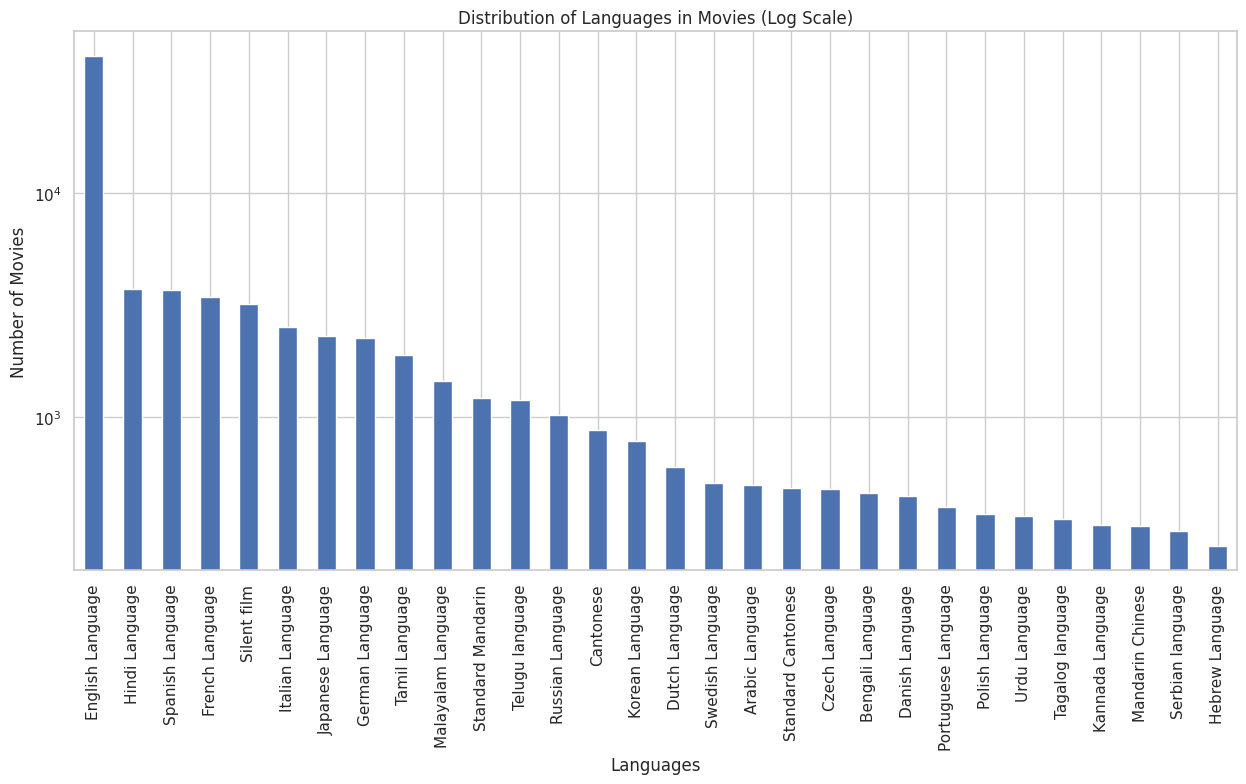

In [55]:
language_count[:30].plot(kind='bar', figsize=(15, 7), logy=True)
plt.title('Distribution of Languages in Movies (Log Scale)')
plt.xlabel('Languages')
plt.ylabel('Number of Movies')
plt.show()

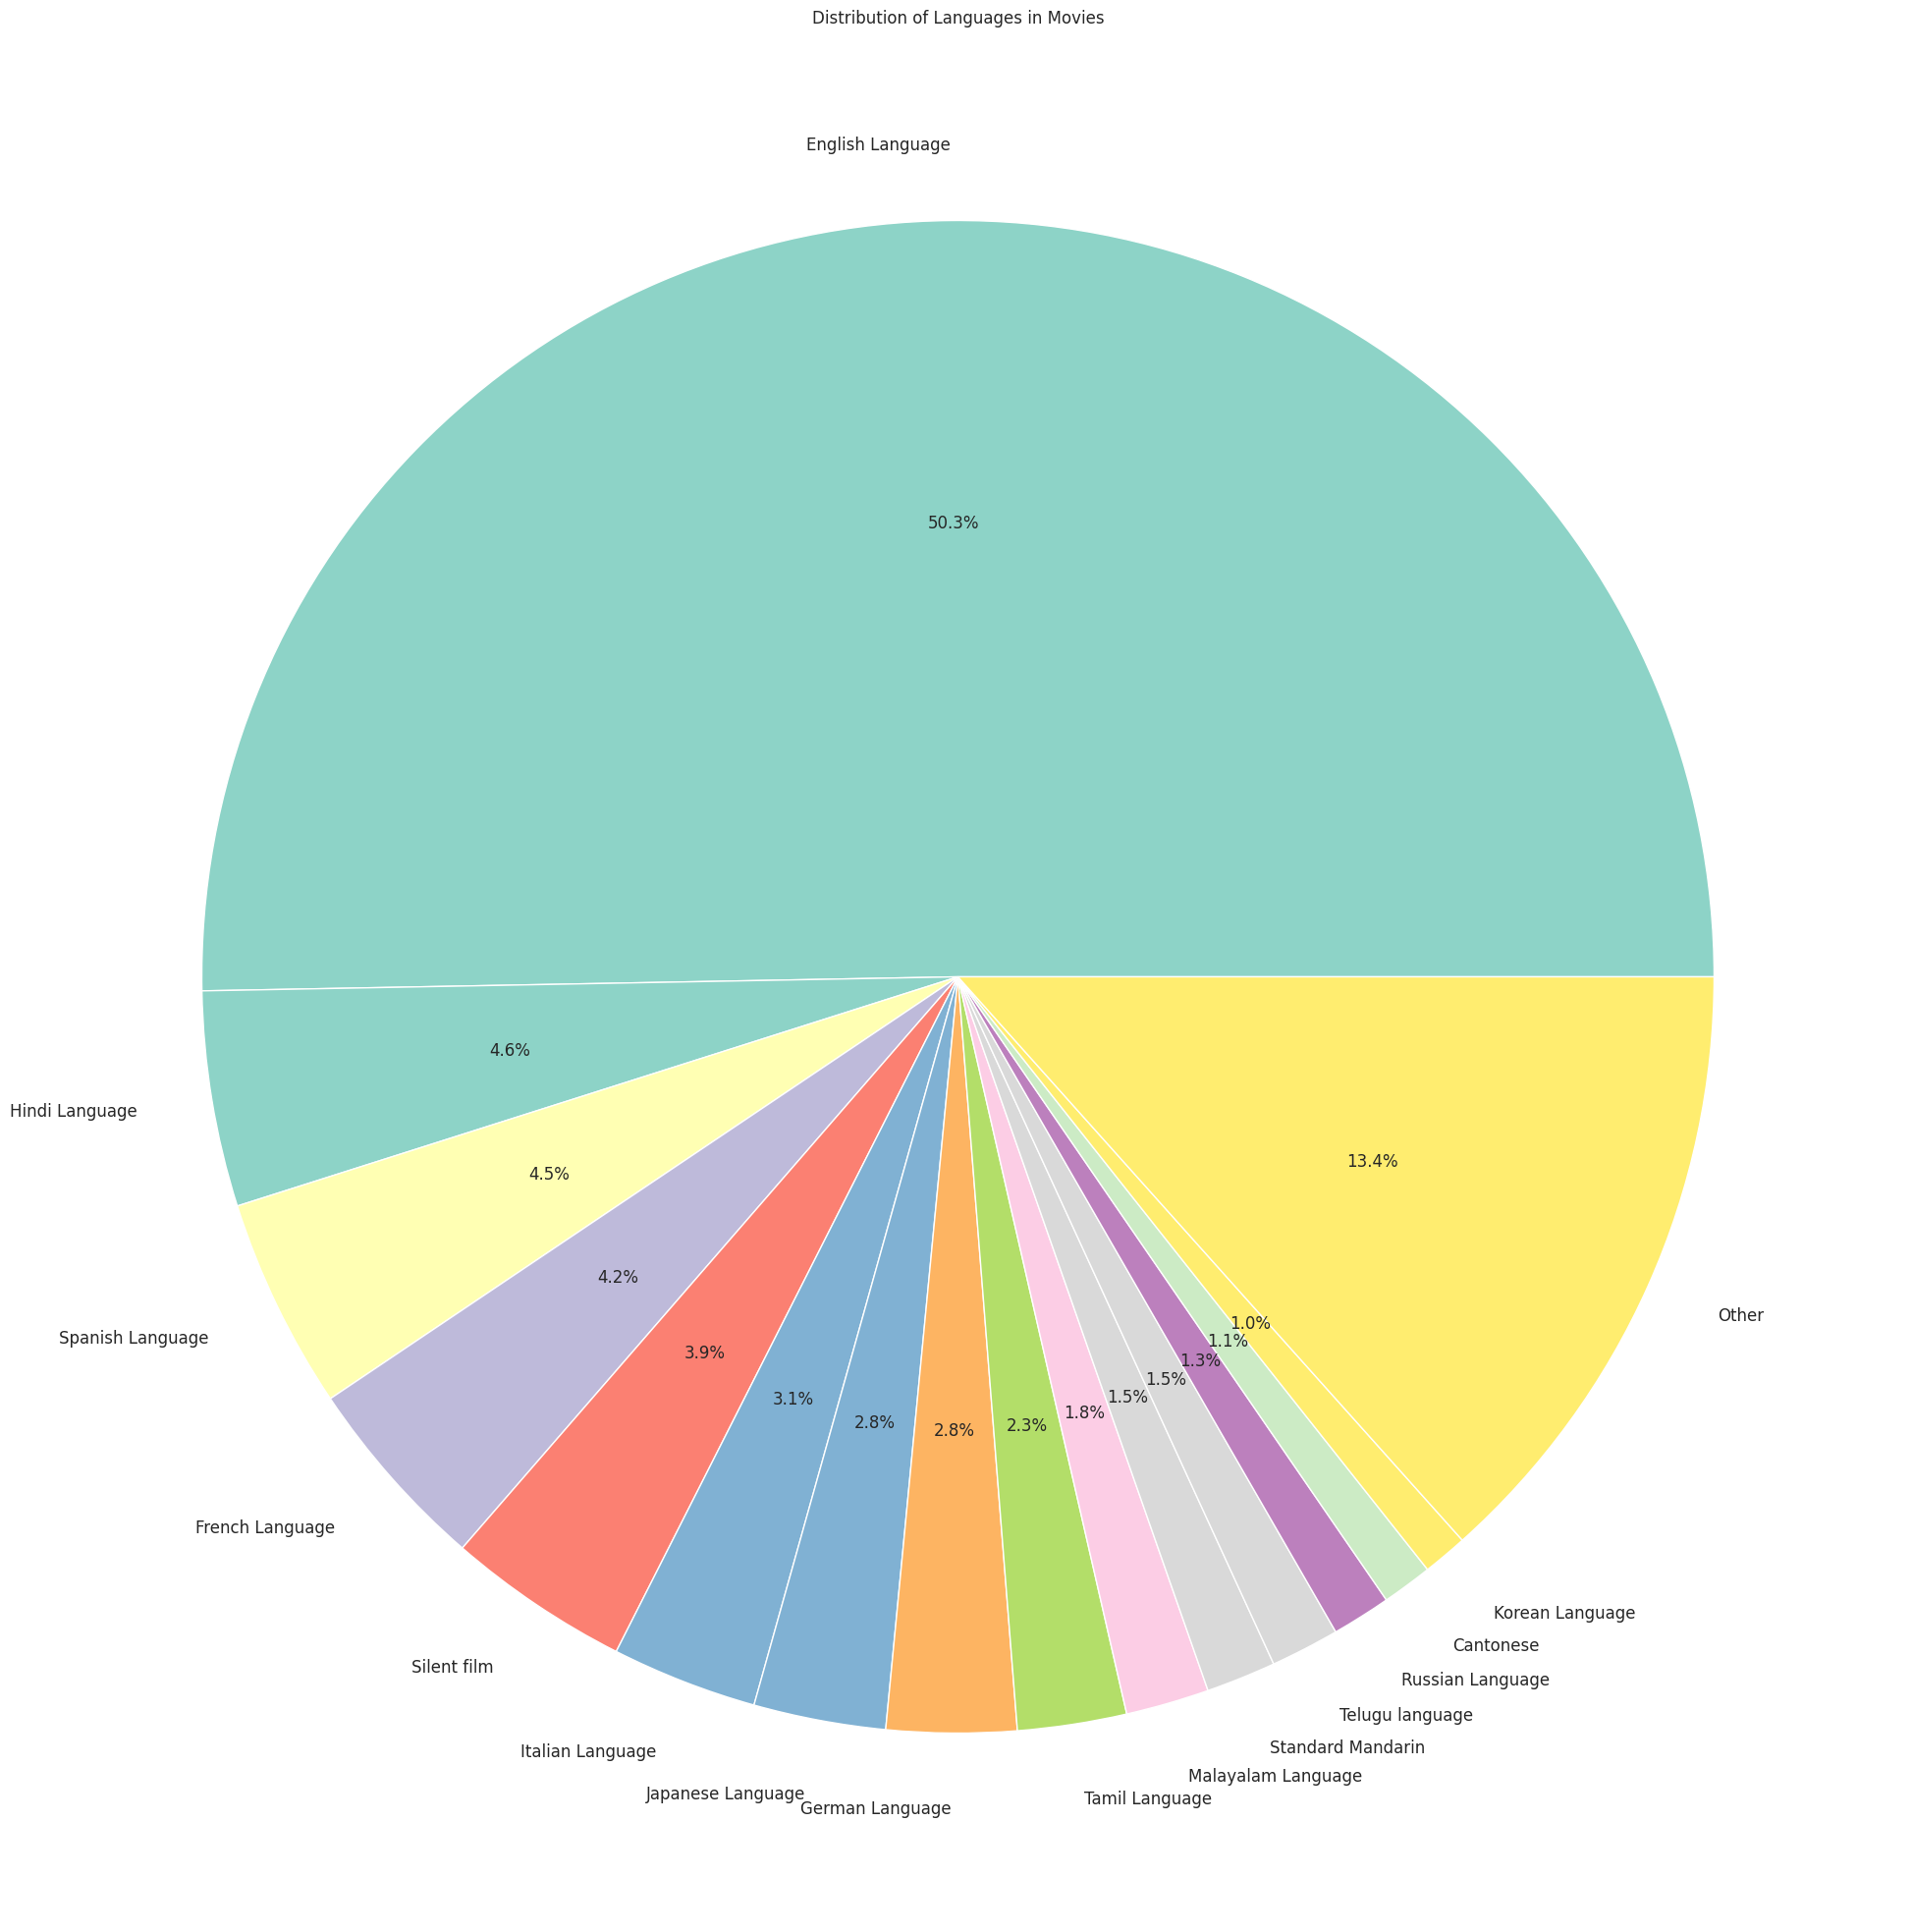

In [56]:
# Create a pie chart of the top 15 languages plus "Other"
plt.figure(figsize=(25, 25))

# Get top 15 languages and sum the rest into "Other"
top_15 = language_count[:15]
other = pd.Series({'Other': language_count[15:].sum()})
plot_data = pd.concat([top_15, other])

colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))

plt.pie(plot_data, labels=plot_data.index, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 12})
plt.title('Distribution of Languages in Movies')
plt.show()

As an explicit choice, we will keep silent films going forward because there may be some emotional profile differences for films with NO dialogue


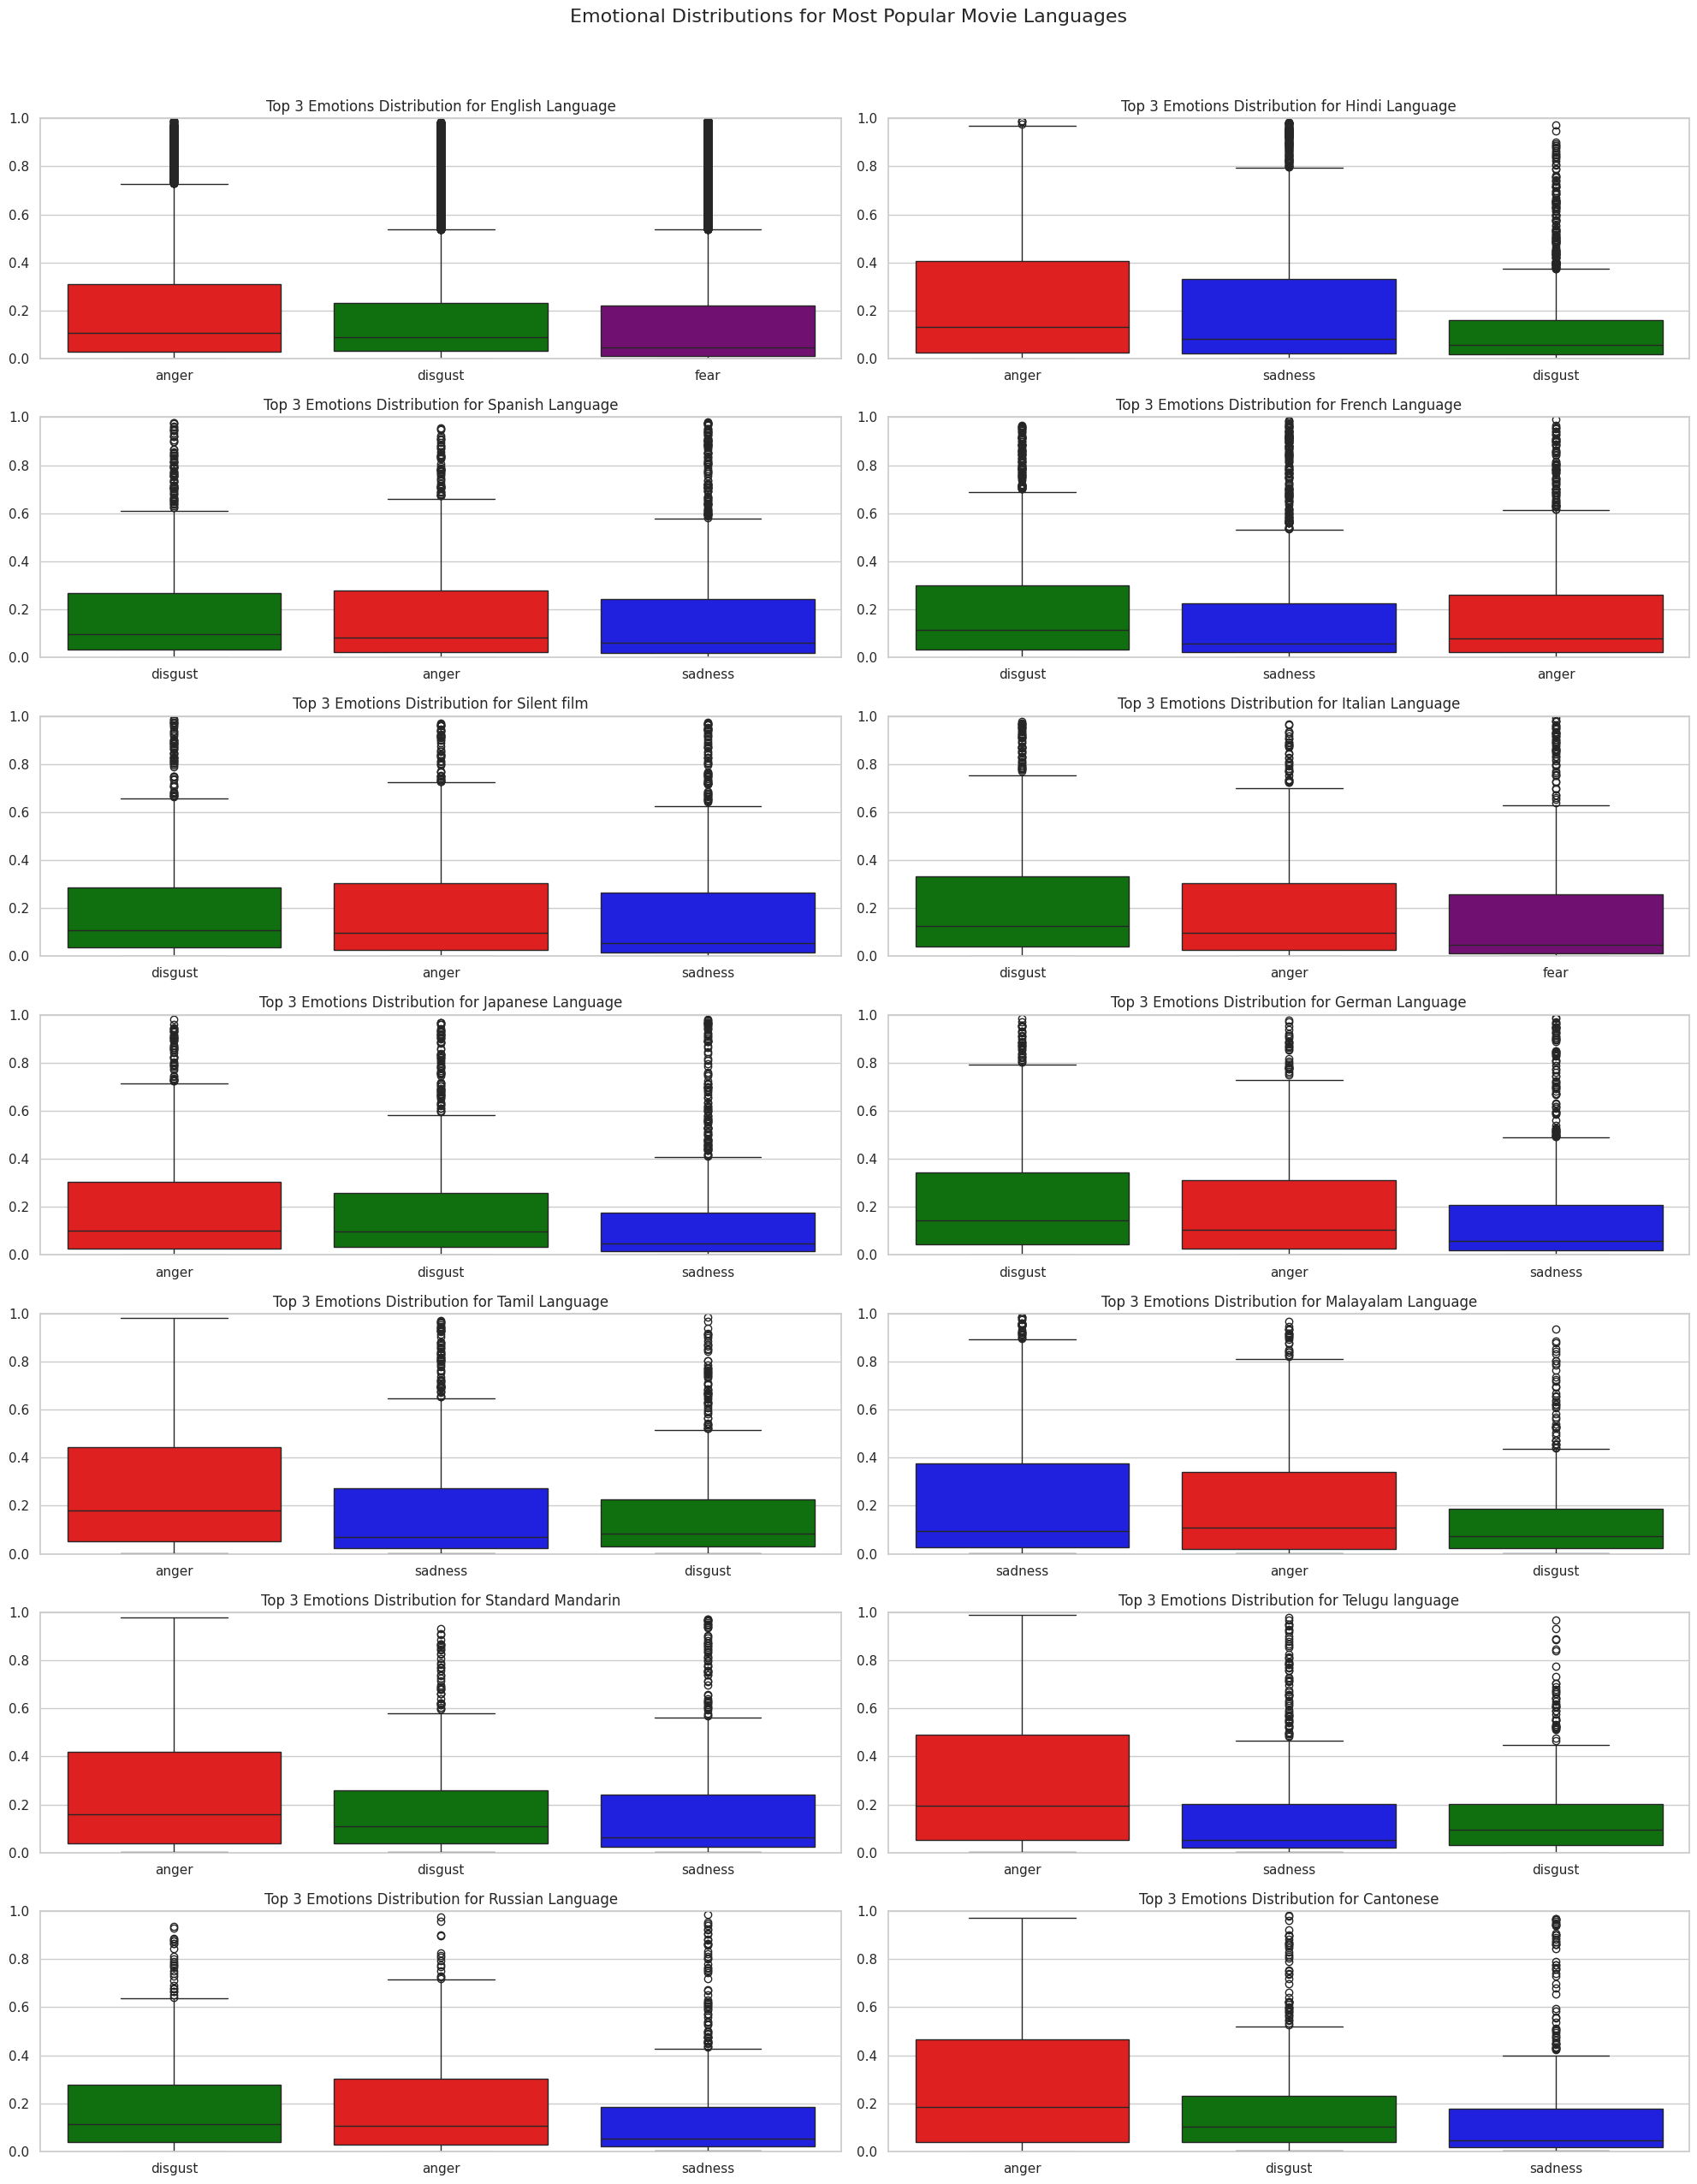

In [57]:
# Define a color palette for the emotions
emotion_palette = {
  'anger': 'red',
  'disgust': 'green',
  'sadness': 'blue',
  'fear': 'purple',
  'joy': 'yellow',
  'surprise': 'orange'
}

# We analyze the emotions of the top 14 languages
top_languages = language_count[:14].index

# For each language, get all the movies that belong to it and plot emotion distributions
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 25))
axes = axes.flatten()

for i, lang in enumerate(top_languages):
  movies_in_lang = df_languages[df_languages['Languages'].apply(lambda x: lang in x)]
  distilbert_emotions = movies_in_lang['distilbert_emotions'].dropna()
  
  # Convert list of dicts to DataFrame for easier plotting
  distilbert_emotions_df = pd.DataFrame(list(distilbert_emotions))

  # Remove neutral emotion
  distilbert_emotions_df = distilbert_emotions_df.drop('neutral', axis=1)

  # Get top 3 emotions by mean value
  top_3_emotions_distilbert = distilbert_emotions_df.mean().nlargest(3).index
  
  # Plot boxplot for this language with only top 3 emotions
  sns.boxplot(data=distilbert_emotions_df[top_3_emotions_distilbert], ax=axes[i], palette=emotion_palette)
  axes[i].set_title(f'Top 3 Emotions Distribution for {lang}')
  axes[i].set_ylim(0, 1)

plt.suptitle('Emotional Distributions for Most Popular Movie Languages', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [58]:
EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

def convert_to_percentage(emotions: dict) -> dict:
    """
    Convert emotional decimal values to percentages.
    """
    return {k: v * 100 for k, v in emotions.items()}

def prepare_data_for_analysis(df_to_prepare: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare the data for statistical analysis by:
    1. Expanding the language lists into separate rows
    2. Creating emotion columns from the dictionary
    3. Filtering for languages with sufficient data
    """

    df_new = df_to_prepare.copy()

    # Get rid of rows without emotion data
    df_new = df_new[df_new['distilbert_emotions'].apply(lambda x: isinstance(x, dict) and x != {})]

    # Multiply all the emotions by 100 so we can work with percentages
    df_new['distilbert_emotions'] = df_new['distilbert_emotions'].apply(convert_to_percentage)

     # Explode the Languages column to create separate rows for each language
    df_new = df_new.explode('Languages').reset_index(drop=True)

    # Create separate columns for each emotion
    for emotion in EMOTIONS:
        df_new[emotion] = df_new['distilbert_emotions'].apply(lambda x: x.get(emotion, np.nan))

    # Filter for languages with at least 100 movies
    language_counts = df_new['Languages'].value_counts()
    valid_languages = language_counts[language_counts >= 100].index
    df_filtered = df_new[df_new['Languages'].isin(valid_languages)]
    
    return df_filtered

REGRESSION_MODEL = "C(Languages, Treatment(reference='English Language'))"

def run_individual_regressions(df_reg: pd.DataFrame):
    """
    Perform separate regression analyses for each emotion.
    """
    
    results = {}
    for emotion in EMOTIONS:
        model = sm.OLS.from_formula(f"{emotion} ~ {REGRESSION_MODEL}", data=df_reg).fit()
        results[emotion] = {
            'r_squared': model.rsquared,
            'significant_effects': model.pvalues[model.pvalues < 0.05],
            'significant_params': model.params[model.pvalues < 0.05],
            'model': model
        }

    return results

# Prepare the data
df_analysis = prepare_data_for_analysis(df_languages)

# Run all analyses
regression_results = run_individual_regressions(df_analysis)

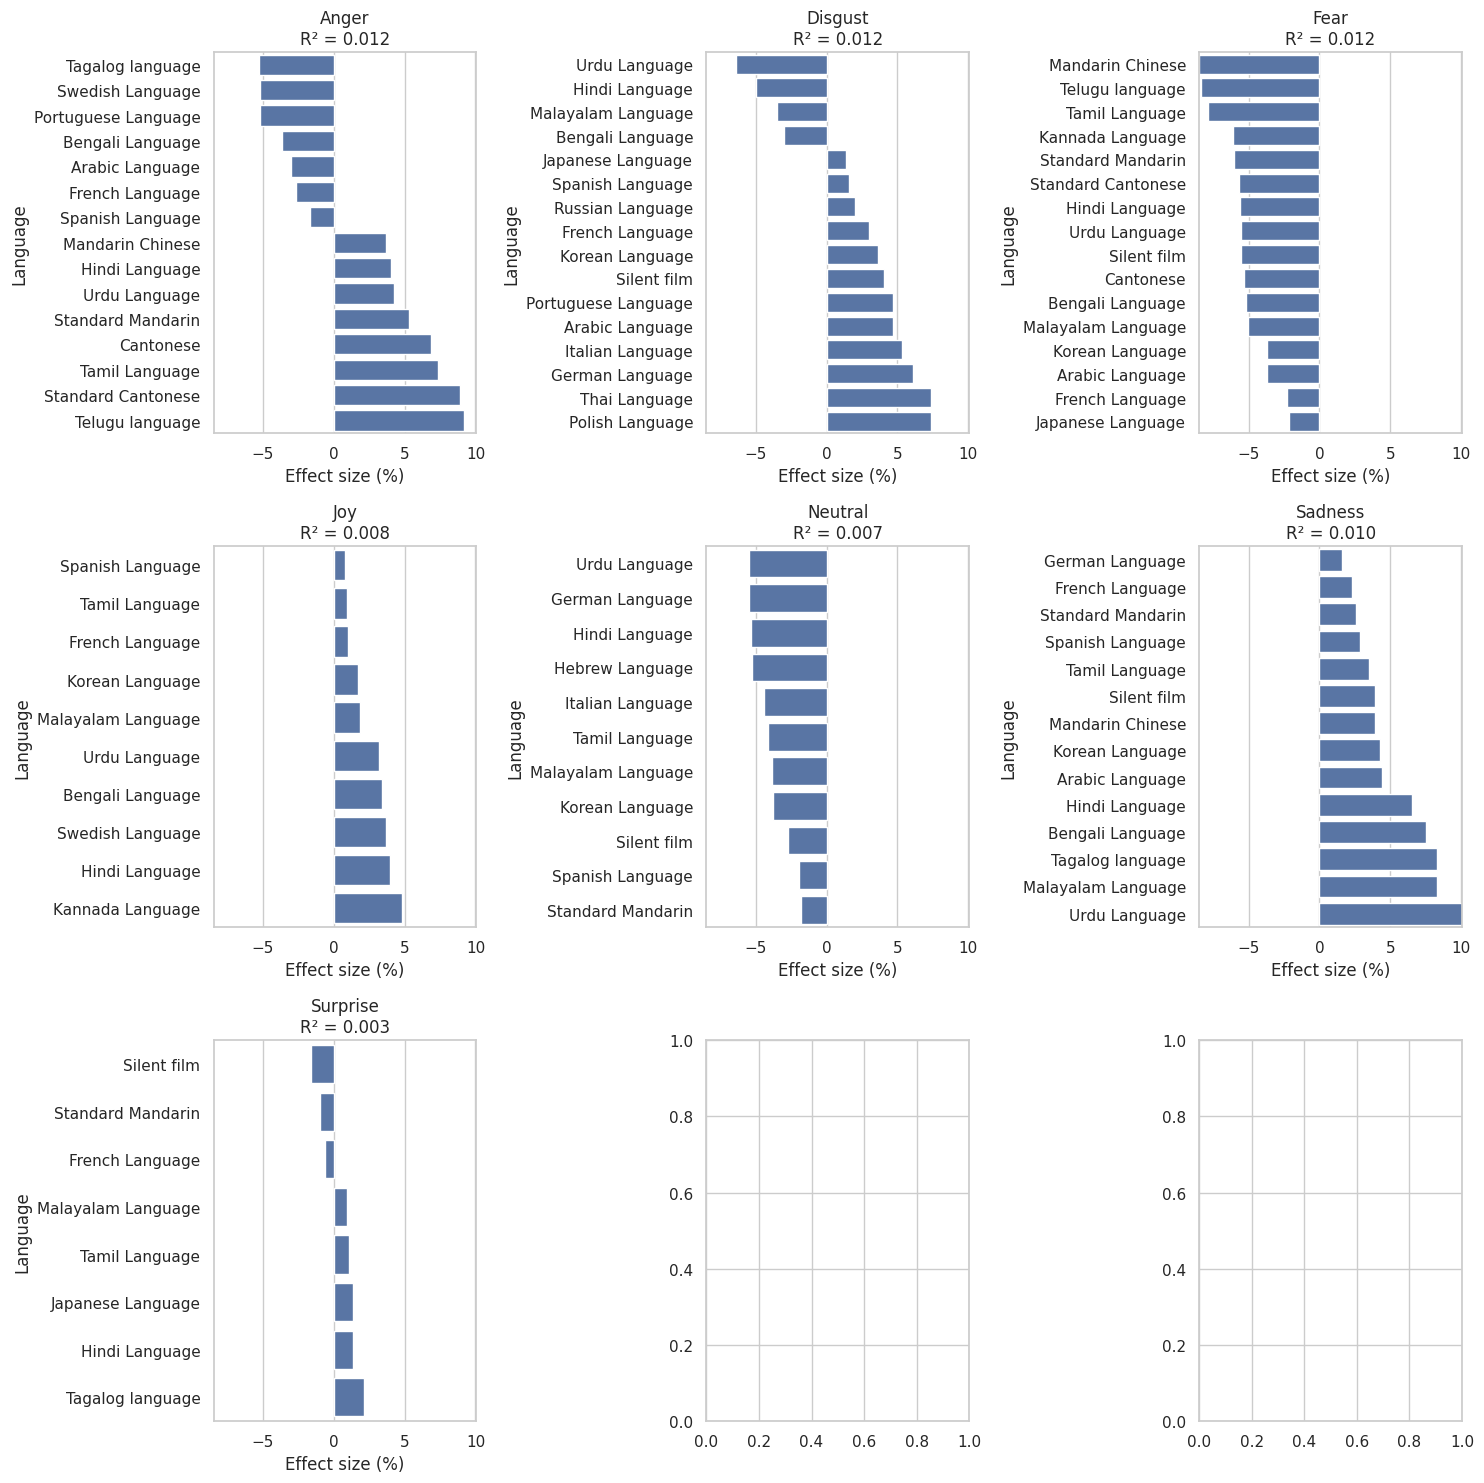

In [59]:
# Plot significant parameters for each emotion
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Find global min and max for consistent scale
all_params = []
for emotion in EMOTIONS:
    significant_params = regression_results[emotion]['significant_params']
    params_no_intercept = significant_params[1:]
    all_params.extend(params_no_intercept.values)
global_min, global_max = min(all_params), max(all_params)

for i, emotion in enumerate(EMOTIONS):
    if i < len(axes):
        significant_params = regression_results[emotion]['significant_params']
        
        # Don't include intercept
        params_no_intercept = significant_params[1:]  
        params_sorted = params_no_intercept.sort_values(ascending=True)

        y_labels = params_sorted.index.astype(str).str.extract(r'\[T\.(.*?)\]')[0]

        # Create bar plot
        sns.barplot(x=params_sorted.values, 
                   y=y_labels, 
                   ax=axes[i])
        
        axes[i].set_title(f'{emotion.capitalize()}\nR² = {regression_results[emotion]["r_squared"]:.3f}')
        axes[i].set_xlabel('Effect size (%)')
        axes[i].set_ylabel('Language')
        axes[i].set_xlim(global_min, global_max)  # consistent scale

plt.tight_layout()

## Analysis of Regression Results

### Reference Category: English
English was selected as the reference category for the regression analysis because it is both the largest and most normative language category in the dataset.

### Low Overall Effect Size of Language on Emotional Content
- The $R^2$ values for the models are very low (ranging from 0.003 to 0.012), indicating that language explains only a minimal portion of the variance in emotional content.
- This result is expected, as the emotional tone of a film is predominantly influenced by factors such as its **plot**, **acting**, **cinematography**, and other creative elements rather than the language itself.

### Specific Observations
- For the **fear** emotion, all languages that showed significant effects had **negative coefficients** compared to English, indicating a lower proportion of "fear" in films made in those languages.
- Conversely, for the **joy** and **sadness** emotions, all languages with significant effects had **positive coefficients** compared to English, suggesting a higher proportion of these emotions in films made in those languages.


##### Correlated emotions
OLS assumes that emotions from the same movie are treated as independent observations. However, this is probably not true because a more positive-film is more likely to have more positive emotions.

In [60]:
# Run MANOVA for a multivariate analysis of the emotions
manova_data = prepare_data_for_analysis(df_languages)
manova = MANOVA.from_formula('anger + disgust + fear + joy + sadness + surprise ~ Languages', data=manova_data)
print("\nMANOVA Results:")
print(manova.mv_test())
manova_results = manova.mv_test()

manova_results.summary()


MANOVA Results:
                    Multivariate linear model
                                                                  
------------------------------------------------------------------
         Intercept        Value  Num DF   Den DF   F Value  Pr > F
------------------------------------------------------------------
            Wilks' lambda 0.8999 6.0000 34012.0000 630.2629 0.0000
           Pillai's trace 0.1001 6.0000 34012.0000 630.2629 0.0000
   Hotelling-Lawley trace 0.1112 6.0000 34012.0000 630.2629 0.0000
      Roy's greatest root 0.1112 6.0000 34012.0000 630.2629 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
       Languages        Value   Num DF     Den DF   F Value Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.9447 162.0000 199859.5822 12.0125 0.0000

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Multivariate linear model
==================================================================
                                                                  
------------------------------------------------------------------
         Intercept        Value  Num DF   Den DF   F Value  Pr > F
------------------------------------------------------------------
            Wilks' lambda 0.8999 6.0000 34012.0000 630.2629 0.0000
           Pillai's trace 0.1001 6.0000 34012.0000 630.2629 0.0000
   Hotelling-Lawley trace 0.1112 6.0000 34012.0000 630.2629 0.0000
      Roy's greatest root 0.1112 6.0000 34012.0000 630.2629 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
       Languages        Value   Num DF     Den DF   F Value Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.9447 162.0000 199859.5822 12.0125 0.0000
         Pillai's trace 0.0563 162.0000 204102.0000 11.9396 0.0000
 Hotelling-Lawley trace 0.0576 162.0000 164024.1490 12.0840 0.0000
    Roy's greatest root 0.0326  27.0000  34017.0000 41.0179 0.0000
==================================================================

"""

## MANOVA Results

The results from all four test statistics (**Wilks' Lambda**, **Pillai's Trace**, **Hotelling-Lawley Trace**, and **Roy's Greatest Root**) indicate highly significant differences in emotional expression patterns across movies in different languages ($Pr > F = 0.0000$). This provides strong evidence that language plays a role in shaping emotional tones in films.

However, the effect sizes are very small, as anticipated from the earlier ANOVA results for individual emotions. For example, a Wilks' Lambda value of **0.9447** suggests that only **5.53%** of the variance in emotional expression can be attributed to language, highlighting that most of the variability is explained by other factors. 


# Can Films Be Clustered by Their Emotional Tone? And Do These Clusters Reveal Distinct Patterns in Consumer Ratings?

#### To investigate whether films can be grouped based on their emotional tones and whether these clusters reveal distinct patterns in consumer ratings, we began with an exploratory analysis.


In [67]:
df = pd.read_csv('../../data/final_data_complete.csv')

temp = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))

emotions_df = pd.concat([df, temp], axis=1)
assert emotions_df["distilbert_emotions"].isna().sum() == emotions_df["Plot"].isna().sum()

In [68]:
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
ratings = ['mean_ratings', 'std_dev_ratings']


filter_df = emotions_df.dropna(subset=['Plot'])
final_df = filter_df[emotions + ratings].reset_index(drop=True)
final_df.head()

disgust      fear     anger   neutral   sadness  surprise       joy  \
0  0.502122  0.351022  0.065147  0.057085  0.018771  0.004086  0.001766   
1  0.324022  0.032032  0.502404  0.096385  0.037811  0.005438  0.001907   
2  0.163747  0.002405  0.325650  0.440068  0.025255  0.005851  0.037024   
3  0.021709  0.010488  0.006082  0.042634  0.915504  0.002163  0.001421   
4  0.004746  0.003841  0.016094  0.679410  0.057925  0.129912  0.108072   

   mean_ratings  std_dev_ratings  
0      2.427083         1.087064  
1      2.250000         2.474874  
2           NaN              NaN  
3           NaN              NaN  
4      4.140052         0.835965

## Initial Exploration: Emotional Tone Distribution

### Scale Consistency
The emotional tone proportions are already on the same scale (0-1), eliminating the need for additional normalization.

### Visualizations
1. **Box Plots for Each Emotion**:
   - We plotted box plots for all emotions to examine the distribution, detect outliers, and identify potential patterns or biases in the dataset.
   - This step provided a clear summary of the central tendencies and variability of each emotional tone.

2. **Density Curves for Each Emotion**:
   - We plotted the density curves to visualize the overall distribution of emotional scores.
   - These curves helped us understand the frequency and concentration of specific emotion scores across the dataset.


(33684, 9)
(235788, 2)


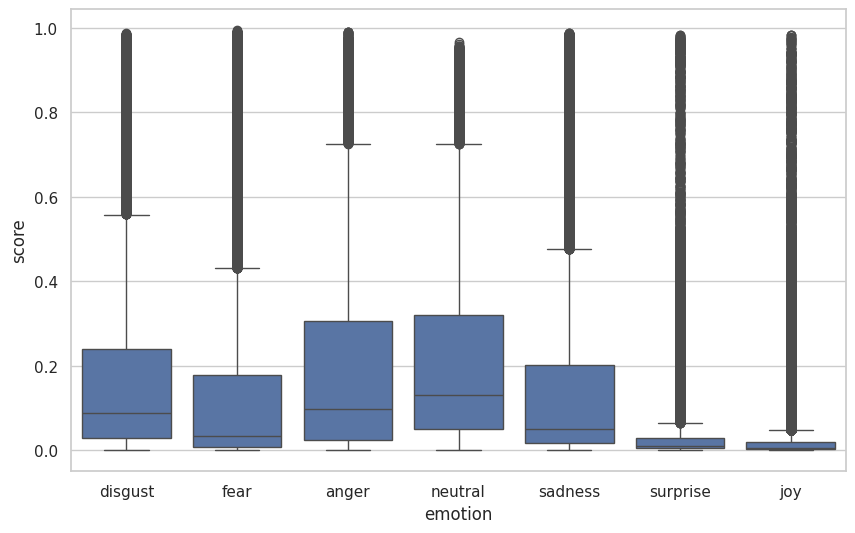

In [69]:
print(final_df.shape)

long_df = pd.melt(final_df[emotions], var_name='emotion', value_name='score')
print(long_df.shape)

plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='score', data=long_df)
plt.show()

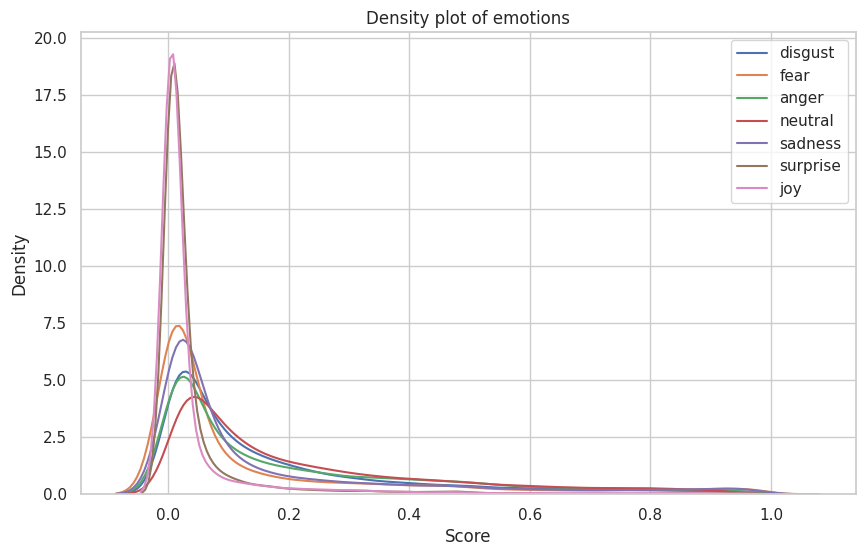

In [70]:
plt.figure(figsize=(10, 6))
for emotion in final_df[emotions].columns:
    sns.kdeplot(final_df[emotion], label=emotion, fill=False)
plt.xlabel('Score')
plt.legend()
plt.title('Density plot of emotions')
plt.show()


## Clustering Films by Emotional Tone: Hierarchical Clustering

### Hierarchical Clustering Approach

We began with **hierarchical clustering**, a method that builds a hierarchy of clusters by measuring distances between pairs of data points and linking them iteratively. For this analysis:
- We used **average linkage** as the linkage criterion, which computes the average distance between points in different clusters.
- We employed **cosine distance** as the distance metric.

---

### Why Cosine Distance is Suitable for Proportion Data

Cosine distance is particularly effective for analyzing proportional data, such as emotional scores, because it focuses on the **direction** of the data vector rather than its magnitude. This makes it well-suited for comparing proportions that sum to a constant value (e.g., 1).

#### Cosine Similarity Formula
Cosine similarity measures the cosine of the angle between two vectors:
$$
\text{Cosine Similarity} = \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \|\vec{B}\|}
$$
Where:
- $\vec{A}$ and $\vec{B}$ are the vectors of emotional proportions for two films.
- $\|\vec{A}\|$ and $\|\vec{B}\|$ are the magnitudes (Euclidean norms) of the vectors:
  $$
  \|\vec{A}\| = \sqrt{\sum_{i=1}^{n} A_i^2}
  $$

#### Cosine Distance Formula
Cosine distance is derived as:
$$
\text{Cosine Distance} = 1 - \text{Cosine Similarity}
$$

#### Why It Works for Proportions
- **Focus on Direction**: Cosine distance compares the relative composition of emotions in two films, ignoring differences in scale.
- **Insensitive to Magnitude**: Proportion data inherently lacks magnitude variation, so cosine distance avoids penalizing differences in overall magnitude that are irrelevant to the analysis.

---

### Challenges with Hierarchical Clustering for Large Datasets

Hierarchical clustering computes distances between every pair of data points, resulting in a time complexity of $O(n^2)$ for $n$ data points. This makes it computationally expensive and unsuitable for large datasets.

To address this, we:
1. **Sampled the Dataset**: Selected a random sample of **500 films** for clustering. This ensured computational feasibility while retaining a representative subset of the data.
2. **Explored Scalability**: Used the results of hierarchical clustering as a benchmark to guide the choice of more advanced, scalable clustering algorithms for the full dataset.

This approach allowed us to gain initial insights into the structure of the data while preparing for the application of efficient clustering techniques. 

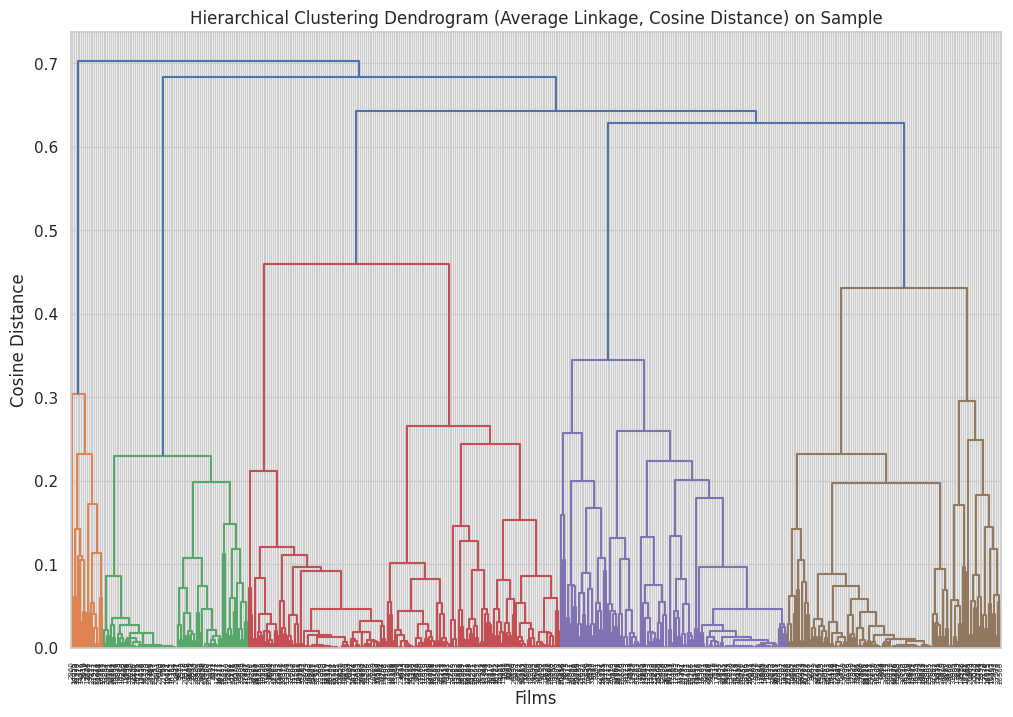

In [71]:
#Perform Hierarchical Clustering with average linkage and cosine distance, no normalization
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

sample_df = final_df.sample(500, random_state=42)

cluster_df = sample_df[emotions].copy()

distance_matrix = pdist(cluster_df, metric='cosine')
linkage_matrix = linkage(distance_matrix, method='average')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=cluster_df.index, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (Average Linkage, Cosine Distance) on Sample')
plt.xlabel('Films')
plt.ylabel('Cosine Distance')
plt.show()


In [72]:
cutoff = 0.36

cluster_labels = fcluster(linkage_matrix, t = cutoff, criterion='distance')
cluster_df['cluster'] = cluster_labels


distance_square = squareform(distance_matrix)

def compute_inner_cluster_distances(labels, distances):
    unique_clusters = np.unique(labels)
    inner_distances = {}
    for cluster in unique_clusters:
        indices = np.where(labels == cluster)[0]
        if len(indices) > 1:
            intra_dist = distances[np.ix_(indices, indices)].mean()
        else:
            intra_dist = 0  # Single-point cluster
        inner_distances[cluster] = intra_dist
    return inner_distances

inner_cluster_distances = compute_inner_cluster_distances(cluster_labels, distance_square)
inner_cluster_distances

{1: 0.17915203395297508,
 2: 0.1548717409338018,
 3: 0.08524913979233686,
 4: 0.19856307786260435,
 5: 0.22647867626450144,
 6: 0.12105150467831619,
 7: 0.20818028729421426}

In [73]:
sample_df = pd.concat([cluster_df, sample_df[ratings]], axis=1)
cluster_summary = sample_df.groupby('cluster').mean()
cluster_summary

disgust      fear     anger   neutral   sadness  surprise       joy  \
cluster                                                                         
1        0.109742  0.064062  0.089342  0.134547  0.073385  0.504592  0.024330   
2        0.095067  0.593484  0.150145  0.097640  0.034013  0.021828  0.007823   
3        0.097704  0.051368  0.646144  0.103608  0.058588  0.019774  0.022814   
4        0.474915  0.039981  0.229493  0.157039  0.073580  0.010769  0.014224   
5        0.098432  0.081701  0.098737  0.138472  0.529758  0.027796  0.025103   
6        0.066829  0.063999  0.076389  0.636251  0.056975  0.040132  0.059425   
7        0.080505  0.016390  0.058520  0.267902  0.117829  0.053301  0.405553   

         mean_ratings  std_dev_ratings  
cluster                                 
1            2.869160         0.997983  
2            2.792405         0.910411  
3            2.943252         0.997451  
4            3.106239         0.966592  
5            3.079460         1.061549  
6            3.022045         1.059960  
7            2.664684         1.026668

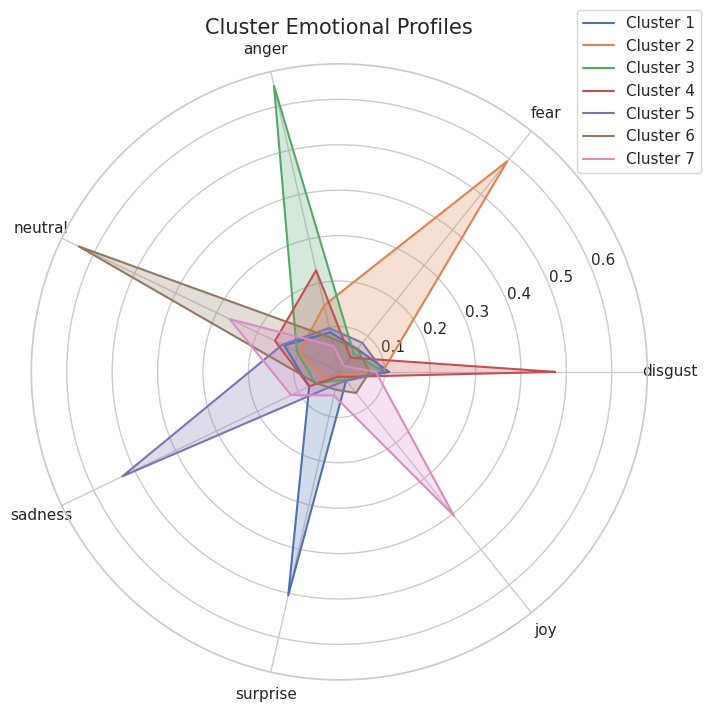

In [74]:
def plot_radar_chart(data, title):
    categories = data.columns
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, row in data.iterrows():
        values = row.tolist() + row.tolist()[:1]
        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)
        
    ax.set_title(title, size=15)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()

plot_radar_chart(cluster_summary[emotions], "Cluster Emotional Profiles")


## Dendrogram Analysis and Cluster Selection

### Determining the Optimal Number of Clusters

From the **dendrogram** generated by the hierarchical clustering, we identified a plausible cut-off at a distance of **0.36**. This cut-off:
- Balances a relatively short distance with clear separation between clusters.
- Results in **7 distinct clusters**, corresponding to the number of primary emotional tones in our dataset.

This outcome suggests that films can be meaningfully grouped based on their **primary emotional tone**, aligning with the intuition that emotional dominance plays a significant role in categorizing movies.

---

### Evaluating the Clustering Results

1. **Inner Distances**:
   - We calculated the inner distances within each cluster to evaluate their compactness and coherence.
   - Lower inner distances indicate that films within the same cluster are similar in their emotional profiles, validating the quality of the clustering.

2. **Radar Graph**:
   - To interpret the results, we created a **radar graph** for each cluster.
   - The radar graph visualized the average emotional profile of films within each cluster, highlighting the dominance of specific emotions.
   - This step provided a clear understanding of the distinct characteristics of each cluster and their alignment with the emotional tones.
